In [1]:
import fastf1 as f1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("FastF1 version:", f1.__version__)

f1.Cache._enable_default_cache()

req         WARNING 	DEFAULT CACHE ENABLED! (2.5 GB) /Users/seansica/Library/Caches/fastf1


FastF1 version: 3.5.3


In [2]:
year: int = 2024
# max_races: int = None
grand_prix_only: bool = True

In [6]:
session = f1.get_session(year, 'Saudi Arabian Grand Prix', 'R')
session.load()

core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '16', '81', '14', '63', '38', '4', '44', '27', '23', '20', '31', '2', '22', '3', '77', '24', '18', '10']


In [30]:
from dataclasses import dataclass
from typing import Optional, List, Dict

@dataclass
class SafetyCarEvent:
    """Represents a safety car deployment with precise timing."""
    deployment_time: pd.Timestamp
    lap_context: Optional[int] = None  # For reference, but not used in prediction

@dataclass
class TemporalWindow:
    """Represents a temporal prediction window for one driver."""
    driver: str
    window_start: pd.Timestamp
    window_end: pd.Timestamp
    prediction_target_time: pd.Timestamp  # When we're predicting SC deployment
    prediction_window_end: pd.Timestamp   # End of prediction window
    laps_data: pd.DataFrame               # Driver's laps in this window
    telemetry_data: Optional[Dict] = None # Additional telemetry if available


In [11]:
# Find safety car deployments
track_status_df = session.track_status
sc_deployments = track_status_df[track_status_df['Status'] == '4'].copy()

events = []
for _, sc_row in sc_deployments.iterrows():
    # track_status 'Time' column is actually SessionTime
    event = SafetyCarEvent(
        deployment_time=sc_row['Time']  # This is SessionTime
    )
    events.append(event)

In [12]:
events

[SafetyCarEvent(deployment_time=Timedelta('0 days 01:09:49.924000'), lap_context=None)]

In [32]:
time_step = pd.Timedelta(minutes=1)
lookback_window = pd.Timedelta(minutes=5)
prediction_horizon = pd.Timedelta(minutes=2)

In [33]:
def create_driver_windows(
    driver: str, 
    driver_laps: pd.DataFrame, 
    events: List[SafetyCarEvent], 
    session_start: pd.Timestamp, 
    session_end: pd.Timestamp
):
    """
    Create temporal windows for a single driver using SessionTime consistently.
    """
    
    windows = []
    
    # Start sliding from when this driver has enough historical data
    current_session_time = session_start + lookback_window
    
    # Slide through SessionTime until we can't make meaningful predictions
    while current_session_time + prediction_horizon <= session_end:
        
        # Define the lookback window for this prediction (all in SessionTime)
        window_start = current_session_time - lookback_window
        window_end = current_session_time
        
        # Define the prediction target window (in SessionTime)
        prediction_target_time = current_session_time
        prediction_window_end = current_session_time + prediction_horizon
        
        # Get driver's laps in the lookback window
        # Use LapStartTime (SessionTime) for filtering
        window_laps = driver_laps[
            (driver_laps['LapStartTime'] >= window_start) & 
            (driver_laps['LapStartTime'] <= window_end)
        ].copy()
        
        # Only create window if we have meaningful data
        if len(window_laps) >= 1:  # At least one lap of data
            
            # Determine if this window should predict a safety car
            # Compare SessionTime to SessionTime
            has_sc_in_prediction_window = any(
                prediction_target_time <= event.deployment_time <= prediction_window_end
                for event in events
            )
            
            window = TemporalWindow(
                driver=driver,
                window_start=window_start,
                window_end=window_end,
                prediction_target_time=prediction_target_time,
                prediction_window_end=prediction_window_end,
                laps_data=window_laps
            )
            
            # Add metadata about whether this window should predict SC
            window.should_predict_sc = has_sc_in_prediction_window
            
            windows.append(window)
        
        # Slide forward by time step (in SessionTime)
        current_session_time += time_step

In [ ]:
laps_df = session.laps

# Use SessionTime consistently - LapStartTime is SessionTime for lap starts
# 'Time' in laps is SessionTime for lap completion
session_start = laps_df['LapStartTime'].min()
session_end = laps_df['Time'].max()

# Get all drivers
drivers = laps_df['Driver'].unique()

windows = []

# For each driver, create sliding temporal windows
# for driver in drivers:
#     driver_laps = laps_df[laps_df['Driver'] == driver].copy()
#     driver_laps = driver_laps.sort_values('LapStartTime')    
#     windows.extend(create_driver_windows(driver, driver_laps, events, session_start, session_end))

driver_laps = laps_df[laps_df['Driver'] == 'VER'].copy()
driver_laps.columns
# Index(['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint',
#    'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
#    'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
#    'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest',
#    'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
#    'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason',
#    'FastF1Generated', 'IsAccurate'],
#   dtype='object')

Index(['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint',
       'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
       'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
       'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest',
       'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
       'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason',
       'FastF1Generated', 'IsAccurate'],
      dtype='object')

In [ ]:
driver_laps.iloc[0].get_car_data()
# Return Type: fastf1.core.Telemetry (wrapper around Pandas Dataframe)
# Columns: Date, RPM, Speed, nGear, Throttle, Brake, DRS, Source, Time, SessionTime
# Dimensions: 374 rows × 10 columns

driver_laps.iloc[0].get_pos_data()
# Return Type: fastf1.core.Telemetry (wrapper around Pandas Dataframe)
# Columns: Date, Status, X, Y, Z, Source, Time, SessionTime
# Dimensions: 384 rows × 8 columns

driver_laps.iloc[0].get_weather_data()
# Type: pandas.core.series.Series
# Example output:
# Time             0 days 01:00:08.558000
# AirTemp                            25.4
# Humidity                           62.0
# Pressure                         1012.5
# Rainfall                          False
# TrackTemp                          31.5
# WindDirection                       358
# WindSpeed                           1.3
# Name: 60, dtype: object

Time             0 days 01:00:08.558000
AirTemp                            25.4
Humidity                           62.0
Pressure                         1012.5
Rainfall                          False
TrackTemp                          31.5
WindDirection                       358
WindSpeed                           1.3
Name: 60, dtype: object

In [54]:
import pandas as pd
import numpy as np

def create_high_freq_dataset(session, interval_seconds=1.0):
    """
    Create high-frequency dataset with fixed time intervals using session time
    """
    laps_df = session.laps
    
    # Work with session timedeltas
    session_start = laps_df['LapStartTime'].min()
    session_end = laps_df['Time'].max()
    
    # Create time grid as seconds from session start
    start_seconds = session_start.total_seconds()
    end_seconds = session_end.total_seconds()
    
    time_grid_seconds = np.arange(start_seconds, end_seconds, interval_seconds)
    
    all_driver_data = []
    
    for driver in laps_df['Driver'].unique():
        driver_laps = laps_df[laps_df['Driver'] == driver].copy()
        driver_telemetry = []
        
        for _, lap in driver_laps.iterrows():
            try:
                # Get telemetry for this lap
                car_data = lap.get_car_data()
                pos_data = lap.get_pos_data()
                weather_data = lap.get_weather_data()
                
                # Convert SessionTime to seconds for easier indexing
                if not car_data.empty:
                    car_data = car_data.copy()
                    car_data['SessionSeconds'] = car_data['SessionTime'].dt.total_seconds()
                    
                if not pos_data.empty:
                    pos_data = pos_data.copy()
                    pos_data['SessionSeconds'] = pos_data['SessionTime'].dt.total_seconds()
                
                # Store lap-level data
                lap_static = {
                    'Driver': driver,
                    'LapNumber': lap['LapNumber'],
                    'Compound': lap['Compound'],
                    'TyreLife': lap['TyreLife'],
                    'AirTemp': weather_data['AirTemp'] if pd.notna(weather_data['AirTemp']) else None,
                    'TrackTemp': weather_data['TrackTemp'] if pd.notna(weather_data['TrackTemp']) else None,
                    'Humidity': weather_data['Humidity'] if pd.notna(weather_data['Humidity']) else None,
                }
                
                driver_telemetry.append({
                    'car_data': car_data,
                    'pos_data': pos_data,
                    'lap_static': lap_static,
                    'lap_start_seconds': lap['LapStartTime'].total_seconds(),
                    'lap_end_seconds': lap['Time'].total_seconds()
                })
                
            except Exception as e:
                print(f"Skipping lap {lap['LapNumber']} for {driver}: {e}")
                continue
        
        # Align to time grid for this driver
        driver_grid_data = align_to_time_grid(driver_telemetry, time_grid_seconds)
        all_driver_data.append(driver_grid_data)
    
    # Combine all drivers
    final_df = pd.concat(all_driver_data, ignore_index=True)
    return final_df

def align_to_time_grid(driver_telemetry, time_grid_seconds):
    """
    Align driver telemetry to fixed time grid using seconds
    """
    grid_data = []
    
    for grid_time_sec in time_grid_seconds:
        # Find which lap this time belongs to
        current_lap_data = None
        for lap_tel in driver_telemetry:
            if lap_tel['lap_start_seconds'] <= grid_time_sec <= lap_tel['lap_end_seconds']:
                current_lap_data = lap_tel
                break
        
        if current_lap_data is None:
            continue
            
        # Find closest telemetry points
        car_data = current_lap_data['car_data']
        pos_data = current_lap_data['pos_data']
        
        row = {'SessionTimeSeconds': grid_time_sec}
        row.update(current_lap_data['lap_static'])
        
        # Get closest car telemetry
        if not car_data.empty:
            time_diffs = np.abs(car_data['SessionSeconds'] - grid_time_sec)
            car_idx = time_diffs.idxmin()
            car_row = car_data.loc[car_idx]
            row.update({
                'Speed': car_row['Speed'],
                'RPM': car_row['RPM'],
                'Throttle': car_row['Throttle'],
                'Brake': car_row['Brake'],
                'nGear': car_row['nGear'],
                'DRS': car_row['DRS']
            })
        
        # Get closest position telemetry  
        if not pos_data.empty:
            time_diffs = np.abs(pos_data['SessionSeconds'] - grid_time_sec)
            pos_idx = time_diffs.idxmin()
            pos_row = pos_data.loc[pos_idx]
            row.update({
                'X': pos_row['X'],
                'Y': pos_row['Y'], 
                'Z': pos_row['Z']
            })
            
        grid_data.append(row)
    
    return pd.DataFrame(grid_data)

# Usage
dataset = create_high_freq_dataset(session, interval_seconds=1.0)
print(f"Dataset shape: {dataset.shape}")
print(f"Columns: {dataset.columns.tolist()}")

Dataset shape: (88485, 17)
Columns: ['SessionTimeSeconds', 'Driver', 'LapNumber', 'Compound', 'TyreLife', 'AirTemp', 'TrackTemp', 'Humidity', 'Speed', 'RPM', 'Throttle', 'Brake', 'nGear', 'DRS', 'X', 'Y', 'Z']


In [57]:
dataset['Driver'].unique()

array(['VER', 'GAS', 'PER', 'ALO', 'LEC', 'STR', 'SAR', 'MAG', 'TSU',
       'ALB', 'ZHO', 'HUL', 'RIC', 'OCO', 'BEA', 'NOR', 'HAM', 'RUS',
       'BOT', 'PIA'], dtype=object)

In [59]:
dataset[dataset['Driver']=='VER']

,SessionTimeSeconds,Driver,LapNumber,Compound,TyreLife,AirTemp,TrackTemp,Humidity,Speed,RPM,Throttle,Brake,nGear,DRS,X,Y,Z
0,3583.836,VER,1.0,MEDIUM,1.0,25.4,31.5,62.0,0.0,10085.0,15.0,True,1,1,-2081.0,2372.0,117.0
1,3584.836,VER,1.0,MEDIUM,1.0,25.4,31.5,62.0,22.0,5220.0,15.0,False,1,1,-2085.0,2381.0,117.0
2,3585.836,VER,1.0,MEDIUM,1.0,25.4,31.5,62.0,50.0,5843.0,40.0,False,1,1,-2124.0,2489.0,117.0
3,3586.836,VER,1.0,MEDIUM,1.0,25.4,31.5,62.0,96.0,10843.0,89.0,False,1,1,-2204.0,2731.0,118.0
4,3587.836,VER,1.0,MEDIUM,1.0,25.4,31.5,62.0,154.0,11047.0,100.0,False,3,1,-2286.0,3032.0,118.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4839,8422.836,VER,50.0,HARD,43.0,25.3,30.0,66.0,243.0,10975.0,100.0,False,6,0,-398.0,-3167.0,119.0
4840,8423.836,VER,50.0,HARD,43.0,25.3,30.0,66.0,263.0,11290.0,100.0,False,6,0,-539.0,-2545.0,121.0
4841,8424.836,VER,50.0,HARD,43.0,25.3,30.0,66.0,279.0,11101.0,100.0,False,7,0,-734.0,-1650.0,121.0
4842,8425.836,VER,50.0,HARD,43.0,25.3,30.0,66.0,287.0,11338.0,100.0,False,7,0,-912.0,-946.0,120.0


In [61]:
dataset['Driver'].value_counts()

Driver
ALB    4932
MAG    4930
HUL    4921
HAM    4891
NOR    4890
BEA    4887
RUS    4884
ALO    4880
PIA    4876
ZHO    4874
BOT    4867
RIC    4865
LEC    4863
PER    4853
SAR    4851
TSU    4850
OCO    4848
VER    4844
STR     557
GAS     122
Name: count, dtype: int64

In [62]:
def balance_driver_data(dataset, method='remove_insufficient', min_samples=1000):
    """
    Address driver class imbalance in the dataset
    """
    driver_counts = dataset['Driver'].value_counts()
    print("Original driver distribution:")
    print(driver_counts)
    
    if method == 'remove_insufficient':
        # Remove drivers with insufficient data
        sufficient_drivers = driver_counts[driver_counts >= min_samples].index
        balanced_df = dataset[dataset['Driver'].isin(sufficient_drivers)].copy()
        print(f"\nRemoved drivers with < {min_samples} samples: {set(driver_counts.index) - set(sufficient_drivers)}")
        
    elif method == 'undersample_to_min':
        # Undersample all drivers to match the smallest viable class
        viable_drivers = driver_counts[driver_counts >= min_samples]
        min_viable_count = viable_drivers.min()
        
        balanced_dfs = []
        for driver in viable_drivers.index:
            driver_data = dataset[dataset['Driver'] == driver]
            sampled_data = driver_data.sample(n=min_viable_count, random_state=42)
            balanced_dfs.append(sampled_data)
        
        balanced_df = pd.concat(balanced_dfs, ignore_index=True)
        print(f"\nUndersampled all viable drivers to {min_viable_count} samples each")
        
    elif method == 'undersample_to_target':
        # Undersample to a specific target (e.g., 3000 samples per driver)
        target_samples = 3000
        viable_drivers = driver_counts[driver_counts >= min_samples]
        
        balanced_dfs = []
        for driver in viable_drivers.index:
            driver_data = dataset[dataset['Driver'] == driver]
            sample_size = min(len(driver_data), target_samples)
            sampled_data = driver_data.sample(n=sample_size, random_state=42)
            balanced_dfs.append(sampled_data)
        
        balanced_df = pd.concat(balanced_dfs, ignore_index=True)
        print(f"\nSampled drivers to max {target_samples} samples each")
        
    elif method == 'keep_all':
        # Keep all drivers but flag the imbalance
        balanced_df = dataset.copy()
        print(f"\nKept all drivers (imbalance preserved)")
        
    print(f"\nFinal dataset shape: {balanced_df.shape}")
    print("Final driver distribution:")
    print(balanced_df['Driver'].value_counts().sort_values(ascending=False))
    
    return balanced_df

# Option 1: Remove drivers with insufficient data (recommended)
balanced_dataset = balance_driver_data(dataset, method='remove_insufficient', min_samples=1000)

# Option 2: Undersample all to match smallest viable class
# balanced_dataset = balance_driver_data(dataset, method='undersample_to_min', min_samples=1000)

# Option 3: Undersample to target amount
# balanced_dataset = balance_driver_data(dataset, method='undersample_to_target', min_samples=1000)

# Option 4: Keep all (handle imbalance in model training)
# balanced_dataset = balance_driver_data(dataset, method='keep_all')

Original driver distribution:
Driver
ALB    4932
MAG    4930
HUL    4921
HAM    4891
NOR    4890
BEA    4887
RUS    4884
ALO    4880
PIA    4876
ZHO    4874
BOT    4867
RIC    4865
LEC    4863
PER    4853
SAR    4851
TSU    4850
OCO    4848
VER    4844
STR     557
GAS     122
Name: count, dtype: int64

Removed drivers with < 1000 samples: {'GAS', 'STR'}

Final dataset shape: (87806, 17)
Final driver distribution:
Driver
ALB    4932
MAG    4930
HUL    4921
HAM    4891
NOR    4890
BEA    4887
RUS    4884
ALO    4880
PIA    4876
ZHO    4874
BOT    4867
RIC    4865
LEC    4863
PER    4853
SAR    4851
TSU    4850
OCO    4848
VER    4844
Name: count, dtype: int64


In [64]:
track_status_df = session.track_status
display(track_status_df)
# sc_deployments = track_status_df[track_status_df['Status'] == '4'].copy()

,Time,Status,Message
0,0 days 00:00:00,2,Yellow
1,0 days 00:08:45.692000,1,AllClear
2,0 days 01:09:15.917000,2,Yellow
3,0 days 01:09:49.924000,4,SCDeployed
4,0 days 01:16:35.527000,1,AllClear


In [90]:
def add_track_status_labels(dataset, session):
    """
    Add track status labels to the dataset based on session track status
    """
    # Get track status data
    track_status_df = session.track_status.copy()
    
    # Convert track status times to seconds
    track_status_df['StatusTimeSeconds'] = track_status_df['Time'].dt.total_seconds()
    
    # Sort by time to ensure proper forward-fill logic
    track_status_df = track_status_df.sort_values('StatusTimeSeconds').reset_index(drop=True)
    
    print("Track status changes:")
    print(track_status_df[['StatusTimeSeconds', 'Status', 'Message']])
    
    # Add track status to dataset
    dataset_with_status = dataset.copy()
    dataset_with_status['TrackStatus'] = None
    dataset_with_status['TrackStatusMessage'] = None
    
    # For each row, find the most recent track status
    for idx, row in dataset_with_status.iterrows():
        session_time = row['SessionTimeSeconds']
        
        # Find the most recent status change before or at this time
        valid_statuses = track_status_df[track_status_df['StatusTimeSeconds'] <= session_time]
        
        if not valid_statuses.empty:
            latest_status = valid_statuses.iloc[-1]
            dataset_with_status.at[idx, 'TrackStatus'] = latest_status['Status']
            dataset_with_status.at[idx, 'TrackStatusMessage'] = latest_status['Message']
        else:
            # If no status change has occurred yet, assume normal conditions
            dataset_with_status.at[idx, 'TrackStatus'] = '1'  # AllClear
            dataset_with_status.at[idx, 'TrackStatusMessage'] = 'AllClear'
    
    # Create binary safety car label
    dataset_with_status['SafetyCar'] = (dataset_with_status['TrackStatus'] == '4').astype(int)
    
    print(f"\nTrack status distribution:")
    print(dataset_with_status['TrackStatusMessage'].value_counts())
    print(f"\nSafety car samples: {dataset_with_status['SafetyCar'].sum()}")
    print(f"Total samples: {len(dataset_with_status)}")
    print(f"Safety car percentage: {dataset_with_status['SafetyCar'].mean():.2%}")
    
    return dataset_with_status

# Add track status labels
labeled_dataset = add_track_status_labels(balanced_dataset, session)

# Display sample of safety car periods
sc_samples = labeled_dataset[labeled_dataset['SafetyCar'] == '1']
print(f"\nSample safety car periods:")
print(sc_samples[['SessionTimeSeconds', 'Driver', 'TrackStatus', 'TrackStatusMessage']].head(10))

display(labeled_dataset.head())

Track status changes:
   StatusTimeSeconds Status     Message
0              0.000      2      Yellow
1            525.692      1    AllClear
2           4155.917      2      Yellow
3           4189.924      4  SCDeployed
4           4595.527      1    AllClear

Track status distribution:
TrackStatusMessage
AllClear      79904
SCDeployed     7290
Yellow          612
Name: count, dtype: int64

Safety car samples: 7290
Total samples: 87806
Safety car percentage: 8.30%

Sample safety car periods:
Empty DataFrame
Columns: [SessionTimeSeconds, Driver, TrackStatus, TrackStatusMessage]
Index: []


,SessionTimeSeconds,Driver,LapNumber,Compound,TyreLife,AirTemp,TrackTemp,Humidity,Speed,RPM,Throttle,Brake,nGear,DRS,X,Y,Z,TrackStatus,TrackStatusMessage,SafetyCar
0,3583.836,VER,1.0,MEDIUM,1.0,25.4,31.5,62.0,0.0,10085.0,15.0,True,1,1,-2081.0,2372.0,117.0,1,AllClear,0
1,3584.836,VER,1.0,MEDIUM,1.0,25.4,31.5,62.0,22.0,5220.0,15.0,False,1,1,-2085.0,2381.0,117.0,1,AllClear,0
2,3585.836,VER,1.0,MEDIUM,1.0,25.4,31.5,62.0,50.0,5843.0,40.0,False,1,1,-2124.0,2489.0,117.0,1,AllClear,0
3,3586.836,VER,1.0,MEDIUM,1.0,25.4,31.5,62.0,96.0,10843.0,89.0,False,1,1,-2204.0,2731.0,118.0,1,AllClear,0
4,3587.836,VER,1.0,MEDIUM,1.0,25.4,31.5,62.0,154.0,11047.0,100.0,False,3,1,-2286.0,3032.0,118.0,1,AllClear,0


In [93]:
labeled_dataset.iloc[0].to_json()

'{"SessionTimeSeconds":3583.836,"Driver":"VER","LapNumber":1.0,"Compound":"MEDIUM","TyreLife":1.0,"AirTemp":25.4,"TrackTemp":31.5,"Humidity":62.0,"Speed":0.0,"RPM":10085.0,"Throttle":15.0,"Brake":true,"nGear":1,"DRS":1,"X":-2081.0,"Y":2372.0,"Z":117.0,"TrackStatus":"1","TrackStatusMessage":"AllClear","SafetyCar":0}'

In [103]:
labeled_dataset.columns

Index(['SessionTimeSeconds', 'Driver', 'LapNumber', 'Compound', 'TyreLife',
       'AirTemp', 'TrackTemp', 'Humidity', 'Speed', 'RPM', 'Throttle', 'Brake',
       'nGear', 'DRS', 'X', 'Y', 'Z', 'TrackStatus', 'TrackStatusMessage',
       'SafetyCar'],
      dtype='object')

In [70]:
# labeled_dataset['SafetyCar'].value_counts()
labeled_dataset

,SessionTimeSeconds,Driver,LapNumber,Compound,TyreLife,AirTemp,TrackTemp,Humidity,Speed,RPM,Throttle,Brake,nGear,DRS,X,Y,Z,TrackStatus,TrackStatusMessage,SafetyCar
0,3583.836,VER,1.0,MEDIUM,1.0,25.4,31.5,62.0,0.0,10085.0,15.0,True,1,1,-2081.0,2372.0,117.0,1,AllClear,0
1,3584.836,VER,1.0,MEDIUM,1.0,25.4,31.5,62.0,22.0,5220.0,15.0,False,1,1,-2085.0,2381.0,117.0,1,AllClear,0
2,3585.836,VER,1.0,MEDIUM,1.0,25.4,31.5,62.0,50.0,5843.0,40.0,False,1,1,-2124.0,2489.0,117.0,1,AllClear,0
3,3586.836,VER,1.0,MEDIUM,1.0,25.4,31.5,62.0,96.0,10843.0,89.0,False,1,1,-2204.0,2731.0,118.0,1,AllClear,0
4,3587.836,VER,1.0,MEDIUM,1.0,25.4,31.5,62.0,154.0,11047.0,100.0,False,3,1,-2286.0,3032.0,118.0,1,AllClear,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88480,8454.836,PIA,50.0,HARD,44.0,25.3,30.0,66.0,246.0,11188.0,99.0,False,6,0,-386.0,-3218.0,119.0,1,AllClear,0
88481,8455.836,PIA,50.0,HARD,44.0,25.3,30.0,66.0,266.0,10527.0,99.0,False,7,0,-563.0,-2439.0,121.0,1,AllClear,0
88482,8456.836,PIA,50.0,HARD,44.0,25.3,30.0,66.0,279.0,11143.0,99.0,False,7,0,-706.0,-1779.0,121.0,1,AllClear,0
88483,8457.836,PIA,50.0,HARD,44.0,25.3,30.0,66.0,288.0,11491.0,99.0,False,7,0,-914.0,-938.0,120.0,1,AllClear,0



=== Speed Summary Statistics ===
All Clear - Mean: 231.31, Std: 64.63
Safety Car - Mean: 137.97, Std: 53.64
Yellow - Mean: 207.78, Std: 71.85


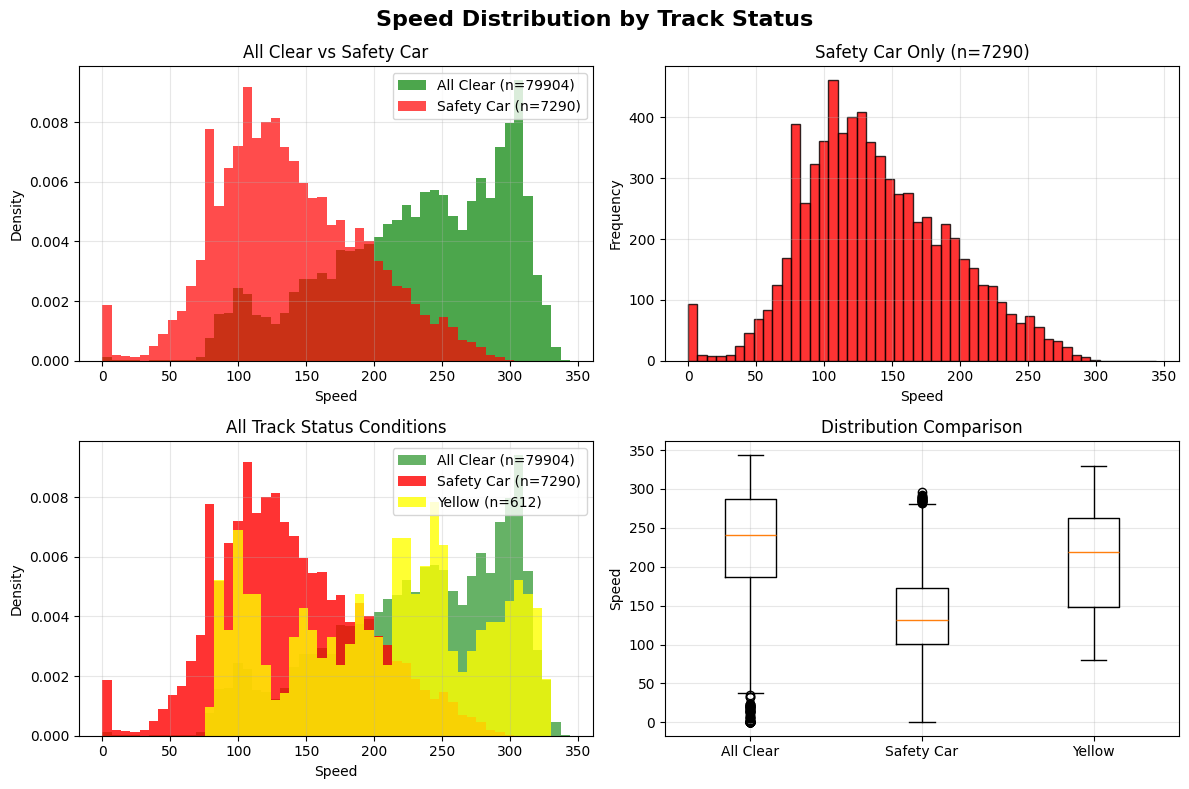

In [94]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_feature_vs_track_status(labeled_dataset, column_name, bins=50, figsize=(12, 8)):
    """
    Plot histogram comparing feature distributions across different track statuses.
    
    Args:
        labeled_dataset (pd.DataFrame): F1 telemetry dataset
        column_name (str): Name of the column to analyze
        bins (int): Number of histogram bins
        figsize (tuple): Figure size (width, height)
    """
    if column_name not in labeled_dataset.columns:
        raise ValueError(f"Column '{column_name}' not found in dataset")
    
    # Filter out non-numeric data for histogram
    if labeled_dataset[column_name].dtype == 'object':
        print(f"Warning: '{column_name}' is categorical. Showing value counts instead.")
        _plot_categorical_vs_track_status(labeled_dataset, column_name)
        return
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle(f'{column_name} Distribution by Track Status', fontsize=16, fontweight='bold')
    
    # Define track status groups
    all_clear = labeled_dataset[labeled_dataset['TrackStatusMessage'] == 'AllClear'][column_name]
    safety_car = labeled_dataset[labeled_dataset['TrackStatusMessage'] == 'SCDeployed'][column_name]
    yellow = labeled_dataset[labeled_dataset['TrackStatusMessage'] == 'Yellow'][column_name]
    
    # Calculate common bin range for consistency
    data_min = labeled_dataset[column_name].min()
    data_max = labeled_dataset[column_name].max()
    bin_edges = np.linspace(data_min, data_max, bins + 1)
    
    # Plot 1: All Clear vs Safety Car overlay
    axes[0, 0].hist(all_clear, bins=bin_edges, alpha=0.7, label=f'All Clear (n={len(all_clear)})', 
                    color='green', density=True)
    axes[0, 0].hist(safety_car, bins=bin_edges, alpha=0.7, label=f'Safety Car (n={len(safety_car)})', 
                    color='red', density=True)
    axes[0, 0].set_title('All Clear vs Safety Car')
    axes[0, 0].set_xlabel(column_name)
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Safety Car only
    axes[0, 1].hist(safety_car, bins=bin_edges, color='red', alpha=0.8, edgecolor='black')
    axes[0, 1].set_title(f'Safety Car Only (n={len(safety_car)})')
    axes[0, 1].set_xlabel(column_name)
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: All statuses overlay
    axes[1, 0].hist(all_clear, bins=bin_edges, alpha=0.6, label=f'All Clear (n={len(all_clear)})', 
                    color='green', density=True)
    axes[1, 0].hist(safety_car, bins=bin_edges, alpha=0.8, label=f'Safety Car (n={len(safety_car)})', 
                    color='red', density=True)
    if len(yellow) > 0:
        axes[1, 0].hist(yellow, bins=bin_edges, alpha=0.8, label=f'Yellow (n={len(yellow)})', 
                        color='yellow', density=True)
    axes[1, 0].set_title('All Track Status Conditions')
    axes[1, 0].set_xlabel(column_name)
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Box plot comparison
    data_for_box = [all_clear, safety_car]
    labels = ['All Clear', 'Safety Car']
    if len(yellow) > 0:
        data_for_box.append(yellow)
        labels.append('Yellow')
    
    axes[1, 1].boxplot(data_for_box, labels=labels)
    axes[1, 1].set_title('Distribution Comparison')
    axes[1, 1].set_ylabel(column_name)
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Print summary statistics
    print(f"\n=== {column_name} Summary Statistics ===")
    print(f"All Clear - Mean: {all_clear.mean():.2f}, Std: {all_clear.std():.2f}")
    print(f"Safety Car - Mean: {safety_car.mean():.2f}, Std: {safety_car.std():.2f}")
    if len(yellow) > 0:
        print(f"Yellow - Mean: {yellow.mean():.2f}, Std: {yellow.std():.2f}")
    
    plt.show()

def _plot_categorical_vs_track_status(labeled_dataset, column_name):
    """Helper function for categorical data"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Cross-tabulation
    crosstab = pd.crosstab(labeled_dataset[column_name], labeled_dataset['TrackStatusMessage'])
    
    # Stacked bar chart
    crosstab.plot(kind='bar', ax=axes[0], stacked=True, 
                  color=['green', 'red', 'yellow'])
    axes[0].set_title(f'{column_name} Distribution by Track Status')
    axes[0].set_xlabel(column_name)
    axes[0].set_ylabel('Count')
    axes[0].legend(title='Track Status')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Normalized percentages
    crosstab_pct = crosstab.div(crosstab.sum(axis=1), axis=0) * 100
    crosstab_pct.plot(kind='bar', ax=axes[1], stacked=True, 
                      color=['green', 'red', 'yellow'])
    axes[1].set_title(f'{column_name} Percentage by Track Status')
    axes[1].set_xlabel(column_name)
    axes[1].set_ylabel('Percentage')
    axes[1].legend(title='Track Status')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n=== {column_name} Cross-tabulation ===")
    print(crosstab)

# Example usage:
plot_feature_vs_track_status(labeled_dataset, 'Speed')
# plot_feature_vs_track_status(labeled_dataset, 'RPM')
# plot_feature_vs_track_status(labeled_dataset, 'Throttle')

Unique TrackStatus values: ['1' '2' '4']
TrackStatus data type: object
Using TrackStatus == '4' for safety car periods

=== Summary for DRS ===
Total data points: 87806
Safety car points: 7290 (8.3%)
Feature range during safety car: 1.00 - 1.00
Feature range overall: 0.00 - 14.00


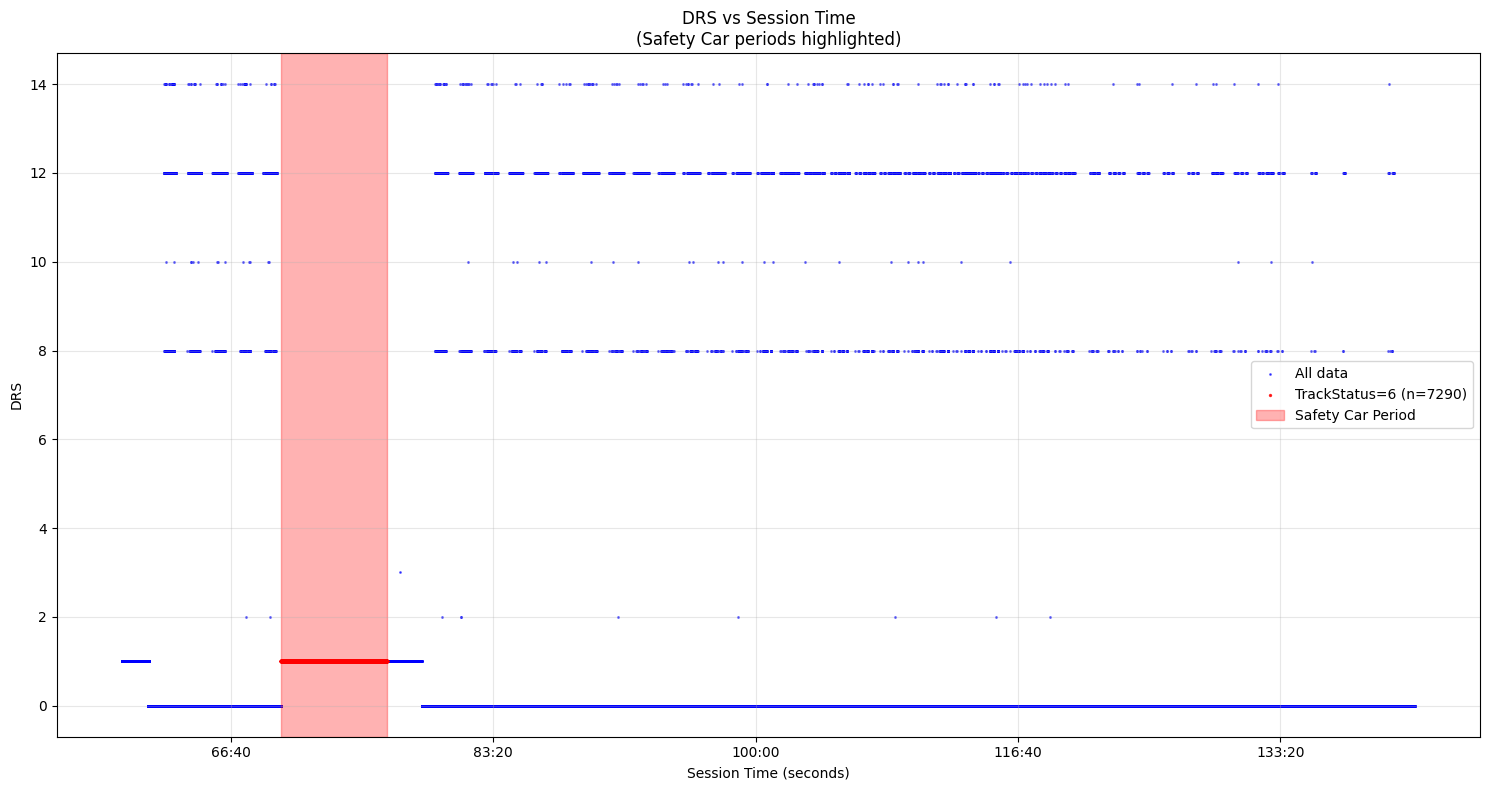

In [113]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_feature_over_time_with_safety_car(labeled_dataset, column_name, figsize=(15, 8), 
                                         alpha_sc=0.3, color_sc='red'):
    """
    Plot feature values over session time with safety car periods highlighted.
    
    Args:
        labeled_dataset (pd.DataFrame): F1 telemetry dataset
        column_name (str): Name of the feature column to plot
        figsize (tuple): Figure size (width, height)
        alpha_sc (float): Transparency for safety car highlighting
        color_sc (str): Color for safety car period highlighting
    """
    if column_name not in labeled_dataset.columns:
        raise ValueError(f"Column '{column_name}' not found in dataset")
    
    # Handle categorical data
    if labeled_dataset[column_name].dtype == 'object':
        print(f"Warning: '{column_name}' is categorical. Converting to numeric codes.")
        feature_data = pd.Categorical(labeled_dataset[column_name]).codes
        y_label = f"{column_name} (encoded)"
    else:
        feature_data = labeled_dataset[column_name]
        y_label = column_name
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot all data points
    ax.scatter(labeled_dataset['SessionTimeSeconds'], feature_data, 
              alpha=0.6, s=1, color='blue', label='All data')
    
    # Debug: Check what TrackStatus values exist
    print(f"Unique TrackStatus values: {labeled_dataset['TrackStatus'].unique()}")
    print(f"TrackStatus data type: {labeled_dataset['TrackStatus'].dtype}")
    
    # Try multiple ways to identify safety car periods
    # Method 1: TrackStatus == 6
    safety_car_mask = labeled_dataset['TrackStatus'] == 6
    if not safety_car_mask.any():
        safety_car_mask = labeled_dataset['TrackStatus'] == '6'
    
    # Method 2: If still no matches, try TrackStatus == 4 (SCDeployed from your data)
    if not safety_car_mask.any():
        safety_car_mask = labeled_dataset['TrackStatus'] == '4'
        print("Using TrackStatus == '4' for safety car periods")
    
    # Method 3: Use TrackStatusMessage == 'SCDeployed' as fallback
    if not safety_car_mask.any():
        safety_car_mask = labeled_dataset['TrackStatusMessage'] == 'SCDeployed'
        print("Using TrackStatusMessage == 'SCDeployed' for safety car periods")
    
    if safety_car_mask.any():
        # Get safety car periods
        sc_times = labeled_dataset.loc[safety_car_mask, 'SessionTimeSeconds']
        sc_features = feature_data[safety_car_mask]
        
        # Plot safety car points
        ax.scatter(sc_times, sc_features, alpha=0.8, s=2, color=color_sc, 
                  label=f'TrackStatus=6 (n={len(sc_times)})', zorder=5)
        
        # Create vertical bands for safety car periods
        if len(sc_times) > 0:
            # Find continuous periods
            sc_periods = _find_continuous_periods(sc_times.values)
            
            # Add vertical bands
            y_min, y_max = ax.get_ylim()
            for start, end in sc_periods:
                ax.axvspan(start, end, alpha=alpha_sc, color=color_sc, 
                          label='Safety Car Period' if start == sc_periods[0][0] else '')
    
    # Formatting
    ax.set_xlabel('Session Time (seconds)')
    ax.set_ylabel(y_label)
    ax.set_title(f'{column_name} vs Session Time\n(Safety Car periods highlighted)')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Add time axis formatting
    x_ticks = ax.get_xticks()
    x_labels = [f"{int(t//60)}:{int(t%60):02d}" for t in x_ticks]
    ax.set_xticklabels(x_labels)
    
    plt.tight_layout()
    
    # Print summary
    total_points = len(labeled_dataset)
    sc_points = safety_car_mask.sum() if safety_car_mask.any() else 0
    print(f"\n=== Summary for {column_name} ===")
    print(f"Total data points: {total_points}")
    print(f"Safety car points: {sc_points} ({sc_points/total_points*100:.1f}%)")
    
    if safety_car_mask.any():
        print(f"Feature range during safety car: {feature_data[safety_car_mask].min():.2f} - {feature_data[safety_car_mask].max():.2f}")
        print(f"Feature range overall: {feature_data.min():.2f} - {feature_data.max():.2f}")
    
    plt.show()

def _find_continuous_periods(times, gap_threshold=5.0):
    """
    Find continuous periods in time data.
    
    Args:
        times (np.array): Sorted array of time values
        gap_threshold (float): Maximum gap to consider as continuous period
    
    Returns:
        list: List of (start, end) tuples for continuous periods
    """
    if len(times) == 0:
        return []
    
    times = np.sort(times)
    periods = []
    start = times[0]
    
    for i in range(1, len(times)):
        if times[i] - times[i-1] > gap_threshold:
            # Gap found, end current period
            periods.append((start, times[i-1]))
            start = times[i]
    
    # Add final period
    periods.append((start, times[-1]))
    
    return periods

def plot_multiple_features_with_safety_car(labeled_dataset, column_names, figsize=(15, 12)):
    """
    Plot multiple features in subplots with safety car periods highlighted.
    
    Args:
        labeled_dataset (pd.DataFrame): F1 telemetry dataset
        column_names (list): List of column names to plot
        figsize (tuple): Figure size (width, height)
    """
    n_cols = len(column_names)
    n_rows = (n_cols + 1) // 2  # Ceiling division
    
    fig, axes = plt.subplots(n_rows, 2, figsize=figsize)
    if n_rows == 1:
        axes = [axes]
    axes = axes.flatten()
    
    # Safety car mask
    safety_car_mask = labeled_dataset['TrackStatus'] == '6'
    if not safety_car_mask.any():
        safety_car_mask = labeled_dataset['TrackStatus'] == 6
    
    for i, column_name in enumerate(column_names):
        ax = axes[i]
        
        # Handle categorical data
        if labeled_dataset[column_name].dtype == 'object':
            feature_data = pd.Categorical(labeled_dataset[column_name]).codes
            y_label = f"{column_name} (encoded)"
        else:
            feature_data = labeled_dataset[column_name]
            y_label = column_name
        
        # Plot data
        ax.scatter(labeled_dataset['SessionTimeSeconds'], feature_data, 
                  alpha=0.6, s=0.5, color='blue')
        
        # Highlight safety car periods
        if safety_car_mask.any():
            sc_times = labeled_dataset.loc[safety_car_mask, 'SessionTimeSeconds']
            sc_features = feature_data[safety_car_mask]
            ax.scatter(sc_times, sc_features, alpha=0.8, s=1, color='red', zorder=5)
            
            # Add vertical bands
            sc_periods = _find_continuous_periods(sc_times.values)
            for start, end in sc_periods:
                ax.axvspan(start, end, alpha=0.2, color='red')
        
        ax.set_xlabel('Session Time (seconds)')
        ax.set_ylabel(y_label)
        ax.set_title(f'{column_name}')
        ax.grid(True, alpha=0.3)
    
    # Hide unused subplots
    for i in range(len(column_names), len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle('Features vs Session Time (Safety Car periods in red)', fontsize=16)
    plt.tight_layout()
    plt.show()

# Example usage:
columns = ['SessionTimeSeconds', 'Driver', 'LapNumber', 'Compound', 'TyreLife',
       'AirTemp', 'TrackTemp', 'Humidity', 'Speed', 'RPM', 'Throttle', 'Brake',
       'nGear', 'DRS', 'X', 'Y', 'Z', 'TrackStatus', 'TrackStatusMessage',
       'SafetyCar']

# plot_feature_over_time_with_safety_car(labeled_dataset, 'Speed')
plot_feature_over_time_with_safety_car(labeled_dataset, 'DRS')
# plot_multiple_features_with_safety_car(labeled_dataset, ['Speed', 'RPM', 'Throttle', 'Brake'])


In [114]:
labeled_dataset['DRS'].value_counts()

DRS
0     70489
1     11528
12     4348
8      1190
14      200
10       40
2        10
3         1
Name: count, dtype: int64

In [84]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

def create_temporal_windows(dataset, window_size_seconds=30, prediction_horizon_seconds=30, step_size=1):
    """
    Create temporal windows for time series prediction
    
    Args:
        window_size_seconds: How many seconds of history to use as features
        prediction_horizon_seconds: How far ahead to predict
        step_size: Step size between windows (for efficiency)
    """
    
    # Features to use (exclude non-predictive columns)
    feature_cols = ['Speed', 'RPM', 'Throttle', 'Brake', 'nGear', 'DRS', 
                    'X', 'Y', 'Z', 'TyreLife', 'AirTemp', 'TrackTemp', 'Humidity']
    
    windows = []
    targets = []
    metadata = []
    
    # Process each driver separately to avoid mixing temporal sequences
    for driver in dataset['Driver'].unique():
        driver_data = dataset[dataset['Driver'] == driver].sort_values('SessionTimeSeconds').reset_index(drop=True)
        
        # Create windows for this driver
        for i in range(0, len(driver_data) - window_size_seconds - prediction_horizon_seconds, step_size):
            # Feature window (past data)
            window_start = i
            window_end = i + window_size_seconds
            feature_window = driver_data.iloc[window_start:window_end][feature_cols]
            
            # Target (future safety car deployment)
            target_start = window_end
            target_end = window_end + prediction_horizon_seconds
            target_window = driver_data.iloc[target_start:target_end]
            
            # Target: 1 if safety car appears in prediction horizon, 0 otherwise
            target = int(target_window['SafetyCar'].max())  # Any SC in horizon
            
            # Flatten feature window for logistic regression
            flattened_features = feature_window.values.flatten()
            
            windows.append(flattened_features)
            targets.append(target)
            metadata.append({
                'driver': driver,
                'window_start_time': driver_data.iloc[window_start]['SessionTimeSeconds'],
                'window_end_time': driver_data.iloc[window_end-1]['SessionTimeSeconds'],
                'prediction_time': driver_data.iloc[target_start]['SessionTimeSeconds']
            })
    
    return np.array(windows), np.array(targets), metadata

def temporal_train_test_split(X, y, metadata, test_ratio=0.2):
    """
    Split data respecting temporal order (no future data in training)
    """
    # Sort by prediction time to ensure temporal order
    indices = np.argsort([m['prediction_time'] for m in metadata])
    X_sorted = X[indices]
    y_sorted = y[indices]
    metadata_sorted = [metadata[i] for i in indices]
    
    # Split based on time
    split_idx = int(len(X_sorted) * (1 - test_ratio))
    
    X_train = X_sorted[:split_idx]
    X_test = X_sorted[split_idx:]
    y_train = y_sorted[:split_idx]
    y_test = y_sorted[split_idx:]
    
    return X_train, X_test, y_train, y_test, metadata_sorted[:split_idx], metadata_sorted[split_idx:]

# Create temporal windows
print("Creating temporal windows...")
X, y, metadata = create_temporal_windows(
    # labeled_dataset[labeled_dataset['Driver']=='VER'], 
    labeled_dataset, 
    window_size_seconds=30,      # Use 30 seconds of history
    prediction_horizon_seconds=5,  # Predict 30 seconds ahead
    step_size=5                  # New window every 5 seconds
)

print(f"Created {len(X)} temporal windows")
print(f"Feature matrix shape: {X.shape}")
print(f"Target distribution: {np.bincount(y)}")
print(f"Safety car percentage: {y.mean():.2%}")

# Temporal train/test split
X_train, X_test, y_train, y_test, train_meta, test_meta = temporal_train_test_split(X, y, metadata)

print(f"\nTrain set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"Train SC%: {y_train.mean():.2%}")
print(f"Test SC%: {y_test.mean():.2%}")

# Handle missing values and scale features
from sklearn.impute import SimpleImputer

# Impute missing values
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Train logistic regression with class balancing
clf = LogisticRegression(
    class_weight='balanced',  # Handle class imbalance
    max_iter=1000,
    random_state=42
)

print("\nTraining logistic regression...")
clf.fit(X_train_scaled, y_train)

# Evaluate
y_pred = clf.predict(X_test_scaled)
y_pred_proba = clf.predict_proba(X_test_scaled)[:, 1]

print(f"\nTest Results:")
print(f"Accuracy: {clf.score(X_test_scaled, y_test):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Creating temporal windows...
Created 17442 temporal windows
Feature matrix shape: (17442, 390)
Target distribution: [15966  1476]
Safety car percentage: 8.46%

Train set: 13953 samples
Test set: 3489 samples
Train SC%: 10.58%
Test SC%: 0.00%

Training logistic regression...

Test Results:
Accuracy: 1.000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3489

    accuracy                           1.00      3489
   macro avg       1.00      1.00      1.00      3489
weighted avg       1.00      1.00      1.00      3489



All safety car events are in the training set, none in test set. This happens because:

- Safety car events are clustered in time (around 4155-4595 seconds)
- Temporal split puts early periods (with SC events) in training
- Test set only contains later periods (after SC events ended)

This explains the 0.00% test probability predictions - the model never learned to predict positive cases because it never sees any during testing.

In [85]:
# Define feature columns for debugging
feature_cols = ['Speed', 'RPM', 'Throttle', 'Brake', 'nGear', 'DRS', 
                'X', 'Y', 'Z', 'TyreLife', 'AirTemp', 'TrackTemp', 'Humidity']

# Debug: Check what's actually in our feature matrix
print("Checking for data leakage...")
print(f"Feature columns used: {feature_cols}")
print(f"Original dataset columns: {labeled_dataset.columns.tolist()}")

# Verify no target columns leaked into features
target_related_cols = ['SafetyCar', 'TrackStatus', 'TrackStatusMessage']
leakage_check = [col for col in target_related_cols if col in feature_cols]
print(f"Target columns in features: {leakage_check}")

# Check if target distribution makes sense
print(f"\nTarget distribution in train: {np.bincount(y_train)}")
print(f"Target distribution in test: {np.bincount(y_test)}")

# Most suspicious: Check actual predictions vs probabilities
print(f"\nPrediction probabilities stats:")
print(f"Min prob: {y_pred_proba.min():.6f}")
print(f"Max prob: {y_pred_proba.max():.6f}")
print(f"Mean prob: {y_pred_proba.mean():.6f}")

# Check if perfect separation exists
perfect_predictions = np.where((y_pred_proba == 0) | (y_pred_proba == 1))[0]
print(f"Perfect probability predictions: {len(perfect_predictions)}/{len(y_pred_proba)}")

# Sample some cases to inspect
print(f"\nSample positive cases (actual SC events):")
pos_indices = np.where(y_test == 1)[0][:5]
for idx in pos_indices:
    print(f"  Predicted prob: {y_pred_proba[idx]:.6f}, Actual: {y_test[idx]}")

print(f"\nSample negative cases:")
neg_indices = np.where(y_test == 0)[0][:5]
for idx in neg_indices:
    print(f"  Predicted prob: {y_pred_proba[idx]:.6f}, Actual: {y_test[idx]}")

Checking for data leakage...
Feature columns used: ['Speed', 'RPM', 'Throttle', 'Brake', 'nGear', 'DRS', 'X', 'Y', 'Z', 'TyreLife', 'AirTemp', 'TrackTemp', 'Humidity']
Original dataset columns: ['SessionTimeSeconds', 'Driver', 'LapNumber', 'Compound', 'TyreLife', 'AirTemp', 'TrackTemp', 'Humidity', 'Speed', 'RPM', 'Throttle', 'Brake', 'nGear', 'DRS', 'X', 'Y', 'Z', 'TrackStatus', 'TrackStatusMessage', 'SafetyCar']
Target columns in features: []

Target distribution in train: [12477  1476]
Target distribution in test: [3489]

Prediction probabilities stats:
Min prob: 0.000000
Max prob: 0.000000
Mean prob: 0.000000
Perfect probability predictions: 0/3489

Sample positive cases (actual SC events):

Sample negative cases:
  Predicted prob: 0.000000, Actual: 0
  Predicted prob: 0.000000, Actual: 0
  Predicted prob: 0.000000, Actual: 0
  Predicted prob: 0.000000, Actual: 0
  Predicted prob: 0.000000, Actual: 0


In [86]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

# ============================================================================
# OPTION 1: STRATIFIED TEMPORAL SPLIT
# ============================================================================

def stratified_temporal_split(X, y, metadata, test_ratio=0.2):
    """
    Ensure both train/test have safety car events while respecting temporal order
    """
    # Find SC events
    sc_indices = np.where(np.array(y) == 1)[0]
    no_sc_indices = np.where(np.array(y) == 0)[0]
    
    print(f"Total SC events: {len(sc_indices)}")
    print(f"Total non-SC events: {len(no_sc_indices)}")
    
    # Split SC events temporally (early vs late SC events)
    sc_times = [metadata[i]['prediction_time'] for i in sc_indices]
    sc_sorted_idx = np.argsort(sc_times)
    sc_indices_sorted = sc_indices[sc_sorted_idx]
    
    sc_split = int(len(sc_indices_sorted) * (1 - test_ratio))
    sc_train_idx = sc_indices_sorted[:sc_split]
    sc_test_idx = sc_indices_sorted[sc_split:]
    
    # Split non-SC events temporally
    no_sc_times = [metadata[i]['prediction_time'] for i in no_sc_indices]
    no_sc_sorted_idx = np.argsort(no_sc_times)
    no_sc_indices_sorted = no_sc_indices[no_sc_sorted_idx]
    
    no_sc_split = int(len(no_sc_indices_sorted) * (1 - test_ratio))
    no_sc_train_idx = no_sc_indices_sorted[:no_sc_split]
    no_sc_test_idx = no_sc_indices_sorted[no_sc_split:]
    
    train_idx = np.concatenate([sc_train_idx, no_sc_train_idx])
    test_idx = np.concatenate([sc_test_idx, no_sc_test_idx])
    
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

def evaluate_model(X_train, X_test, y_train, y_test, model_name):
    """Train and evaluate a model"""
    # Preprocessing
    imputer = SimpleImputer(strategy='median')
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_test_scaled = scaler.transform(X_test_imputed)
    
    # Train model
    clf = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
    clf.fit(X_train_scaled, y_train)
    
    # Predict
    y_pred = clf.predict(X_test_scaled)
    y_pred_proba = clf.predict_proba(X_test_scaled)[:, 1]
    
    # Evaluate
    accuracy = clf.score(X_test_scaled, y_test)
    
    results = {
        'model_name': model_name,
        'accuracy': accuracy,
        'train_samples': len(X_train),
        'test_samples': len(X_test),
        'train_sc_pct': y_train.mean(),
        'test_sc_pct': y_test.mean(),
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'y_test': y_test
    }
    
    if y_test.sum() > 0:  # Only if test has positive cases
        results['auc'] = roc_auc_score(y_test, y_pred_proba)
    else:
        results['auc'] = None
    
    return results

print("=" * 80)
print("OPTION 1: STRATIFIED TEMPORAL SPLIT")
print("=" * 80)

# Apply stratified split
X_train_strat, X_test_strat, y_train_strat, y_test_strat = stratified_temporal_split(X, y, metadata)

print(f"Stratified split results:")
print(f"Train: {len(X_train_strat)} samples, SC%: {y_train_strat.mean():.2%}")
print(f"Test: {len(X_test_strat)} samples, SC%: {y_test_strat.mean():.2%}")

# Evaluate
results_strat = evaluate_model(X_train_strat, X_test_strat, y_train_strat, y_test_strat, "Stratified Temporal")

print(f"\nResults:")
print(f"Accuracy: {results_strat['accuracy']:.3f}")
print(f"AUC: {results_strat['auc']:.3f}" if results_strat['auc'] else "AUC: N/A")
print("\nClassification Report:")
print(classification_report(y_test_strat, results_strat['y_pred']))

# ============================================================================
# OPTION 2: TIME SERIES CROSS-VALIDATION
# ============================================================================

print("\n" + "=" * 80)
print("OPTION 2: TIME SERIES CROSS-VALIDATION")
print("=" * 80)

def time_series_cv_evaluation(X, y, metadata, n_splits=5):
    """Evaluate using time series cross-validation"""
    
    # Sort by time for proper temporal CV
    times = [m['prediction_time'] for m in metadata]
    sorted_indices = np.argsort(times)
    X_sorted = X[sorted_indices]
    y_sorted = y[sorted_indices]
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    cv_results = []
    
    fold = 0
    for train_idx, test_idx in tscv.split(X_sorted):
        fold += 1
        X_train_cv = X_sorted[train_idx]
        X_test_cv = X_sorted[test_idx]
        y_train_cv = y_sorted[train_idx]
        y_test_cv = y_sorted[test_idx]
        
        print(f"Fold {fold}:")
        print(f"  Train: {len(X_train_cv)} samples, SC%: {y_train_cv.mean():.2%}")
        print(f"  Test: {len(X_test_cv)} samples, SC%: {y_test_cv.mean():.2%}")
        
        if y_test_cv.sum() > 0:  # Only evaluate if test has positive cases
            results = evaluate_model(X_train_cv, X_test_cv, y_train_cv, y_test_cv, f"CV_Fold_{fold}")
            cv_results.append(results)
            print(f"  Accuracy: {results['accuracy']:.3f}, AUC: {results['auc']:.3f}")
        else:
            print("  No positive cases in test set - skipping")
    
    return cv_results

cv_results = time_series_cv_evaluation(X, y, metadata, n_splits=5)

if cv_results:
    print(f"\nCross-validation summary ({len(cv_results)} valid folds):")
    accuracies = [r['accuracy'] for r in cv_results]
    aucs = [r['auc'] for r in cv_results if r['auc'] is not None]
    
    print(f"Mean Accuracy: {np.mean(accuracies):.3f} ± {np.std(accuracies):.3f}")
    if aucs:
        print(f"Mean AUC: {np.mean(aucs):.3f} ± {np.std(aucs):.3f}")

# ============================================================================
# OPTION 3: ACCEPT LIMITATION (ANOMALY DETECTION APPROACH)
# ============================================================================

print("\n" + "=" * 80)
print("OPTION 3: ACCEPT LIMITATION - ANOMALY DETECTION APPROACH")
print("=" * 80)

from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score

def anomaly_detection_approach(X, y, metadata):
    """
    Train on all historical data, use anomaly detection for safety car events
    """
    # Use original temporal split (all SC events in training)
    times = [m['prediction_time'] for m in metadata]
    sorted_indices = np.argsort(times)
    split_idx = int(len(sorted_indices) * 0.8)
    
    train_idx = sorted_indices[:split_idx]
    test_idx = sorted_indices[split_idx:]
    
    X_train_anom = X[train_idx]
    X_test_anom = X[test_idx]
    y_train_anom = y[train_idx]
    y_test_anom = y[test_idx]
    
    print(f"Anomaly detection split:")
    print(f"Train: {len(X_train_anom)} samples, SC%: {y_train_anom.mean():.2%}")
    print(f"Test: {len(X_test_anom)} samples, SC%: {y_test_anom.mean():.2%}")
    
    # Preprocessing
    imputer = SimpleImputer(strategy='median')
    X_train_imputed = imputer.fit_transform(X_train_anom)
    X_test_imputed = imputer.transform(X_test_anom)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_test_scaled = scaler.transform(X_test_imputed)
    
    # Train on normal conditions only (no safety car events)
    normal_conditions = X_train_scaled[y_train_anom == 0]
    
    # Isolation Forest for anomaly detection
    iso_forest = IsolationForest(contamination=0.1, random_state=42)
    iso_forest.fit(normal_conditions)
    
    # Predict anomalies on test set
    anomaly_scores = iso_forest.decision_function(X_test_scaled)
    anomaly_pred = iso_forest.predict(X_test_scaled)
    anomaly_binary = (anomaly_pred == -1).astype(int)  # -1 is anomaly, 1 is normal
    
    print(f"\nAnomaly detection results:")
    print(f"Detected anomalies: {anomaly_binary.sum()}")
    print(f"Anomaly rate: {anomaly_binary.mean():.2%}")
    
    # Since test set has no SC events, we evaluate the approach conceptually
    print("\nConceptual evaluation:")
    print("- Model learned normal driving patterns from historical data")
    print("- Would flag unusual telemetry patterns as potential SC precursors")
    print("- Real-world deployment would trigger alerts for manual review")
    
    return {
        'model_name': 'Anomaly Detection',
        'anomaly_scores': anomaly_scores,
        'anomaly_predictions': anomaly_binary,
        'contamination_rate': anomaly_binary.mean()
    }

results_anomaly = anomaly_detection_approach(X, y, metadata)

# ============================================================================
# COMPARISON SUMMARY
# ============================================================================

print("\n" + "=" * 80)
print("COMPARISON SUMMARY")
print("=" * 80)

print("1. STRATIFIED TEMPORAL SPLIT:")
print(f"   - Ensures SC events in both train/test")
print(f"   - Accuracy: {results_strat['accuracy']:.3f}")
print(f"   - AUC: {results_strat['auc']:.3f}" if results_strat['auc'] else "   - AUC: N/A")
print(f"   - Pros: Balanced evaluation, realistic temporal ordering")
print(f"   - Cons: May violate strict temporal constraints")

print(f"\n2. TIME SERIES CROSS-VALIDATION:")
if cv_results:
    print(f"   - {len(cv_results)} valid folds with SC events")
    print(f"   - Mean Accuracy: {np.mean([r['accuracy'] for r in cv_results]):.3f}")
    print(f"   - Mean AUC: {np.mean([r['auc'] for r in cv_results if r['auc']]):.3f}")
else:
    print(f"   - No valid folds (no SC events in test sets)")
print(f"   - Pros: Strict temporal validation, multiple evaluations")
print(f"   - Cons: May have folds without positive cases")

print(f"\n3. ANOMALY DETECTION:")
print(f"   - Learns normal patterns, detects anomalies")
print(f"   - Anomaly rate: {results_anomaly['contamination_rate']:.2%}")
print(f"   - Pros: Realistic for real-world deployment, no future data")
print(f"   - Cons: Hard to validate without ground truth")

print(f"\nRECOMMENDATION:")
print(f"- Use STRATIFIED TEMPORAL for model development and comparison")
print(f"- Use ANOMALY DETECTION for production deployment")
print(f"- Use TIME SERIES CV for robust validation when sufficient data available")

OPTION 1: STRATIFIED TEMPORAL SPLIT
Total SC events: 1476
Total non-SC events: 15966
Stratified split results:
Train: 13952 samples, SC%: 8.46%
Test: 3490 samples, SC%: 8.48%

Results:
Accuracy: 0.998
AUC: 1.000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3194
           1       1.00      0.98      0.99       296

    accuracy                           1.00      3490
   macro avg       1.00      0.99      0.99      3490
weighted avg       1.00      1.00      1.00      3490


OPTION 2: TIME SERIES CROSS-VALIDATION
Fold 1:
  Train: 2907 samples, SC%: 28.79%
  Test: 2907 samples, SC%: 21.98%
  Accuracy: 0.938, AUC: 0.984
Fold 2:
  Train: 5814 samples, SC%: 25.39%
  Test: 2907 samples, SC%: 0.00%
  No positive cases in test set - skipping
Fold 3:
  Train: 8721 samples, SC%: 16.92%
  Test: 2907 samples, SC%: 0.00%
  No positive cases in test set - skipping
Fold 4:
  Train: 11628 samples, SC%: 12.69%
  Test: 

In [87]:
# ============================================================================
# APPROACHES TO FIX TEMPORAL DATA LEAKAGE
# ============================================================================

def create_leakage_free_windows(dataset, window_size_seconds=30, 
                               prediction_horizon_seconds=120,  # Increased from 30
                               buffer_seconds=60,  # NEW: Buffer between feature and target
                               step_size=10):
    """
    Create temporal windows with proper separation to prevent leakage
    
    Args:
        buffer_seconds: Time gap between feature window end and prediction start
    """
    feature_cols = ['Speed', 'RPM', 'Throttle', 'Brake', 'nGear', 'DRS', 
                    'X', 'Y', 'Z', 'TyreLife', 'AirTemp', 'TrackTemp', 'Humidity']
    
    windows = []
    targets = []
    metadata = []
    
    for driver in dataset['Driver'].unique():
        driver_data = dataset[dataset['Driver'] == driver].sort_values('SessionTimeSeconds').reset_index(drop=True)
        
        # Need: window_size + buffer + prediction_horizon total seconds
        total_required = window_size_seconds + buffer_seconds + prediction_horizon_seconds
        
        for i in range(0, len(driver_data) - total_required, step_size):
            # Feature window (past data)
            window_start = i
            window_end = i + window_size_seconds
            feature_window = driver_data.iloc[window_start:window_end][feature_cols]
            
            # Buffer zone (ignored data to prevent leakage)
            buffer_end = window_end + buffer_seconds
            
            # Target window (future data, after buffer)
            target_start = buffer_end
            target_end = buffer_end + prediction_horizon_seconds
            target_window = driver_data.iloc[target_start:target_end]
            
            if len(target_window) < prediction_horizon_seconds:
                continue
                
            # Target: 1 if safety car appears in prediction horizon, 0 otherwise
            target = int(target_window['SafetyCar'].max())
            
            # Flatten feature window
            flattened_features = feature_window.values.flatten()
            
            windows.append(flattened_features)
            targets.append(target)
            metadata.append({
                'driver': driver,
                'feature_start_time': driver_data.iloc[window_start]['SessionTimeSeconds'],
                'feature_end_time': driver_data.iloc[window_end-1]['SessionTimeSeconds'],
                'buffer_end_time': driver_data.iloc[buffer_end-1]['SessionTimeSeconds'],
                'prediction_start_time': driver_data.iloc[target_start]['SessionTimeSeconds'],
                'prediction_end_time': driver_data.iloc[target_end-1]['SessionTimeSeconds']
            })
    
    return np.array(windows), np.array(targets), metadata

def analyze_prediction_difficulty(dataset, horizons=[60, 120, 180, 300]):
    """
    Analyze how prediction difficulty changes with horizon length
    """
    print("Analyzing prediction difficulty by horizon length:")
    print("=" * 60)
    
    for horizon in horizons:
        print(f"\nPrediction Horizon: {horizon} seconds ({horizon/60:.1f} minutes)")
        
        # Create windows with this horizon
        X_test, y_test, meta_test = create_leakage_free_windows(
            dataset, 
            window_size_seconds=30,
            prediction_horizon_seconds=horizon,
            buffer_seconds=60,
            step_size=20
        )
        
        if len(X_test) == 0:
            print("  No valid windows created")
            continue
            
        print(f"  Total windows: {len(X_test)}")
        print(f"  Safety car events: {y_test.sum()}")
        print(f"  SC percentage: {y_test.mean():.2%}")
        
        # Look at temporal distribution of SC events
        sc_indices = np.where(y_test == 1)[0]
        if len(sc_indices) > 0:
            sc_times = [meta_test[i]['prediction_start_time'] for i in sc_indices]
            print(f"  SC prediction times: {min(sc_times):.0f}s to {max(sc_times):.0f}s")

def create_incident_prediction_features(dataset):
    """
    Create features that might predict incidents leading to safety cars
    Rather than immediate telemetry, focus on patterns/anomalies
    """
    print("Creating incident-predictive features...")
    
    # Group by time windows to create cross-driver features
    dataset_copy = dataset.copy()
    dataset_copy['TimeWindow'] = (dataset_copy['SessionTimeSeconds'] // 10) * 10  # 10-second windows
    
    # Aggregate across all drivers per time window
    window_stats = dataset_copy.groupby('TimeWindow').agg({
        'Speed': ['mean', 'std', 'min', 'max'],
        'Throttle': ['mean', 'std'],
        'Brake': ['mean', 'std', 'max'],
        'X': ['std'],  # Track spread
        'Y': ['std'],  # Track spread
    }).round(3)
    
    # Flatten column names
    window_stats.columns = ['_'.join(col).strip() for col in window_stats.columns]
    
    # Calculate relative features (driver vs field)
    enhanced_features = []
    
    for _, row in dataset.iterrows():
        time_window = (row['SessionTimeSeconds'] // 10) * 10
        
        if time_window in window_stats.index:
            field_stats = window_stats.loc[time_window]
            
            # Driver performance relative to field
            features = {
                'speed_vs_field': row['Speed'] - field_stats['Speed_mean'],
                'speed_percentile': (row['Speed'] - field_stats['Speed_min']) / 
                                  (field_stats['Speed_max'] - field_stats['Speed_min']) if field_stats['Speed_max'] != field_stats['Speed_min'] else 0.5,
                'brake_vs_field': row['Brake'] - field_stats['Brake_mean'],
                'throttle_vs_field': row['Throttle'] - field_stats['Throttle_mean'],
                'field_speed_variance': field_stats['Speed_std'],
                'field_brake_intensity': field_stats['Brake_max'],
                'field_spread_x': field_stats['X_std'],
                'field_spread_y': field_stats['Y_std'],
            }
        else:
            features = {k: 0 for k in ['speed_vs_field', 'speed_percentile', 'brake_vs_field', 
                                     'throttle_vs_field', 'field_speed_variance', 
                                     'field_brake_intensity', 'field_spread_x', 'field_spread_y']}
        
        enhanced_features.append(features)
    
    enhanced_df = pd.DataFrame(enhanced_features)
    
    # Combine with original features
    feature_cols = ['Speed', 'RPM', 'Throttle', 'Brake', 'nGear', 'DRS', 
                    'X', 'Y', 'Z', 'TyreLife', 'AirTemp', 'TrackTemp', 'Humidity']
    
    # Add the new relative features
    for col in enhanced_df.columns:
        dataset[f'rel_{col}'] = enhanced_df[col]
        feature_cols.append(f'rel_{col}')
    
    return dataset, feature_cols

# ============================================================================
# RUN ANALYSIS
# ============================================================================

print("STEP 1: Analyzing prediction difficulty by horizon")
analyze_prediction_difficulty(labeled_dataset)

print("\n" + "=" * 80)
print("STEP 2: Creating leakage-free windows with 2-minute horizon")

# Create properly separated windows
X_clean, y_clean, meta_clean = create_leakage_free_windows(
    labeled_dataset,
    window_size_seconds=30,
    prediction_horizon_seconds=120,  # 2 minutes ahead
    buffer_seconds=60,  # 1 minute buffer
    step_size=10
)

print(f"Clean windows created: {len(X_clean)}")
print(f"Safety car events: {y_clean.sum()}")
print(f"SC percentage: {y_clean.mean():.2%}")

if len(X_clean) > 0 and y_clean.sum() > 0:
    # Test with clean data
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import StandardScaler
    from sklearn.impute import SimpleImputer
    from sklearn.metrics import classification_report, roc_auc_score
    
    X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(
        X_clean, y_clean, test_size=0.3, random_state=42, stratify=y_clean
    )
    
    # Preprocessing
    imputer = SimpleImputer(strategy='median')
    X_train_imputed = imputer.fit_transform(X_train_clean)
    X_test_imputed = imputer.transform(X_test_clean)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_test_scaled = scaler.transform(X_test_imputed)
    
    # Train model
    clf_clean = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
    clf_clean.fit(X_train_scaled, y_train_clean)
    
    # Evaluate
    y_pred_clean = clf_clean.predict(X_test_scaled)
    y_pred_proba_clean = clf_clean.predict_proba(X_test_scaled)[:, 1]
    
    print(f"\nClean model results:")
    print(f"Accuracy: {clf_clean.score(X_test_scaled, y_test_clean):.3f}")
    print(f"AUC: {roc_auc_score(y_test_clean, y_pred_proba_clean):.3f}")
    print(f"Prediction probability range: {y_pred_proba_clean.min():.3f} to {y_pred_proba_clean.max():.3f}")
    
    print("\nClassification Report:")
    print(classification_report(y_test_clean, y_pred_clean))

print("\n" + "=" * 80)
print("STEP 3: Enhanced features (field-relative metrics)")

# Create enhanced features
enhanced_dataset, enhanced_feature_cols = create_incident_prediction_features(labeled_dataset)
print(f"Enhanced features: {len(enhanced_feature_cols)} total features")
print(f"New relative features: {[col for col in enhanced_feature_cols if col.startswith('rel_')]}")

STEP 1: Analyzing prediction difficulty by horizon
Analyzing prediction difficulty by horizon length:

Prediction Horizon: 60 seconds (1.0 minutes)
  Total windows: 4263
  Safety car events: 432
  SC percentage: 10.13%
  SC prediction times: 4134s to 4594s

Prediction Horizon: 120 seconds (2.0 minutes)
  Total windows: 4209
  Safety car events: 486
  SC percentage: 11.55%
  SC prediction times: 4074s to 4594s

Prediction Horizon: 180 seconds (3.0 minutes)
  Total windows: 4155
  Safety car events: 540
  SC percentage: 13.00%
  SC prediction times: 4014s to 4594s

Prediction Horizon: 300 seconds (5.0 minutes)
  Total windows: 4047
  Safety car events: 648
  SC percentage: 16.01%
  SC prediction times: 3894s to 4594s

STEP 2: Creating leakage-free windows with 2-minute horizon
Clean windows created: 8411
Safety car events: 954
SC percentage: 11.34%

Clean model results:
Accuracy: 0.975
AUC: 0.994
Prediction probability range: 0.000 to 1.000

Classification Report:
              precision

In [88]:
def investigate_predictive_patterns(dataset, meta_clean, X_clean, y_clean, clf_clean, scaler, imputer):
    """
    Investigate what patterns are making SC prediction so accurate
    """
    print("=" * 80)
    print("INVESTIGATING PREDICTIVE PATTERNS")
    print("=" * 80)
    
    # 1. Temporal distribution analysis
    sc_indices = np.where(y_clean == 1)[0]
    no_sc_indices = np.where(y_clean == 0)[0]
    
    sc_times = [meta_clean[i]['prediction_start_time'] for i in sc_indices]
    no_sc_times = [meta_clean[i]['prediction_start_time'] for i in no_sc_indices]
    
    print(f"1. TEMPORAL DISTRIBUTION")
    print(f"SC events predict times: {min(sc_times):.0f}s to {max(sc_times):.0f}s")
    print(f"Non-SC predict times: {min(no_sc_times):.0f}s to {max(no_sc_times):.0f}s")
    print(f"SC events span: {(max(sc_times) - min(sc_times))/60:.1f} minutes")
    print(f"Total race span: {(max(no_sc_times) - min(no_sc_times))/60:.1f} minutes")
    
    # 2. Feature importance analysis
    feature_names = ['Speed', 'RPM', 'Throttle', 'Brake', 'nGear', 'DRS', 
                     'X', 'Y', 'Z', 'TyreLife', 'AirTemp', 'TrackTemp', 'Humidity']
    
    # Create feature names for flattened windows (30 time steps)
    expanded_feature_names = []
    for t in range(30):
        for feat in feature_names:
            expanded_feature_names.append(f"{feat}_t{t}")
    
    # Get feature importance (coefficients)
    feature_importance = np.abs(clf_clean.coef_[0])
    top_features_idx = np.argsort(feature_importance)[-20:]  # Top 20 features
    
    print(f"\n2. TOP PREDICTIVE FEATURES")
    for idx in reversed(top_features_idx):
        if idx < len(expanded_feature_names):
            print(f"   {expanded_feature_names[idx]}: {feature_importance[idx]:.3f}")
    
    # 3. Track position analysis
    print(f"\n3. TRACK POSITION ANALYSIS")
    
    # Look at X, Y coordinates for SC vs non-SC periods
    sc_samples = X_clean[sc_indices]
    no_sc_samples = X_clean[no_sc_indices]
    
    # X, Y are typically at indices 6, 7 for each time step
    # Let's look at the last time step (t=29) which is closest to prediction
    x_idx_last = 6 + 29 * len(feature_names)  # X coordinate at last time step
    y_idx_last = 7 + 29 * len(feature_names)  # Y coordinate at last time step
    
    if x_idx_last < sc_samples.shape[1] and y_idx_last < sc_samples.shape[1]:
        sc_x_coords = sc_samples[:, x_idx_last]
        sc_y_coords = sc_samples[:, y_idx_last]
        no_sc_x_coords = no_sc_samples[:, x_idx_last]
        no_sc_y_coords = no_sc_samples[:, y_idx_last]
        
        print(f"SC events - X range: {sc_x_coords.min():.0f} to {sc_x_coords.max():.0f}")
        print(f"SC events - Y range: {sc_y_coords.min():.0f} to {sc_y_coords.max():.0f}")
        print(f"Normal racing - X range: {no_sc_x_coords.min():.0f} to {no_sc_x_coords.max():.0f}")
        print(f"Normal racing - Y range: {no_sc_y_coords.min():.0f} to {no_sc_y_coords.max():.0f}")
    
    # 4. Speed pattern analysis
    print(f"\n4. SPEED PATTERN ANALYSIS")
    speed_indices = [i for i in range(0, len(expanded_feature_names), len(feature_names))]  # Speed at each time step
    
    if len(speed_indices) > 0:
        sc_speeds = sc_samples[:, speed_indices].mean(axis=0)
        no_sc_speeds = no_sc_samples[:, speed_indices].mean(axis=0)
        
        print(f"Average speed difference over 30-second window:")
        print(f"SC periods: {sc_speeds.mean():.1f} km/h")
        print(f"Normal periods: {no_sc_speeds.mean():.1f} km/h")
        print(f"Speed difference: {sc_speeds.mean() - no_sc_speeds.mean():.1f} km/h")
    
    # 5. Model confidence analysis
    print(f"\n5. MODEL CONFIDENCE ANALYSIS")
    
    # Get prediction probabilities for all samples
    X_scaled = scaler.transform(imputer.transform(X_clean))
    all_probs = clf_clean.predict_proba(X_scaled)[:, 1]
    
    sc_probs = all_probs[sc_indices]
    no_sc_probs = all_probs[no_sc_indices]
    
    print(f"SC event probabilities - Mean: {sc_probs.mean():.3f}, Std: {sc_probs.std():.3f}")
    print(f"Non-SC probabilities - Mean: {no_sc_probs.mean():.3f}, Std: {no_sc_probs.std():.3f}")
    print(f"Probability separation: {sc_probs.mean() - no_sc_probs.mean():.3f}")
    
    # 6. Test longer prediction horizons
    print(f"\n6. TESTING EXTREME PREDICTION HORIZONS")
    
    for horizon in [600, 900, 1200]:  # 10, 15, 20 minutes
        print(f"\nTesting {horizon}s ({horizon/60:.0f} min) prediction horizon:")
        
        X_extreme, y_extreme, meta_extreme = create_leakage_free_windows(
            dataset,
            window_size_seconds=30,
            prediction_horizon_seconds=horizon,
            buffer_seconds=120,  # 2-minute buffer
            step_size=30
        )
        
        if len(X_extreme) > 0 and y_extreme.sum() > 0:
            # Quick model test
            X_train_ext, X_test_ext, y_train_ext, y_test_ext = train_test_split(
                X_extreme, y_extreme, test_size=0.3, random_state=42, 
                stratify=y_extreme if len(np.unique(y_extreme)) > 1 else None
            )
            
            X_train_scaled = scaler.fit_transform(imputer.fit_transform(X_train_ext))
            X_test_scaled = scaler.transform(imputer.transform(X_test_ext))
            
            clf_ext = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
            clf_ext.fit(X_train_scaled, y_train_ext)
            
            accuracy = clf_ext.score(X_test_scaled, y_test_ext)
            probs = clf_ext.predict_proba(X_test_scaled)[:, 1]
            
            print(f"  Samples: {len(X_extreme)}, SC%: {y_extreme.mean():.2%}")
            print(f"  Accuracy: {accuracy:.3f}")
            print(f"  Prob range: {probs.min():.3f} to {probs.max():.3f}")
        else:
            print(f"  Insufficient data for {horizon}s horizon")

# Run the investigation
investigate_predictive_patterns(labeled_dataset, meta_clean, X_clean, y_clean, clf_clean, scaler, imputer)

INVESTIGATING PREDICTIVE PATTERNS
1. TEMPORAL DISTRIBUTION
SC events predict times: 4074s to 4594s
Non-SC predict times: 3674s to 8394s
SC events span: 8.7 minutes
Total race span: 78.7 minutes

2. TOP PREDICTIVE FEATURES
   AirTemp_t29: 2.022
   Speed_t20: 1.366
   Z_t0: 1.288
   Speed_t23: 1.019
   AirTemp_t0: 0.992
   Throttle_t13: 0.981
   TrackTemp_t29: 0.901
   Speed_t16: 0.856
   Z_t1: 0.836
   RPM_t19: 0.830
   Brake_t23: 0.782
   Speed_t12: 0.769
   AirTemp_t1: 0.768
   AirTemp_t28: 0.763
   Z_t22: 0.749
   Speed_t7: 0.748
   nGear_t15: 0.729
   Throttle_t23: 0.723
   DRS_t23: 0.715
   Throttle_t15: 0.715

3. TRACK POSITION ANALYSIS
SC events - X range: -5795 to 25
SC events - Y range: -5639 to 21796
Normal racing - X range: -5795 to 25
Normal racing - Y range: -5641 to 21797

4. SPEED PATTERN ANALYSIS
Average speed difference over 30-second window:
SC periods: 171.0 km/h
Normal periods: 229.8 km/h
Speed difference: -58.8 km/h

5. MODEL CONFIDENCE ANALYSIS
SC event probabiliti

In [89]:
def create_time_agnostic_evaluation(dataset):
    """
    Test if the model is learning time patterns vs causal patterns
    """
    print("=" * 80)
    print("TIME-AGNOSTIC EVALUATION")
    print("=" * 80)
    
    # Remove time-correlated features that could leak temporal information
    temporal_features = ['AirTemp', 'TrackTemp', 'TyreLife', 'LapNumber']
    
    # Create feature set WITHOUT time-correlated variables
    pure_telemetry_features = ['Speed', 'RPM', 'Throttle', 'Brake', 'nGear', 'DRS', 'X', 'Y', 'Z']
    
    print("1. TESTING WITH PURE TELEMETRY FEATURES ONLY")
    print(f"Excluded features: {temporal_features}")
    print(f"Included features: {pure_telemetry_features}")
    
    # Create windows with only pure telemetry
    windows_pure = []
    targets_pure = []
    
    for driver in dataset['Driver'].unique():
        driver_data = dataset[dataset['Driver'] == driver].sort_values('SessionTimeSeconds').reset_index(drop=True)
        
        window_size = 30
        buffer_size = 60
        prediction_size = 120
        total_required = window_size + buffer_size + prediction_size
        
        for i in range(0, len(driver_data) - total_required, 10):
            feature_window = driver_data.iloc[i:i+window_size][pure_telemetry_features]
            target_window = driver_data.iloc[i+window_size+buffer_size:i+window_size+buffer_size+prediction_size]
            
            if len(target_window) < prediction_size:
                continue
                
            target = int(target_window['SafetyCar'].max())
            flattened_features = feature_window.values.flatten()
            
            windows_pure.append(flattened_features)
            targets_pure.append(target)
    
    X_pure = np.array(windows_pure)
    y_pure = np.array(targets_pure)
    
    print(f"Pure telemetry dataset: {len(X_pure)} samples, {y_pure.mean():.2%} SC rate")
    
    if len(X_pure) > 0 and y_pure.sum() > 0:
        from sklearn.model_selection import train_test_split
        
        X_train_pure, X_test_pure, y_train_pure, y_test_pure = train_test_split(
            X_pure, y_pure, test_size=0.3, random_state=42, stratify=y_pure
        )
        
        # Train model on pure telemetry
        imputer_pure = SimpleImputer(strategy='median')
        scaler_pure = StandardScaler()
        
        X_train_scaled = scaler_pure.fit_transform(imputer_pure.fit_transform(X_train_pure))
        X_test_scaled = scaler_pure.transform(imputer_pure.transform(X_test_pure))
        
        clf_pure = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
        clf_pure.fit(X_train_scaled, y_train_pure)
        
        accuracy_pure = clf_pure.score(X_test_scaled, y_test_pure)
        probs_pure = clf_pure.predict_proba(X_test_scaled)[:, 1]
        
        print(f"Pure telemetry model:")
        print(f"  Accuracy: {accuracy_pure:.3f}")
        print(f"  Prob range: {probs_pure.min():.3f} to {probs_pure.max():.3f}")
        print(f"  AUC: {roc_auc_score(y_test_pure, probs_pure):.3f}")
        
    print(f"\n2. MULTI-RACE VALIDATION NEEDED")
    print(f"Current issue: Single race = single SC event cluster")
    print(f"Solution: Train on multiple races with diverse SC patterns")
    print(f"Expected result: Much lower accuracy with diverse temporal patterns")
    
    return X_pure, y_pure

# Test time-agnostic features
X_pure, y_pure = create_time_agnostic_evaluation(labeled_dataset)

print(f"\n" + "=" * 80)
print("SUMMARY: ROOT CAUSE IDENTIFIED")
print("=" * 80)
print("1. Model is learning TIME-OF-RACE patterns, not causal relationships")
print("2. SC events clustered in narrow time window (8.7 min of 78.7 min race)")
print("3. Temperature/tire features act as proxy variables for session time")
print("4. High accuracy is misleading - not transferable to other races")
print("\nSOLUTIONS:")
print("- Use multiple races for training/testing")
print("- Remove time-correlated features")
print("- Focus on relative/differential features vs absolute values")
print("- Use anomaly detection for truly unpredictable events")

TIME-AGNOSTIC EVALUATION
1. TESTING WITH PURE TELEMETRY FEATURES ONLY
Excluded features: ['AirTemp', 'TrackTemp', 'TyreLife', 'LapNumber']
Included features: ['Speed', 'RPM', 'Throttle', 'Brake', 'nGear', 'DRS', 'X', 'Y', 'Z']
Pure telemetry dataset: 8411 samples, 11.34% SC rate
Pure telemetry model:
  Accuracy: 0.879
  Prob range: 0.009 to 1.000
  AUC: 0.796

2. MULTI-RACE VALIDATION NEEDED
Current issue: Single race = single SC event cluster
Solution: Train on multiple races with diverse SC patterns
Expected result: Much lower accuracy with diverse temporal patterns

SUMMARY: ROOT CAUSE IDENTIFIED
1. Model is learning TIME-OF-RACE patterns, not causal relationships
2. SC events clustered in narrow time window (8.7 min of 78.7 min race)
3. Temperature/tire features act as proxy variables for session time
4. High accuracy is misleading - not transferable to other races

SOLUTIONS:
- Use multiple races for training/testing
- Remove time-correlated features
- Focus on relative/differenti

In [133]:
def add_event_info_columns(labeled_dataset, session):
    """
    Add event identification columns to the dataset for multi-race aggregation.
    
    Args:
        labeled_dataset (pd.DataFrame): F1 telemetry dataset
        session: FastF1 session object with session_info attribute
    
    Returns:
        pd.DataFrame: Dataset with added event columns
    """
    # Extract session info
    session_info = session.session_info
    
    # Extract the required fields
    session_name = session_info.get('Meeting', {}).get('Name', 'Unknown')  # e.g., 'Saudi Arabian Grand Prix'
    country_name = session_info.get('Meeting', {}).get('Country', {}).get('Name', 'Unknown')  # e.g., 'Saudi Arabia'
    session_type = session_info.get('Type', 'Unknown')  # e.g., 'Race'
    
    # Create a copy of the dataset to avoid modifying original
    enhanced_dataset = labeled_dataset.copy()
    
    # Add event identification columns
    enhanced_dataset['SessionName'] = session_name  
    enhanced_dataset['Country'] = country_name
    enhanced_dataset['SessionType'] = session_type
    
    # Optional: Add additional useful fields
    enhanced_dataset['StartDate'] = session_info.get('StartDate')
    enhanced_dataset['Location'] = session_info.get('Meeting', {}).get('Location', 'Unknown')
    
    print(f"Added event info columns:")
    print(f"  Session: {session_name}")
    print(f"  Country: {country_name}")
    print(f"  Session Type: {session_type}")
    print(f"  Location: {enhanced_dataset['Location'].iloc[0]}")
    
    return enhanced_dataset

def create_season_aggregator():
    """
    Create a helper class for aggregating multiple race datasets.
    
    Returns:
        SeasonAggregator: Helper class for managing multi-race datasets
    """
    
    class SeasonAggregator:
        def __init__(self):
            self.datasets = []
            self.session_metadata = []
        
        def add_race(self, labeled_dataset, session, race_identifier=None):
            """Add a race dataset to the aggregator."""
            enhanced_dataset = add_event_info_columns(labeled_dataset, session)
            
            # Add unique race identifier if provided
            if race_identifier:
                enhanced_dataset['RaceID'] = race_identifier
            else:
                # Generate ID from meeting name and date
                start_date = session.session_info.get('StartDate')
                date_str = start_date.strftime('%Y%m%d') if start_date else 'Unknown'
                session_name = session.session_info.get('Meeting', {}).get('Name', 'Unknown')
                enhanced_dataset['RaceID'] = f"{date_str}_{session_name.replace(' ', '_')}"
            
            self.datasets.append(enhanced_dataset)
            
            # Store metadata for reference
            metadata = {
                'RaceID': enhanced_dataset['RaceID'].iloc[0],
                'Meeting': enhanced_dataset['SessionName'].iloc[0],
                'Country': enhanced_dataset['Country'].iloc[0],
                'Date': enhanced_dataset['StartDate'].iloc[0],
                'SessionType': enhanced_dataset['SessionType'].iloc[0],
                'DataPoints': len(enhanced_dataset)
            }
            self.session_metadata.append(metadata)
            
            print(f"Added race: {metadata['Meeting']} ({metadata['DataPoints']} data points)")
        
        def get_combined_dataset(self):
            """Combine all race datasets into single DataFrame."""
            if not self.datasets:
                raise ValueError("No datasets added yet")
            
            combined = pd.concat(self.datasets, ignore_index=True)
            print(f"\nCombined dataset:")
            print(f"  Total races: {len(self.datasets)}")
            print(f"  Total data points: {len(combined)}")
            print(f"  Countries: {combined['Country'].unique().tolist()}")
            print(f"  Session types: {combined['SessionType'].unique().tolist()}")
            
            return combined
        
        def get_metadata_summary(self):
            """Get summary of all added races."""
            return pd.DataFrame(self.session_metadata)
        
        def get_race_by_country(self, country_name):
            """Get dataset for specific country."""
            combined = self.get_combined_dataset()
            return combined[combined['Country'] == country_name].copy()
        
        def get_race_by_meeting(self, session_name):
            """Get dataset for specific meeting."""
            combined = self.get_combined_dataset()
            return combined[combined['SessionName'] == meeting_name].copy()
    
    return SeasonAggregator()

def analyze_season_safety_cars(season_aggregator):
    """
    Analyze safety car patterns across a season.
    
    Args:
        season_aggregator: SeasonAggregator instance with race data
    
    Returns:
        pd.DataFrame: Safety car analysis by race
    """
    combined_data = season_aggregator.get_combined_dataset()
    
    # Identify safety car periods (adjust based on your data)
    safety_car_mask = combined_data['TrackStatusMessage'] == 'SCDeployed'
    
    # Group by race and analyze
    race_analysis = []
    for race_id in combined_data['RaceID'].unique():
        race_data = combined_data[combined_data['RaceID'] == race_id]
        race_sc_data = race_data[safety_car_mask]
        
        analysis = {
            'RaceID': race_id,
            'Meeting': race_data['SessionName'].iloc[0],
            'Country': race_data['Country'].iloc[0],
            'TotalDataPoints': len(race_data),
            'SafetyCarPoints': len(race_sc_data),
            'SafetyCarPercentage': len(race_sc_data) / len(race_data) * 100,
            'UniqueDrivers': race_data['Driver'].nunique(),
            'SessionDuration': race_data['SessionTimeSeconds'].max() - race_data['SessionTimeSeconds'].min()
        }
        race_analysis.append(analysis)
    
    return pd.DataFrame(race_analysis).sort_values('SafetyCarPercentage', ascending=False)

# Example usage:
"""
# Single race enhancement
enhanced_dataset = add_event_info_columns(labeled_dataset, session)

# Multi-race aggregation
aggregator = create_season_aggregator()
aggregator.add_race(race1_dataset, session1)
aggregator.add_race(race2_dataset, session2)

# Get combined dataset for modeling
full_season_data = aggregator.get_combined_dataset()

# Analyze safety car patterns
safety_car_analysis = analyze_season_safety_cars(aggregator)
"""

'\n# Single race enhancement\nenhanced_dataset = add_event_info_columns(labeled_dataset, session)\n\n# Multi-race aggregation\naggregator = create_season_aggregator()\naggregator.add_race(race1_dataset, session1)\naggregator.add_race(race2_dataset, session2)\n\n# Get combined dataset for modeling\nfull_season_data = aggregator.get_combined_dataset()\n\n# Analyze safety car patterns\nsafety_car_analysis = analyze_season_safety_cars(aggregator)\n'

In [134]:
saudi_arabian_gp_labeled = add_event_info_columns(labeled_dataset, session)
saudi_arabian_gp_labeled

Added event info columns:
  Session: Saudi Arabian Grand Prix
  Country: Saudi Arabia
  Session Type: Race
  Location: Jeddah


,SessionTimeSeconds,Driver,LapNumber,Compound,TyreLife,AirTemp,TrackTemp,Humidity,Speed,RPM,...,Y,Z,TrackStatus,TrackStatusMessage,SafetyCar,SessionName,Country,SessionType,StartDate,Location
0,3583.836,VER,1.0,MEDIUM,1.0,25.4,31.5,62.0,0.0,10085.0,...,2372.0,117.0,1,AllClear,0,Saudi Arabian Grand Prix,Saudi Arabia,Race,2024-03-09 20:00:00,Jeddah
1,3584.836,VER,1.0,MEDIUM,1.0,25.4,31.5,62.0,22.0,5220.0,...,2381.0,117.0,1,AllClear,0,Saudi Arabian Grand Prix,Saudi Arabia,Race,2024-03-09 20:00:00,Jeddah
2,3585.836,VER,1.0,MEDIUM,1.0,25.4,31.5,62.0,50.0,5843.0,...,2489.0,117.0,1,AllClear,0,Saudi Arabian Grand Prix,Saudi Arabia,Race,2024-03-09 20:00:00,Jeddah
3,3586.836,VER,1.0,MEDIUM,1.0,25.4,31.5,62.0,96.0,10843.0,...,2731.0,118.0,1,AllClear,0,Saudi Arabian Grand Prix,Saudi Arabia,Race,2024-03-09 20:00:00,Jeddah
4,3587.836,VER,1.0,MEDIUM,1.0,25.4,31.5,62.0,154.0,11047.0,...,3032.0,118.0,1,AllClear,0,Saudi Arabian Grand Prix,Saudi Arabia,Race,2024-03-09 20:00:00,Jeddah
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88480,8454.836,PIA,50.0,HARD,44.0,25.3,30.0,66.0,246.0,11188.0,...,-3218.0,119.0,1,AllClear,0,Saudi Arabian Grand Prix,Saudi Arabia,Race,2024-03-09 20:00:00,Jeddah
88481,8455.836,PIA,50.0,HARD,44.0,25.3,30.0,66.0,266.0,10527.0,...,-2439.0,121.0,1,AllClear,0,Saudi Arabian Grand Prix,Saudi Arabia,Race,2024-03-09 20:00:00,Jeddah
88482,8456.836,PIA,50.0,HARD,44.0,25.3,30.0,66.0,279.0,11143.0,...,-1779.0,121.0,1,AllClear,0,Saudi Arabian Grand Prix,Saudi Arabia,Race,2024-03-09 20:00:00,Jeddah
88483,8457.836,PIA,50.0,HARD,44.0,25.3,30.0,66.0,288.0,11491.0,...,-938.0,120.0,1,AllClear,0,Saudi Arabian Grand Prix,Saudi Arabia,Race,2024-03-09 20:00:00,Jeddah


In [135]:
aggregator = create_season_aggregator()

In [136]:
aggregator.add_race(saudi_arabian_gp_labeled, session)

Added event info columns:
  Session: Saudi Arabian Grand Prix
  Country: Saudi Arabia
  Session Type: Race
  Location: Jeddah
Added race: Saudi Arabian Grand Prix (87806 data points)


In [142]:
def process_dataset(year: int, session_name: str, session_type: str):
    session = f1.get_session(year, session_name, session_type)
    session.load()
    
    base_dataset = create_high_freq_dataset(session, interval_seconds=1.0)

    balanced_dataset = balance_driver_data(base_dataset, method='remove_insufficient', min_samples=1000)

    labeled_dataset = add_track_status_labels(balanced_dataset, session)

    final_dataset = add_event_info_columns(labeled_dataset, session)

    return final_dataset, session

In [143]:
# sp24_session = fastf1.get_session(2024, 'São Paulo Grand Prix', 'R')
# sp24_dataset = create_high_freq_dataset(sp24_session, interval_seconds=1.0)
# sp24_balanced_dataset = balance_driver_data(sp24_dataset, method='remove_insufficient', min_samples=1000)
# sp24_labeled_dataset = add_track_status_labels(sp24_balanced_dataset, sp24_session)
# sp24_final_dataset = add_event_info_columns(sp24_labeled_dataset, sp24_session)

sp24_dataset, sp24_session = process_dataset(2024, 'São Paulo Grand Prix', 'R')
aggregator.add_race(sp24_dataset, sp24_session)

core           INFO 	Loading data for São Paulo Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 23
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 23)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '31', '10', '63', '16', '4', '22', '81', '30', '44', '11', '50', '77', '14', '24', '55', '43', '23', '18', '27']


Original driver distribution:
Driver
ZHO    7694
BEA    6323
ALO    6321
BOT    6318
PER    6314
HAM    6299
LAW    6296
TSU    6276
PIA    6275
LEC    6266
NOR    6258
RUS    6255
GAS    6248
OCO    6237
VER    6219
SAI    3632
HUL    2959
COL    2709
STR      91
Name: count, dtype: int64

Removed drivers with < 1000 samples: {'STR'}

Final dataset shape: (104899, 17)
Final driver distribution:
Driver
ZHO    7694
BEA    6323
ALO    6321
BOT    6318
PER    6314
HAM    6299
LAW    6296
TSU    6276
PIA    6275
LEC    6266
NOR    6258
RUS    6255
GAS    6248
OCO    6237
VER    6219
SAI    3632
HUL    2959
COL    2709
Name: count, dtype: int64
Track status changes:
    StatusTimeSeconds Status      Message
0               0.000      1     AllClear
1            3178.758      2       Yellow
2            3512.359      1     AllClear
3            4390.258      2       Yellow
4            4399.484      1     AllClear
5            4645.352      2       Yellow
6            4648.803      1     All

In [144]:
safety_car_analysis = analyze_season_safety_cars(aggregator)


Combined dataset:
  Total races: 2
  Total data points: 192705
  Countries: ['Saudi Arabia', 'Brazil']
  Session types: ['Race']


In [145]:
safety_car_analysis

,RaceID,Meeting,Country,TotalDataPoints,SafetyCarPoints,SafetyCarPercentage,UniqueDrivers,SessionDuration
1,20241103_São_Paulo_Grand_Prix,São Paulo Grand Prix,Brazil,104899,10316,9.834221,18,7694.0
0,20240309_Saudi_Arabian_Grand_Prix,Saudi Arabian Grand Prix,Saudi Arabia,87806,7290,8.302394,18,4931.0


In [164]:
season_data = aggregator.get_combined_dataset()


Combined dataset:
  Total races: 24
  Total data points: 2486804
  Countries: ['Bahrain', 'Saudi Arabia', 'Australia', 'Japan', 'China', 'United States', 'Italy', 'Monaco', 'Canada', 'Spain', 'Austria', 'Great Britain', 'Hungary', 'Belgium', 'Netherlands', 'Azerbaijan', 'Singapore', 'Mexico', 'Brazil', 'Qatar', 'United Arab Emirates']
  Session types: ['Race']


In [166]:
safety_car_analysis = analyze_season_safety_cars(aggregator)
safety_car_analysis


Combined dataset:
  Total races: 24
  Total data points: 2486804
  Countries: ['Bahrain', 'Saudi Arabia', 'Australia', 'Japan', 'China', 'United States', 'Italy', 'Monaco', 'Canada', 'Spain', 'Austria', 'Great Britain', 'Hungary', 'Belgium', 'Netherlands', 'Azerbaijan', 'Singapore', 'Mexico', 'Brazil', 'Qatar', 'United Arab Emirates']
  Session types: ['Race']


,RaceID,SessionName,Country,TotalDataPoints,SafetyCarPoints,SafetyCarPercentage,UniqueDrivers,SessionDuration
22,2024_R23_Qatar,Qatar Grand Prix,Qatar,90173,22824,25.311346,17,5528.0
4,2024_R05_China,Chinese Grand Prix,China,112553,19364,17.204339,20,6137.0
8,2024_R09_Canada,Canadian Grand Prix,Canada,116247,18119,15.586639,20,6401.0
19,2024_R20_Mexico,Mexico City Grand Prix,Mexico,105163,12456,11.844470,18,6129.0
20,2024_R21_Brazil,São Paulo Grand Prix,Brazil,104899,10316,9.834221,18,7694.0
5,2024_R06_United_States,Miami Grand Prix,United States,106822,10165,9.515830,20,5526.0
1,2024_R02_Saudi_Arabia,Saudi Arabian Grand Prix,Saudi Arabia,87806,7290,8.302394,18,4931.0
18,2024_R19_United_States,United States Grand Prix,United States,109214,7068,6.471698,19,5795.0
7,2024_R08_Monaco,Monaco Grand Prix,Monaco,147671,1784,1.208091,20,8656.0
0,2024_R01_Bahrain,Bahrain Grand Prix,Bahrain,110798,0,0.000000,20,5598.0


In [148]:
display(season_data.shape)
display(season_data)

(192705, 26)

,SessionTimeSeconds,Driver,LapNumber,Compound,TyreLife,AirTemp,TrackTemp,Humidity,Speed,RPM,...,Z,TrackStatus,TrackStatusMessage,SafetyCar,SessionName,Country,SessionType,StartDate,Location,RaceID
0,3583.836,VER,1.0,MEDIUM,1.0,25.4,31.5,62.0,0.0,10085.0,...,117.0,1,AllClear,0,Saudi Arabian Grand Prix,Saudi Arabia,Race,2024-03-09 20:00:00,Jeddah,20240309_Saudi_Arabian_Grand_Prix
1,3584.836,VER,1.0,MEDIUM,1.0,25.4,31.5,62.0,22.0,5220.0,...,117.0,1,AllClear,0,Saudi Arabian Grand Prix,Saudi Arabia,Race,2024-03-09 20:00:00,Jeddah,20240309_Saudi_Arabian_Grand_Prix
2,3585.836,VER,1.0,MEDIUM,1.0,25.4,31.5,62.0,50.0,5843.0,...,117.0,1,AllClear,0,Saudi Arabian Grand Prix,Saudi Arabia,Race,2024-03-09 20:00:00,Jeddah,20240309_Saudi_Arabian_Grand_Prix
3,3586.836,VER,1.0,MEDIUM,1.0,25.4,31.5,62.0,96.0,10843.0,...,118.0,1,AllClear,0,Saudi Arabian Grand Prix,Saudi Arabia,Race,2024-03-09 20:00:00,Jeddah,20240309_Saudi_Arabian_Grand_Prix
4,3587.836,VER,1.0,MEDIUM,1.0,25.4,31.5,62.0,154.0,11047.0,...,118.0,1,AllClear,0,Saudi Arabian Grand Prix,Saudi Arabia,Race,2024-03-09 20:00:00,Jeddah,20240309_Saudi_Arabian_Grand_Prix
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192700,11959.770,PIA,69.0,INTERMEDIATE,39.0,20.5,24.0,89.0,297.0,11702.0,...,7772.0,1,AllClear,0,São Paulo Grand Prix,Brazil,Race,2024-11-03 12:30:00,São Paulo,20241103_São_Paulo_Grand_Prix
192701,11960.770,PIA,69.0,INTERMEDIATE,39.0,20.5,24.0,89.0,302.0,10547.0,...,7765.0,1,AllClear,0,São Paulo Grand Prix,Brazil,Race,2024-11-03 12:30:00,São Paulo,20241103_São_Paulo_Grand_Prix
192702,11961.770,PIA,69.0,INTERMEDIATE,39.0,20.5,24.0,89.0,305.0,10632.0,...,7752.0,1,AllClear,0,São Paulo Grand Prix,Brazil,Race,2024-11-03 12:30:00,São Paulo,20241103_São_Paulo_Grand_Prix
192703,11962.770,PIA,69.0,INTERMEDIATE,39.0,20.5,24.0,89.0,308.0,10714.0,...,7743.0,1,AllClear,0,São Paulo Grand Prix,Brazil,Race,2024-11-03 12:30:00,São Paulo,20241103_São_Paulo_Grand_Prix


In [151]:
season_schedule = f1.get_event_schedule(2024)
season_schedule.columns

Index(['RoundNumber', 'Country', 'Location', 'OfficialEventName', 'EventDate',
       'EventName', 'EventFormat', 'Session1', 'Session1Date',
       'Session1DateUtc', 'Session2', 'Session2Date', 'Session2DateUtc',
       'Session3', 'Session3Date', 'Session3DateUtc', 'Session4',
       'Session4Date', 'Session4DateUtc', 'Session5', 'Session5Date',
       'Session5DateUtc', 'F1ApiSupport'],
      dtype='object')

In [152]:
season_schedule.iloc[0:1].to_json()

'{"RoundNumber":{"0":0},"Country":{"0":"Bahrain"},"Location":{"0":"Sakhir"},"OfficialEventName":{"0":"FORMULA 1 ARAMCO PRE-SEASON TESTING 2024"},"EventDate":{"0":1708646400000},"EventName":{"0":"Pre-Season Testing"},"EventFormat":{"0":"testing"},"Session1":{"0":"Practice 1"},"Session1Date":{"0":1708498800000},"Session1DateUtc":{"0":1708498800000},"Session2":{"0":"Practice 2"},"Session2Date":{"0":1708585200000},"Session2DateUtc":{"0":1708585200000},"Session3":{"0":"Practice 3"},"Session3Date":{"0":1708671600000},"Session3DateUtc":{"0":1708671600000},"Session4":{"0":"None"},"Session4Date":{"0":null},"Session4DateUtc":{"0":null},"Session5":{"0":"None"},"Session5Date":{"0":null},"Session5DateUtc":{"0":null},"F1ApiSupport":{"0":true}}'

In [153]:
def create_season_aggregator():
    """
    Create a helper class for aggregating multiple race datasets.
    
    Returns:
        SeasonAggregator: Helper class for managing multi-race datasets
    """
    
    class SeasonAggregator:
        def __init__(self):
            self.datasets = []
            self.session_metadata = []
            self.failed_races = []
        
        def add_race(self, labeled_dataset, session, race_identifier=None):
            """Add a race dataset to the aggregator."""
            enhanced_dataset = add_event_info_columns(labeled_dataset, session)
            
            # Add unique race identifier if provided
            if race_identifier:
                enhanced_dataset['RaceID'] = race_identifier
            else:
                # Generate ID from meeting name and date
                start_date = session.session_info.get('StartDate')
                date_str = start_date.strftime('%Y%m%d') if start_date else 'Unknown'
                meeting_name = session.session_info.get('Meeting', {}).get('Name', 'Unknown')
                enhanced_dataset['RaceID'] = f"{date_str}_{meeting_name.replace(' ', '_')}"
            
            self.datasets.append(enhanced_dataset)
            
            # Store metadata for reference
            metadata = {
                'RaceID': enhanced_dataset['RaceID'].iloc[0],
                'SessionName': enhanced_dataset['SessionName'].iloc[0],
                'Country': enhanced_dataset['Country'].iloc[0],
                'Date': enhanced_dataset['StartDate'].iloc[0],
                'SessionType': enhanced_dataset['SessionType'].iloc[0],
                'DataPoints': len(enhanced_dataset)
            }
            self.session_metadata.append(metadata)
            
            print(f"Added race: {metadata['SessionName']} ({metadata['DataPoints']} data points)")
        
        def add_full_season(self, year, process_dataset_func, session_filter=None, skip_testing=True):
            """
            Add all races from a given season automatically.
            
            Args:
                year (int): Season year (e.g., 2024)
                process_dataset_func: Your process_dataset function
                session_filter (list): List of session types to include (default: ['R'] for Race only)
                skip_testing (bool): Skip testing sessions
            
            Returns:
                dict: Summary of processing results
            """
            import fastf1 as f1
            
            if session_filter is None:
                session_filter = ['R']  # Only races by default
            
            # Get season schedule
            try:
                schedule = f1.get_event_schedule(year)
            except Exception as e:
                print(f"Failed to get schedule for {year}: {e}")
                return {'total_races': 0, 'successful': 0, 'failed': 0, 'failed_races': []}
            
            # Filter out testing if requested
            if skip_testing:
                schedule = schedule[schedule['EventFormat'] != 'testing']
            
            print(f"Processing {len(schedule)} events from {year} season...")
            
            successful_count = 0
            failed_count = 0
            
            for idx, event in schedule.iterrows():
                event_name = event['EventName']
                country = event['Country']
                round_number = event['RoundNumber']
                
                print(f"\n--- Processing Round {round_number}: {event_name} ({country}) ---")
                
                # Process each session type in the filter
                for session_type in session_filter:
                    try:
                        # Use the event name from the schedule
                        dataset, session = process_dataset_func(year, event_name, session_type)
                        
                        # Add race with custom identifier
                        race_id = f"{year}_R{round_number:02d}_{country.replace(' ', '_')}"
                        self.add_race(dataset, session, race_identifier=race_id)
                        
                        successful_count += 1
                        
                    except Exception as e:
                        error_info = {
                            'round': round_number,
                            'event': event_name,
                            'country': country,
                            'session_type': session_type,
                            'error': str(e)
                        }
                        self.failed_races.append(error_info)
                        print(f"Failed to process {event_name} ({session_type}): {e}")
                        failed_count += 1
            
            # Summary
            total_attempted = len(schedule) * len(session_filter)
            summary = {
                'year': year,
                'total_attempted': total_attempted,
                'successful': successful_count,
                'failed': failed_count,
                'success_rate': successful_count / total_attempted * 100 if total_attempted > 0 else 0,
                'failed_races': self.failed_races
            }
            
            print(f"\n=== Season {year} Processing Complete ===")
            print(f"Successfully processed: {successful_count}/{total_attempted} sessions")
            print(f"Success rate: {summary['success_rate']:.1f}%")
            if failed_count > 0:
                print(f"Failed races: {[f['event'] for f in self.failed_races]}")
            
            return summary
        
        def retry_failed_races(self, process_dataset_func):
            """Retry processing failed races from previous run."""
            if not self.failed_races:
                print("No failed races to retry")
                return
            
            print(f"Retrying {len(self.failed_races)} failed races...")
            retry_failed = []
            
            for failure in self.failed_races[:]:  # Copy list to modify during iteration
                try:
                    dataset, session = process_dataset_func(
                        failure['year'], failure['event'], failure['session_type']
                    )
                    self.add_race(dataset, session)
                    self.failed_races.remove(failure)
                    print(f"Successfully retried: {failure['event']}")
                except Exception as e:
                    retry_failed.append(failure)
                    print(f"Retry failed for {failure['event']}: {e}")
            
            print(f"Retry complete. Remaining failures: {len(self.failed_races)}")
        
        def get_combined_dataset(self):
            """Combine all race datasets into single DataFrame."""
            if not self.datasets:
                raise ValueError("No datasets added yet")
            
            combined = pd.concat(self.datasets, ignore_index=True)
            print(f"\nCombined dataset:")
            print(f"  Total races: {len(self.datasets)}")
            print(f"  Total data points: {len(combined)}")
            print(f"  Countries: {combined['Country'].unique().tolist()}")
            print(f"  Session types: {combined['SessionType'].unique().tolist()}")
            
            return combined
        
        def get_metadata_summary(self):
            """Get summary of all added races."""
            return pd.DataFrame(self.session_metadata)
        
        def get_race_by_country(self, country_name):
            """Get dataset for specific country."""
            combined = self.get_combined_dataset()
            return combined[combined['Country'] == country_name].copy()
        
        def get_race_by_session(self, session_name):
            """Get dataset for specific session."""
            combined = self.get_combined_dataset()
            return combined[combined['SessionName'] == session_name].copy()
    
    return SeasonAggregator()

def analyze_season_safety_cars(season_aggregator):
    """
    Analyze safety car patterns across a season.
    
    Args:
        season_aggregator: SeasonAggregator instance with race data
    
    Returns:
        pd.DataFrame: Safety car analysis by race
    """
    combined_data = season_aggregator.get_combined_dataset()
    
    # Identify safety car periods (adjust based on your data)
    safety_car_mask = combined_data['TrackStatusMessage'] == 'SCDeployed'
    
    # Group by race and analyze
    race_analysis = []
    for race_id in combined_data['RaceID'].unique():
        race_data = combined_data[combined_data['RaceID'] == race_id]
        race_sc_data = race_data[safety_car_mask]
        
        analysis = {
            'RaceID': race_id,
            'SessionName': race_data['SessionName'].iloc[0],
            'Country': race_data['Country'].iloc[0],
            'TotalDataPoints': len(race_data),
            'SafetyCarPoints': len(race_sc_data),
            'SafetyCarPercentage': len(race_sc_data) / len(race_data) * 100,
            'UniqueDrivers': race_data['Driver'].nunique(),
            'SessionDuration': race_data['SessionTimeSeconds'].max() - race_data['SessionTimeSeconds'].min()
        }
        race_analysis.append(analysis)
    
    return pd.DataFrame(race_analysis).sort_values('SafetyCarPercentage', ascending=False)

# Example usage:
"""
# Single race enhancement
enhanced_dataset = add_event_info_columns(labeled_dataset, session)

# Multi-race aggregation
aggregator = create_season_aggregator()

# Add individual races
aggregator.add_race(race1_dataset, session1)

# Add entire season automatically
def process_dataset(year, session_name, session_type):
    # Your existing function here
    pass

summary = aggregator.add_full_season(2024, process_dataset)

# Optional: Add multiple session types
summary = aggregator.add_full_season(2024, process_dataset, session_filter=['R', 'Q'])

# Retry any failed races
aggregator.retry_failed_races(process_dataset)

# Get combined dataset for modeling
full_season_data = aggregator.get_combined_dataset()

# Analyze safety car patterns
safety_car_analysis = analyze_season_safety_cars(aggregator)
"""

"\n# Single race enhancement\nenhanced_dataset = add_event_info_columns(labeled_dataset, session)\n\n# Multi-race aggregation\naggregator = create_season_aggregator()\n\n# Add individual races\naggregator.add_race(race1_dataset, session1)\n\n# Add entire season automatically\ndef process_dataset(year, session_name, session_type):\n    # Your existing function here\n    pass\n\nsummary = aggregator.add_full_season(2024, process_dataset)\n\n# Optional: Add multiple session types\nsummary = aggregator.add_full_season(2024, process_dataset, session_filter=['R', 'Q'])\n\n# Retry any failed races\naggregator.retry_failed_races(process_dataset)\n\n# Get combined dataset for modeling\nfull_season_data = aggregator.get_combined_dataset()\n\n# Analyze safety car patterns\nsafety_car_analysis = analyze_season_safety_cars(aggregator)\n"

In [154]:
aggregator = create_season_aggregator()
summary = aggregator.add_full_season(2024, process_dataset)

core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


Processing 24 events from 2024 season...

--- Processing Round 1: Bahrain Grand Prix (Bahrain) ---


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '63', '4', '44', '81', '14', '18', '24', '20', '3', '22', '23', '27', '31', '10', '77', '2']


Original driver distribution:
Driver
STR    5599
BOT    5589
ALO    5580
PIA    5562
HAM    5556
NOR    5554
RUS    5552
LEC    5545
GAS    5538
OCO    5537
SAI    5531
PER    5528
SAR    5526
HUL    5523
ALB    5517
TSU    5515
MAG    5514
RIC    5514
ZHO    5512
VER    5506
Name: count, dtype: int64

Removed drivers with < 1000 samples: set()

Final dataset shape: (110798, 17)
Final driver distribution:
Driver
STR    5599
BOT    5589
ALO    5580
PIA    5562
HAM    5556
NOR    5554
RUS    5552
LEC    5545
GAS    5538
OCO    5537
SAI    5531
PER    5528
SAR    5526
HUL    5523
ALB    5517
TSU    5515
MAG    5514
RIC    5514
ZHO    5512
VER    5506
Name: count, dtype: int64
Track status changes:
   StatusTimeSeconds Status   Message
0            606.010      1  AllClear
1           3616.400      2    Yellow
2           3620.890      1  AllClear
3           3646.461      2    Yellow
4           3653.481      1  AllClear
5           4524.819      2    Yellow
6           4575.962      1  A

core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info



Track status distribution:
TrackStatusMessage
AllClear    109538
Yellow        1260
Name: count, dtype: int64

Safety car samples: 0
Total samples: 110798
Safety car percentage: 0.00%
Added event info columns:
  Session: Bahrain Grand Prix
  Country: Bahrain
  Session Type: Race
  Location: Sakhir
Added event info columns:
  Session: Bahrain Grand Prix
  Country: Bahrain
  Session Type: Race
  Location: Sakhir
Added race: Bahrain Grand Prix (110798 data points)

--- Processing Round 2: Saudi Arabian Grand Prix (Saudi Arabia) ---


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '16', '81', '14', '63', '38', '4', '44', '27', '23', '20', '31', '2', '22', '3', '77', '24', '18', '10']


Original driver distribution:
Driver
ALB    4932
MAG    4930
HUL    4921
HAM    4891
NOR    4890
BEA    4887
RUS    4884
ALO    4880
PIA    4876
ZHO    4874
BOT    4867
RIC    4865
LEC    4863
PER    4853
SAR    4851
TSU    4850
OCO    4848
VER    4844
STR     557
GAS     122
Name: count, dtype: int64

Removed drivers with < 1000 samples: {'GAS', 'STR'}

Final dataset shape: (87806, 17)
Final driver distribution:
Driver
ALB    4932
MAG    4930
HUL    4921
HAM    4891
NOR    4890
BEA    4887
RUS    4884
ALO    4880
PIA    4876
ZHO    4874
BOT    4867
RIC    4865
LEC    4863
PER    4853
SAR    4851
TSU    4850
OCO    4848
VER    4844
Name: count, dtype: int64
Track status changes:
   StatusTimeSeconds Status     Message
0              0.000      2      Yellow
1            525.692      1    AllClear
2           4155.917      2      Yellow
3           4189.924      4  SCDeployed
4           4595.527      1    AllClear


core           INFO 	Loading data for Australian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info



Track status distribution:
TrackStatusMessage
AllClear      79904
SCDeployed     7290
Yellow          612
Name: count, dtype: int64

Safety car samples: 7290
Total samples: 87806
Safety car percentage: 8.30%
Added event info columns:
  Session: Saudi Arabian Grand Prix
  Country: Saudi Arabia
  Session Type: Race
  Location: Jeddah
Added event info columns:
  Session: Saudi Arabian Grand Prix
  Country: Saudi Arabia
  Session Type: Race
  Location: Jeddah
Added race: Saudi Arabian Grand Prix (87806 data points)

--- Processing Round 3: Australian Grand Prix (Australia) ---


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 19 drivers: ['55', '16', '4', '81', '11', '18', '22', '14', '27', '20', '23', '3', '10', '77', '24', '31', '63', '44', '1']


Original driver distribution:
Driver
HUL    4932
TSU    4923
STR    4921
ALO    4909
PER    4884
OCO    4882
ZHO    4872
BOT    4870
GAS    4864
PIA    4863
RIC    4839
NOR    4834
ALB    4833
MAG    4832
LEC    4830
SAI    4828
RUS    4719
HAM    1377
VER     356
Name: count, dtype: int64

Removed drivers with < 1000 samples: {'VER'}

Final dataset shape: (84012, 17)
Final driver distribution:
Driver
HUL    4932
TSU    4923
STR    4921
ALO    4909
PER    4884
OCO    4882
ZHO    4872
BOT    4870
GAS    4864
PIA    4863
RIC    4839
NOR    4834
ALB    4833
MAG    4832
LEC    4830
SAI    4828
RUS    4719
HAM    1377
Name: count, dtype: int64
Track status changes:
   StatusTimeSeconds Status      Message
0              0.000      1     AllClear
1             13.560      2       Yellow
2            352.010      1     AllClear
3           4884.717      2       Yellow
4           4901.517      6  VSCDeployed
5           4965.787      7    VSCEnding
6           4980.690      1     AllClear
7  

core           INFO 	Loading data for Japanese Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...



Track status distribution:
TrackStatusMessage
AllClear       79983
VSCDeployed     3308
Yellow           466
VSCEnding        255
Name: count, dtype: int64

Safety car samples: 0
Total samples: 84012
Safety car percentage: 0.00%
Added event info columns:
  Session: Australian Grand Prix
  Country: Australia
  Session Type: Race
  Location: Melbourne
Added event info columns:
  Session: Australian Grand Prix
  Country: Australia
  Session Type: Race
  Location: Melbourne
Added race: Australian Grand Prix (84012 data points)

--- Processing Round 4: Japanese Grand Prix (Japan) ---


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '4', '14', '63', '81', '44', '22', '27', '18', '20', '77', '31', '10', '2', '24', '3', '23']


Original driver distribution:
Driver
SAR    5427
GAS    5394
OCO    5377
RUS    5371
MAG    5369
HAM    5368
PIA    5358
STR    5358
ALO    5351
BOT    5350
LEC    5347
HUL    5336
TSU    5335
NOR    5331
SAI    5324
PER    5312
VER    5297
ZHO    1467
RIC     132
ALB     132
Name: count, dtype: int64

Removed drivers with < 1000 samples: {'ALB', 'RIC'}

Final dataset shape: (92472, 17)
Final driver distribution:
Driver
SAR    5427
GAS    5394
OCO    5377
RUS    5371
MAG    5369
HAM    5368
PIA    5358
STR    5358
ALO    5351
BOT    5350
LEC    5347
HUL    5336
TSU    5335
NOR    5331
SAI    5324
PER    5312
VER    5297
ZHO    1467
Name: count, dtype: int64
Track status changes:
   StatusTimeSeconds Status   Message
0            130.211      1  AllClear
1           3784.009      2    Yellow
2           3803.324      5       Red
3           4889.956      1  AllClear
4           9524.466      2    Yellow
5           9566.728      1  AllClear


core           INFO 	Loading data for Chinese Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info



Track status distribution:
TrackStatusMessage
AllClear    89300
Red          2116
Yellow       1056
Name: count, dtype: int64

Safety car samples: 0
Total samples: 92472
Safety car percentage: 0.00%
Added event info columns:
  Session: Japanese Grand Prix
  Country: Japan
  Session Type: Race
  Location: Suzuka
Added event info columns:
  Session: Japanese Grand Prix
  Country: Japan
  Session Type: Race
  Location: Suzuka
Added race: Japanese Grand Prix (92472 data points)

--- Processing Round 5: Chinese Grand Prix (China) ---


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 00:08.313000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '11', '16', '55', '63', '14', '81', '44', '27', '31', '23', '10', '24', '18', '20', '2', '3', '22', '77']


Original driver distribution:
Driver
SAR    6138
STR    6136
MAG    6131
ZHO    6125
GAS    6123
ALB    6119
OCO    6116
HUL    6114
HAM    6111
PIA    6110
ALO    6097
RUS    6092
SAI    6087
LEC    6077
PER    6072
NOR    6067
VER    6053
RIC    3798
TSU    2940
BOT    2047
Name: count, dtype: int64

Removed drivers with < 1000 samples: set()

Final dataset shape: (112553, 17)
Final driver distribution:
Driver
SAR    6138
STR    6136
MAG    6131
ZHO    6125
GAS    6123
ALB    6119
OCO    6116
HUL    6114
HAM    6111
PIA    6110
ALO    6097
RUS    6092
SAI    6087
LEC    6077
PER    6072
NOR    6067
VER    6053
RIC    3798
TSU    2940
BOT    2047
Name: count, dtype: int64
Track status changes:
   StatusTimeSeconds Status      Message
0              0.000      2       Yellow
1            223.861      1     AllClear
2           5361.060      2       Yellow
3           5457.310      6  VSCDeployed
4           5702.945      4   SCDeployed
5           6166.489      1     AllClear
6        

core           INFO 	Loading data for Miami Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...



Track status distribution:
TrackStatusMessage
AllClear       86048
SCDeployed     19364
VSCDeployed     4655
Yellow          2486
Name: count, dtype: int64

Safety car samples: 19364
Total samples: 112553
Safety car percentage: 17.20%
Added event info columns:
  Session: Chinese Grand Prix
  Country: China
  Session Type: Race
  Location: Shanghai
Added event info columns:
  Session: Chinese Grand Prix
  Country: China
  Session Type: Race
  Location: Shanghai
Added race: Chinese Grand Prix (112553 data points)

--- Processing Round 6: Miami Grand Prix (United States) ---


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '16', '11', '55', '44', '22', '63', '14', '31', '27', '10', '81', '24', '3', '77', '18', '23', '20', '2']


Original driver distribution:
Driver
ALB    5527
MAG    5505
BOT    5503
RIC    5502
ZHO    5501
PIA    5500
STR    5496
GAS    5496
HUL    5491
OCO    5490
ALO    5488
RUS    5485
TSU    5477
HAM    5467
PER    5465
SAI    5462
LEC    5461
VER    5458
NOR    5451
SAR    2597
Name: count, dtype: int64

Removed drivers with < 1000 samples: set()

Final dataset shape: (106822, 17)
Final driver distribution:
Driver
ALB    5527
MAG    5505
BOT    5503
RIC    5502
ZHO    5501
PIA    5500
STR    5496
GAS    5496
HUL    5491
OCO    5490
ALO    5488
RUS    5485
TSU    5477
HAM    5467
PER    5465
SAI    5462
LEC    5461
VER    5458
NOR    5451
SAR    2597
Name: count, dtype: int64
Track status changes:
   StatusTimeSeconds Status      Message
0              0.000      1     AllClear
1           5416.624      6  VSCDeployed
2           5457.133      7    VSCEnding
3           5468.221      1     AllClear
4           5939.677      2       Yellow
5           5965.207      4   SCDeployed
6        

core           INFO 	Loading data for Emilia Romagna Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...



Track status distribution:
TrackStatusMessage
AllClear       95123
SCDeployed     10165
VSCDeployed      820
Yellow           494
VSCEnding        220
Name: count, dtype: int64

Safety car samples: 10165
Total samples: 106822
Safety car percentage: 9.52%
Added event info columns:
  Session: Miami Grand Prix
  Country: United States
  Session Type: Race
  Location: Miami
Added event info columns:
  Session: Miami Grand Prix
  Country: United States
  Session Type: Race
  Location: Miami
Added race: Miami Grand Prix (106822 data points)

--- Processing Round 7: Emilia Romagna Grand Prix (Italy) ---


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '16', '81', '55', '44', '63', '11', '18', '22', '27', '20', '3', '31', '24', '10', '2', '77', '14', '23']


Original driver distribution:
Driver
STR    5206
ALO    5201
BOT    5182
PER    5181
SAR    5177
GAS    5176
RUS    5173
ZHO    5171
OCO    5170
HAM    5161
RIC    5154
MAG    5152
HUL    5151
SAI    5148
TSU    5144
PIA    5140
LEC    5134
NOR    5127
VER    5126
ALB    4388
Name: count, dtype: int64

Removed drivers with < 1000 samples: set()

Final dataset shape: (102462, 17)
Final driver distribution:
Driver
STR    5206
ALO    5201
BOT    5182
PER    5181
SAR    5177
GAS    5176
RUS    5173
ZHO    5171
OCO    5170
HAM    5161
RIC    5154
MAG    5152
HUL    5151
SAI    5148
TSU    5144
PIA    5140
LEC    5134
NOR    5127
VER    5126
ALB    4388
Name: count, dtype: int64
Track status changes:
   StatusTimeSeconds Status   Message
0            894.798      1  AllClear
1           1518.219      2    Yellow
2           1520.767      1  AllClear
3           1524.863      2    Yellow
4           1528.047      1  AllClear
5           1562.940      2    Yellow
6           1565.527      1  A

core           INFO 	Loading data for Monaco Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...



Track status distribution:
TrackStatusMessage
AllClear    102462
Name: count, dtype: int64

Safety car samples: 0
Total samples: 102462
Safety car percentage: 0.00%
Added event info columns:
  Session: Emilia Romagna Grand Prix
  Country: Italy
  Session Type: Race
  Location: Imola
Added event info columns:
  Session: Emilia Romagna Grand Prix
  Country: Italy
  Session Type: Race
  Location: Imola
Added race: Emilia Romagna Grand Prix (102462 data points)

--- Processing Round 8: Monaco Grand Prix (Monaco) ---


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '81', '55', '4', '63', '1', '44', '22', '23', '10', '14', '3', '77', '18', '2', '24', '31', '11', '27', '20']


Original driver distribution:
Driver
GAS    8657
ZHO    8652
ALB    8650
TSU    8636
HAM    8611
RUS    8610
VER    8610
NOR    8605
SAR    8605
SAI    8604
PIA    8603
STR    8602
RIC    8601
BOT    8601
ALO    8600
LEC    8596
OCO    2457
PER    2457
HUL    2457
MAG    2457
Name: count, dtype: int64

Removed drivers with < 1000 samples: set()

Final dataset shape: (147671, 17)
Final driver distribution:
Driver
GAS    8657
ZHO    8652
ALB    8650
TSU    8636
HAM    8611
RUS    8610
VER    8610
NOR    8605
SAR    8605
SAI    8604
PIA    8603
STR    8602
RIC    8601
BOT    8601
ALO    8600
LEC    8596
OCO    2457
PER    2457
HUL    2457
MAG    2457
Name: count, dtype: int64
Track status changes:
    StatusTimeSeconds Status     Message
0              48.957      1    AllClear
1            1380.042      2      Yellow
2            1408.942      1    AllClear
3            2041.046      2      Yellow
4            2095.313      1    AllClear
5            3330.229      2      Yellow
6        

core           INFO 	Loading data for Canadian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info



Track status distribution:
TrackStatusMessage
AllClear      105467
Red            37940
Yellow          2480
SCDeployed      1784
Name: count, dtype: int64

Safety car samples: 1784
Total samples: 147671
Safety car percentage: 1.21%
Added event info columns:
  Session: Monaco Grand Prix
  Country: Monaco
  Session Type: Race
  Location: Monaco
Added event info columns:
  Session: Monaco Grand Prix
  Country: Monaco
  Session Type: Race
  Location: Monaco
Added race: Monaco Grand Prix (147671 data points)

--- Processing Round 9: Canadian Grand Prix (Canada) ---


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '63', '44', '81', '14', '18', '3', '10', '31', '27', '20', '77', '22', '24', '55', '23', '11', '16', '2']


Original driver distribution:
Driver
ZHO    6402
TSU    6401
BOT    6389
MAG    6380
HUL    6380
GAS    6379
OCO    6379
RIC    6377
STR    6372
ALO    6366
PIA    6359
HAM    6354
NOR    6353
RUS    6353
VER    6349
SAI    4901
ALB    4822
PER    4818
LEC    3926
SAR    2187
Name: count, dtype: int64

Removed drivers with < 1000 samples: set()

Final dataset shape: (116247, 17)
Final driver distribution:
Driver
ZHO    6402
TSU    6401
BOT    6389
MAG    6380
HUL    6380
GAS    6379
OCO    6379
RIC    6377
STR    6372
ALO    6366
PIA    6359
HAM    6354
NOR    6353
RUS    6353
VER    6349
SAI    4901
ALB    4822
PER    4818
LEC    3926
SAR    2187
Name: count, dtype: int64
Track status changes:
    StatusTimeSeconds Status     Message
0               0.000      1    AllClear
1             270.268      2      Yellow
2             272.269      1    AllClear
3             799.675      2      Yellow
4             820.888      1    AllClear
5            2435.477      2      Yellow
6        

core           INFO 	Loading data for Spanish Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...



Track status distribution:
TrackStatusMessage
AllClear      95541
SCDeployed    18119
Yellow         2587
Name: count, dtype: int64

Safety car samples: 18119
Total samples: 116247
Safety car percentage: 15.59%
Added event info columns:
  Session: Canadian Grand Prix
  Country: Canada
  Session Type: Race
  Location: Montréal
Added event info columns:
  Session: Canadian Grand Prix
  Country: Canada
  Session Type: Race
  Location: Montréal
Added race: Canadian Grand Prix (116247 data points)

--- Processing Round 10: Spanish Grand Prix (Spain) ---


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 00:00.015000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '44', '63', '16', '55', '81', '11', '10', '31', '27', '14', '24', '18', '3', '77', '20', '23', '22', '2']


Original driver distribution:
Driver
HUL    5375
OCO    5373
TSU    5365
GAS    5363
PER    5360
ALB    5359
MAG    5356
BOT    5354
RIC    5345
PIA    5335
SAI    5332
STR    5326
LEC    5324
RUS    5323
HAM    5319
ZHO    5316
ALO    5310
SAR    5306
NOR    5303
VER    5301
Name: count, dtype: int64

Removed drivers with < 1000 samples: set()

Final dataset shape: (106745, 17)
Final driver distribution:
Driver
HUL    5375
OCO    5373
TSU    5365
GAS    5363
PER    5360
ALB    5359
MAG    5356
BOT    5354
RIC    5345
PIA    5335
SAI    5332
STR    5326
LEC    5324
RUS    5323
HAM    5319
ZHO    5316
ALO    5310
SAR    5306
NOR    5303
VER    5301
Name: count, dtype: int64
Track status changes:
   StatusTimeSeconds Status   Message
0              0.000      2    Yellow
1            600.895      1  AllClear


core           INFO 	Loading data for Austrian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...



Track status distribution:
TrackStatusMessage
AllClear    106745
Name: count, dtype: int64

Safety car samples: 0
Total samples: 106745
Safety car percentage: 0.00%
Added event info columns:
  Session: Spanish Grand Prix
  Country: Spain
  Session Type: Race
  Location: Barcelona
Added event info columns:
  Session: Spanish Grand Prix
  Country: Spain
  Session Type: Race
  Location: Barcelona
Added race: Spanish Grand Prix (106745 data points)

--- Processing Round 11: Austrian Grand Prix (Austria) ---


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['63', '81', '55', '44', '1', '27', '11', '20', '3', '10', '16', '31', '18', '22', '23', '77', '24', '14', '2', '4']


Original driver distribution:
Driver
OCO    5132
LEC    5131
RIC    5125
GAS    5125
MAG    5124
HUL    5118
PER    5118
ALO    5111
ZHO    5108
VER    5091
HAM    5087
BOT    5083
TSU    5077
STR    5074
ALB    5074
SAR    5070
SAI    5068
PIA    5065
RUS    5064
NOR    4592
Name: count, dtype: int64

Removed drivers with < 1000 samples: set()

Final dataset shape: (101437, 17)
Final driver distribution:
Driver
OCO    5132
LEC    5131
RIC    5125
GAS    5125
MAG    5124
HUL    5118
PER    5118
ALO    5111
ZHO    5108
VER    5091
HAM    5087
BOT    5083
TSU    5077
STR    5074
ALB    5074
SAR    5070
SAI    5068
PIA    5065
RUS    5064
NOR    4592
Name: count, dtype: int64
Track status changes:
   StatusTimeSeconds Status      Message
0            581.493      1     AllClear
1           7827.621      2       Yellow
2           7831.114      1     AllClear
3           7972.483      6  VSCDeployed
4           8018.250      7    VSCEnding
5           8030.429      1     AllClear


core           INFO 	Loading data for British Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info



Track status distribution:
TrackStatusMessage
AllClear       100255
VSCDeployed       874
VSCEnding         228
Yellow             80
Name: count, dtype: int64

Safety car samples: 0
Total samples: 101437
Safety car percentage: 0.00%
Added event info columns:
  Session: Austrian Grand Prix
  Country: Austria
  Session Type: Race
  Location: Spielberg
Added event info columns:
  Session: Austrian Grand Prix
  Country: Austria
  Session Type: Race
  Location: Spielberg
Added race: Austrian Grand Prix (101437 data points)

--- Processing Round 12: British Grand Prix (United Kingdom) ---


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '1', '4', '81', '55', '27', '18', '14', '23', '22', '2', '20', '3', '16', '77', '31', '11', '24', '63', '10']


Original driver distribution:
Driver
MAG    5038
SAR    5037
TSU    5027
ALB    5016
ALO    5011
HUL    5004
STR    5004
ZHO    5002
SAI    4995
BOT    4990
LEC    4988
PER    4966
PIA    4960
RIC    4958
OCO    4958
NOR    4955
VER    4949
HAM    4948
RUS    3172
GAS      96
Name: count, dtype: int64

Removed drivers with < 1000 samples: {'GAS'}

Final dataset shape: (92978, 17)
Final driver distribution:
Driver
MAG    5038
SAR    5037
TSU    5027
ALB    5016
ALO    5011
HUL    5004
STR    5004
ZHO    5002
SAI    4995
BOT    4990
LEC    4988
PER    4966
PIA    4960
RIC    4958
OCO    4958
NOR    4955
VER    4949
HAM    4948
RUS    3172
Name: count, dtype: int64
Track status changes:
   StatusTimeSeconds Status   Message
0            387.196      1  AllClear


core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...



Track status distribution:
TrackStatusMessage
AllClear    92978
Name: count, dtype: int64

Safety car samples: 0
Total samples: 92978
Safety car percentage: 0.00%
Added event info columns:
  Session: British Grand Prix
  Country: Great Britain
  Session Type: Race
  Location: Silverstone
Added event info columns:
  Session: British Grand Prix
  Country: Great Britain
  Session Type: Race
  Location: Silverstone
Added race: British Grand Prix (92978 data points)

--- Processing Round 13: Hungarian Grand Prix (Hungary) ---


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '4', '44', '16', '1', '55', '11', '63', '22', '18', '14', '3', '27', '23', '20', '77', '2', '31', '24', '10']


Original driver distribution:
Driver
ALO    5965
STR    5961
TSU    5960
ZHO    5946
OCO    5944
SAR    5935
MAG    5928
BOT    5928
RUS    5925
PER    5923
ALB    5920
HUL    5916
SAI    5906
VER    5904
LEC    5902
RIC    5901
HAM    5898
NOR    5885
PIA    5883
GAS    2860
Name: count, dtype: int64

Removed drivers with < 1000 samples: set()

Final dataset shape: (115390, 17)
Final driver distribution:
Driver
ALO    5965
STR    5961
TSU    5960
ZHO    5946
OCO    5944
SAR    5935
MAG    5928
BOT    5928
RUS    5925
PER    5923
ALB    5920
HUL    5916
SAI    5906
VER    5904
LEC    5902
RIC    5901
HAM    5898
NOR    5885
PIA    5883
GAS    2860
Name: count, dtype: int64
Track status changes:
   StatusTimeSeconds Status   Message
0            391.179      1  AllClear
1           8550.594      2    Yellow
2           8554.774      1  AllClear


core           INFO 	Loading data for Belgian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...



Track status distribution:
TrackStatusMessage
AllClear    115314
Yellow          76
Name: count, dtype: int64

Safety car samples: 0
Total samples: 115390
Safety car percentage: 0.00%
Added event info columns:
  Session: Hungarian Grand Prix
  Country: Hungary
  Session Type: Race
  Location: Budapest
Added event info columns:
  Session: Hungarian Grand Prix
  Country: Hungary
  Session Type: Race
  Location: Budapest
Added race: Hungarian Grand Prix (115390 data points)

--- Processing Round 14: Belgian Grand Prix (Belgium) ---


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '81', '16', '1', '4', '55', '11', '14', '31', '3', '18', '23', '10', '20', '77', '22', '2', '27', '24', '63']


Original driver distribution:
Driver
HUL    4887
SAR    4884
TSU    4875
BOT    4868
MAG    4864
GAS    4862
ALB    4861
STR    4861
RIC    4853
OCO    4850
ALO    4848
PER    4841
SAI    4818
NOR    4808
VER    4807
LEC    4806
PIA    4799
HAM    4798
RUS    4798
ZHO     661
Name: count, dtype: int64

Removed drivers with < 1000 samples: {'ZHO'}

Final dataset shape: (91988, 17)
Final driver distribution:
Driver
HUL    4887
SAR    4884
TSU    4875
BOT    4868
MAG    4864
GAS    4862
ALB    4861
STR    4861
RIC    4853
OCO    4850
ALO    4848
PER    4841
SAI    4818
NOR    4808
VER    4807
LEC    4806
PIA    4799
HAM    4798
RUS    4798
Name: count, dtype: int64
Track status changes:
   StatusTimeSeconds Status   Message
0              0.000      2    Yellow
1            225.413      1  AllClear
2           4938.736      2    Yellow
3           4940.200      1  AllClear


core           INFO 	Loading data for Dutch Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...



Track status distribution:
TrackStatusMessage
AllClear    91950
Yellow         38
Name: count, dtype: int64

Safety car samples: 0
Total samples: 91988
Safety car percentage: 0.00%
Added event info columns:
  Session: Belgian Grand Prix
  Country: Belgium
  Session Type: Race
  Location: Spa-Francorchamps
Added event info columns:
  Session: Belgian Grand Prix
  Country: Belgium
  Session Type: Race
  Location: Spa-Francorchamps
Added race: Belgian Grand Prix (91988 data points)

--- Processing Round 15: Dutch Grand Prix (Netherlands) ---


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '16', '81', '55', '11', '63', '44', '10', '14', '27', '3', '18', '23', '31', '2', '22', '20', '77', '24']


Original driver distribution:
Driver
MAG    5512
SAR    5511
TSU    5511
HAM    5496
OCO    5493
RUS    5491
ALB    5487
PER    5486
ZHO    5482
SAI    5478
PIA    5474
LEC    5472
VER    5469
RIC    5467
STR    5467
HUL    5466
ALO    5460
GAS    5455
BOT    5450
NOR    5446
Name: count, dtype: int64

Removed drivers with < 1000 samples: set()

Final dataset shape: (109573, 17)
Final driver distribution:
Driver
MAG    5512
SAR    5511
TSU    5511
HAM    5496
OCO    5493
RUS    5491
ALB    5487
PER    5486
ZHO    5482
SAI    5478
PIA    5474
LEC    5472
VER    5469
RIC    5467
STR    5467
HUL    5466
ALO    5460
GAS    5455
BOT    5450
NOR    5446
Name: count, dtype: int64
Track status changes:
   StatusTimeSeconds Status   Message
0              0.000      1  AllClear
1            881.553      2    Yellow
2           1448.672      1  AllClear


core           INFO 	Loading data for Italian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info



Track status distribution:
TrackStatusMessage
AllClear    109573
Name: count, dtype: int64

Safety car samples: 0
Total samples: 109573
Safety car percentage: 0.00%
Added event info columns:
  Session: Dutch Grand Prix
  Country: Netherlands
  Session Type: Race
  Location: Zandvoort
Added event info columns:
  Session: Dutch Grand Prix
  Country: Netherlands
  Session Type: Race
  Location: Zandvoort
Added race: Dutch Grand Prix (109573 data points)

--- Processing Round 16: Italian Grand Prix (Italy) ---


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '81', '4', '55', '44', '1', '63', '11', '23', '20', '14', '43', '3', '31', '10', '77', '27', '24', '18', '22']


Original driver distribution:
Driver
COL    4563
RIC    4560
ALO    4550
ALB    4549
MAG    4540
PER    4536
STR    4525
ZHO    4522
RUS    4521
VER    4519
HUL    4512
BOT    4509
HAM    4504
GAS    4500
SAI    4497
OCO    4494
NOR    4488
PIA    4484
LEC    4481
TSU     637
Name: count, dtype: int64

Removed drivers with < 1000 samples: {'TSU'}

Final dataset shape: (85854, 17)
Final driver distribution:
Driver
COL    4563
RIC    4560
ALO    4550
ALB    4549
MAG    4540
PER    4536
STR    4525
ZHO    4522
RUS    4521
VER    4519
HUL    4512
BOT    4509
HAM    4504
GAS    4500
SAI    4497
OCO    4494
NOR    4488
PIA    4484
LEC    4481
Name: count, dtype: int64
Track status changes:
   StatusTimeSeconds Status   Message
0            792.826      1  AllClear

Track status distribution:
TrackStatusMessage
AllClear    85854
Name: count, dtype: int64

Safety car samples: 0
Total samples: 85854
Safety car percentage: 0.00%
Added event info columns:
  Session: Italian Grand Prix
  Country: 

core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '16', '63', '4', '1', '14', '23', '43', '44', '50', '27', '10', '3', '24', '31', '77', '11', '55', '18', '22']


Original driver distribution:
Driver
ZHO    5728
RIC    5726
GAS    5696
HUL    5672
BEA    5672
HAM    5671
COL    5668
ALB    5666
ALO    5664
VER    5656
NOR    5615
RUS    5610
BOT    5604
OCO    5600
LEC    5590
PIA    5579
SAI    5347
PER    5344
STR    5002
TSU    1623
Name: count, dtype: int64

Removed drivers with < 1000 samples: set()

Final dataset shape: (107733, 17)
Final driver distribution:
Driver
ZHO    5728
RIC    5726
GAS    5696
HUL    5672
BEA    5672
HAM    5671
COL    5668
ALB    5666
ALO    5664
VER    5656
NOR    5615
RUS    5610
BOT    5604
OCO    5600
LEC    5590
PIA    5579
SAI    5347
PER    5344
STR    5002
TSU    1623
Name: count, dtype: int64
Track status changes:
    StatusTimeSeconds Status      Message
0             819.841      2       Yellow
1             819.841      1     AllClear
2             819.841      2       Yellow
3             819.841      1     AllClear
4             819.841      2       Yellow
5             819.841      1     AllClear
6 

core           INFO 	Loading data for Singapore Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...



Track status distribution:
TrackStatusMessage
AllClear       102837
VSCDeployed      3569
Yellow           1327
Name: count, dtype: int64

Safety car samples: 0
Total samples: 107733
Safety car percentage: 0.00%
Added event info columns:
  Session: Azerbaijan Grand Prix
  Country: Azerbaijan
  Session Type: Race
  Location: Baku
Added event info columns:
  Session: Azerbaijan Grand Prix
  Country: Azerbaijan
  Session Type: Race
  Location: Baku
Added race: Azerbaijan Grand Prix (107733 data points)

--- Processing Round 18: Singapore Grand Prix (Singapore) ---


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '81', '63', '16', '44', '55', '14', '27', '11', '43', '22', '31', '18', '24', '77', '10', '3', '20', '23']


Original driver distribution:
Driver
SAI    6149
RIC    6143
HAM    6139
LEC    6116
RUS    6114
GAS    6112
BOT    6111
ZHO    6111
STR    6101
OCO    6097
PIA    6095
VER    6074
TSU    6062
COL    6060
PER    6058
HUL    6056
ALO    6054
NOR    6053
MAG    5813
ALB    1561
Name: count, dtype: int64

Removed drivers with < 1000 samples: set()

Final dataset shape: (117079, 17)
Final driver distribution:
Driver
SAI    6149
RIC    6143
HAM    6139
LEC    6116
RUS    6114
GAS    6112
BOT    6111
ZHO    6111
STR    6101
OCO    6097
PIA    6095
VER    6074
TSU    6062
COL    6060
PER    6058
HUL    6056
ALO    6054
NOR    6053
MAG    5813
ALB    1561
Name: count, dtype: int64
Track status changes:
   StatusTimeSeconds Status   Message
0              0.000      2    Yellow
1              3.251      1  AllClear
2              9.253      2    Yellow
3             25.453      1  AllClear


events      WARNING 	Correcting user input 'United States Grand Prix' to 'United States Grand Prix'
core           INFO 	Loading data for United States Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data



Track status distribution:
TrackStatusMessage
AllClear    117079
Name: count, dtype: int64

Safety car samples: 0
Total samples: 117079
Safety car percentage: 0.00%
Added event info columns:
  Session: Singapore Grand Prix
  Country: Singapore
  Session Type: Race
  Location: Marina Bay
Added event info columns:
  Session: Singapore Grand Prix
  Country: Singapore
  Session Type: Race
  Location: Marina Bay
Added race: Singapore Grand Prix (117079 data points)

--- Processing Round 19: United States Grand Prix (United States) ---


req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '55', '1', '4', '81', '63', '11', '27', '30', '43', '20', '10', '14', '22', '18', '23', '77', '31', '24', '44']


Original driver distribution:
Driver
GAS    5796
MAG    5790
COL    5782
LAW    5781
HUL    5773
PER    5769
RUS    5767
ZHO    5760
OCO    5753
BOT    5745
PIA    5732
VER    5730
ALB    5728
STR    5727
NOR    5726
SAI    5719
TSU    5714
ALO    5712
LEC    5710
HAM     202
Name: count, dtype: int64

Removed drivers with < 1000 samples: {'HAM'}

Final dataset shape: (109214, 17)
Final driver distribution:
Driver
GAS    5796
MAG    5790
COL    5782
LAW    5781
HUL    5773
PER    5769
RUS    5767
ZHO    5760
OCO    5753
BOT    5745
PIA    5732
VER    5730
ALB    5728
STR    5727
NOR    5726
SAI    5719
TSU    5714
ALO    5712
LEC    5710
Name: count, dtype: int64
Track status changes:
    StatusTimeSeconds Status     Message
0               0.000      2      Yellow
1             538.393      1    AllClear
2            3447.032      2      Yellow
3            3458.513      1    AllClear
4            3635.112      2      Yellow
5            3688.409      4  SCDeployed
6            4060.5

core           INFO 	Loading data for Mexico City Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data



Track status distribution:
TrackStatusMessage
AllClear      100664
SCDeployed      7068
Yellow          1482
Name: count, dtype: int64

Safety car samples: 7068
Total samples: 109214
Safety car percentage: 6.47%
Added event info columns:
  Session: United States Grand Prix
  Country: United States
  Session Type: Race
  Location: Austin
Added event info columns:
  Session: United States Grand Prix
  Country: United States
  Session Type: Race
  Location: Austin
Added race: United States Grand Prix (109214 data points)

--- Processing Round 20: Mexico City Grand Prix (Mexico) ---


req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '4', '16', '44', '63', '1', '20', '81', '27', '10', '18', '43', '31', '77', '24', '30', '11', '14', '23', '22']


Original driver distribution:
Driver
PER    6130
PIA    6121
LAW    6121
MAG    6120
ZHO    6118
VER    6116
RUS    6105
HAM    6101
BOT    6099
OCO    6096
LEC    6091
COL    6084
STR    6082
GAS    6075
NOR    6061
HUL    6059
SAI    6057
ALO    1527
ALB     106
TSU     106
Name: count, dtype: int64

Removed drivers with < 1000 samples: {'TSU', 'ALB'}

Final dataset shape: (105163, 17)
Final driver distribution:
Driver
PER    6130
PIA    6121
LAW    6121
MAG    6120
ZHO    6118
VER    6116
RUS    6105
HAM    6101
BOT    6099
OCO    6096
LEC    6091
COL    6084
STR    6082
GAS    6075
NOR    6061
HUL    6059
SAI    6057
ALO    1527
Name: count, dtype: int64
Track status changes:
   StatusTimeSeconds Status     Message
0              0.000      2      Yellow
1             22.917      1    AllClear
2           1411.553      2      Yellow
3           2367.571      1    AllClear
4           3380.860      2      Yellow
5           3418.362      4  SCDeployed
6           4109.689      1    

core           INFO 	Loading data for São Paulo Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...



Track status distribution:
TrackStatusMessage
AllClear      92041
SCDeployed    12456
Yellow          666
Name: count, dtype: int64

Safety car samples: 12456
Total samples: 105163
Safety car percentage: 11.84%
Added event info columns:
  Session: Mexico City Grand Prix
  Country: Mexico
  Session Type: Race
  Location: Mexico City
Added event info columns:
  Session: Mexico City Grand Prix
  Country: Mexico
  Session Type: Race
  Location: Mexico City
Added race: Mexico City Grand Prix (105163 data points)

--- Processing Round 21: São Paulo Grand Prix (Brazil) ---


core        WARNING 	No lap data for driver 23
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 23)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '31', '10', '63', '16', '4', '22', '81', '30', '44', '11', '50', '77', '14', '24', '55', '43', '23', '18', '27']


Original driver distribution:
Driver
ZHO    7694
BEA    6323
ALO    6321
BOT    6318
PER    6314
HAM    6299
LAW    6296
TSU    6276
PIA    6275
LEC    6266
NOR    6258
RUS    6255
GAS    6248
OCO    6237
VER    6219
SAI    3632
HUL    2959
COL    2709
STR      91
Name: count, dtype: int64

Removed drivers with < 1000 samples: {'STR'}

Final dataset shape: (104899, 17)
Final driver distribution:
Driver
ZHO    7694
BEA    6323
ALO    6321
BOT    6318
PER    6314
HAM    6299
LAW    6296
TSU    6276
PIA    6275
LEC    6266
NOR    6258
RUS    6255
GAS    6248
OCO    6237
VER    6219
SAI    3632
HUL    2959
COL    2709
Name: count, dtype: int64
Track status changes:
    StatusTimeSeconds Status      Message
0               0.000      1     AllClear
1            3178.758      2       Yellow
2            3512.359      1     AllClear
3            4390.258      2       Yellow
4            4399.484      1     AllClear
5            4645.352      2       Yellow
6            4648.803      1     All

core           INFO 	Loading data for Las Vegas Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info



Track status distribution:
TrackStatusMessage
AllClear       87275
SCDeployed     10316
Red             3097
Yellow          2375
VSCDeployed     1602
VSCEnding        234
Name: count, dtype: int64

Safety car samples: 10316
Total samples: 104899
Safety car percentage: 9.83%
Added event info columns:
  Session: São Paulo Grand Prix
  Country: Brazil
  Session Type: Race
  Location: São Paulo
Added event info columns:
  Session: São Paulo Grand Prix
  Country: Brazil
  Session Type: Race
  Location: São Paulo
Added race: São Paulo Grand Prix (104899 data points)

--- Processing Round 22: Las Vegas Grand Prix (United States) ---


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Driver 63: Lap timing integrity check failed for 2 lap(s)
core        WARNING 	Driver 44: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 55: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 16: Lap timing integrity check failed for 2 lap(s)
core        WARNING 	Driver  1: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver  4: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 81: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 30: Lap timing integrity check failed for 2 lap(s)
core        WARNING 

Original driver distribution:
Driver
LAW    5017
STR    5010
COL    5001
ZHO    5000
MAG    4996
ALO    4995
PER    4989
TSU    4989
HUL    4986
PIA    4978
NOR    4970
VER    4943
LEC    4941
BOT    4938
SAI    4938
HAM    4934
OCO    4928
RUS    4926
ALB    2532
GAS    1537
Name: count, dtype: int64

Removed drivers with < 1000 samples: set()

Final dataset shape: (93548, 17)
Final driver distribution:
Driver
LAW    5017
STR    5010
COL    5001
ZHO    5000
MAG    4996
ALO    4995
PER    4989
TSU    4989
HUL    4986
PIA    4978
NOR    4970
VER    4943
LEC    4941
BOT    4938
SAI    4938
HAM    4934
OCO    4928
RUS    4926
ALB    2532
GAS    1537
Name: count, dtype: int64
Track status changes:
   StatusTimeSeconds Status   Message
0              0.000      2    Yellow
1            283.802      1  AllClear
2           8532.269      2    Yellow


events      WARNING 	Correcting user input 'Qatar Grand Prix' to 'Qatar Grand Prix'
core           INFO 	Loading data for Qatar Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info



Track status distribution:
TrackStatusMessage
AllClear    93548
Name: count, dtype: int64

Safety car samples: 0
Total samples: 93548
Safety car percentage: 0.00%
Added event info columns:
  Session: Las Vegas Grand Prix
  Country: United States
  Session Type: Race
  Location: Las Vegas
Added event info columns:
  Session: Las Vegas Grand Prix
  Country: United States
  Session Type: Race
  Location: Las Vegas
Added race: Las Vegas Grand Prix (93548 data points)

--- Processing Round 23: Qatar Grand Prix (Qatar) ---


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '81', '63', '10', '55', '14', '24', '20', '4', '77', '44', '22', '30', '23', '27', '11', '18', '43', '31']


Original driver distribution:
Driver
LAW    5529
TSU    5527
HAM    5522
BOT    5516
NOR    5502
MAG    5498
ZHO    5491
ALO    5486
SAI    5484
GAS    5483
ALB    5479
RUS    5475
PIA    5473
LEC    5472
VER    5466
HUL    3892
PER    3878
STR     972
COL     112
OCO     112
Name: count, dtype: int64

Removed drivers with < 1000 samples: {'STR', 'OCO', 'COL'}

Final dataset shape: (90173, 17)
Final driver distribution:
Driver
LAW    5529
TSU    5527
HAM    5522
BOT    5516
NOR    5502
MAG    5498
ZHO    5491
ALO    5486
SAI    5484
GAS    5483
ALB    5479
RUS    5475
PIA    5473
LEC    5472
VER    5466
HUL    3892
PER    3878
Name: count, dtype: int64
Track status changes:
    StatusTimeSeconds Status      Message
0             337.763      1     AllClear
1            3307.112      2       Yellow
2            3349.928      4   SCDeployed
3            3807.530      1     AllClear
4            3852.481      2       Yellow
5            3859.563      1     AllClear
6            5974.892  

core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info



Track status distribution:
TrackStatusMessage
AllClear       65633
SCDeployed     22824
Yellow          1431
VSCDeployed      285
Name: count, dtype: int64

Safety car samples: 22824
Total samples: 90173
Safety car percentage: 25.31%
Added event info columns:
  Session: Qatar Grand Prix
  Country: Qatar
  Session Type: Race
  Location: Lusail
Added event info columns:
  Session: Qatar Grand Prix
  Country: Qatar
  Session Type: Race
  Location: Lusail
Added race: Qatar Grand Prix (90173 data points)

--- Processing Round 24: Abu Dhabi Grand Prix (United Arab Emirates) ---


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '55', '16', '44', '63', '1', '10', '27', '14', '81', '23', '22', '24', '18', '61', '20', '30', '77', '43', '11']


Original driver distribution:
Driver
PIA    5278
ALO    5276
MAG    5272
HUL    5270
GAS    5267
VER    5244
RUS    5232
HAM    5231
LEC    5226
DOO    5221
ZHO    5211
TSU    5209
STR    5208
ALB    5205
SAI    5200
NOR    5194
LAW    5124
BOT    2848
COL    2471
PER      92
Name: count, dtype: int64

Removed drivers with < 1000 samples: {'PER'}

Final dataset shape: (94187, 17)
Final driver distribution:
Driver
PIA    5278
ALO    5276
MAG    5272
HUL    5270
GAS    5267
VER    5244
RUS    5232
HAM    5231
LEC    5226
DOO    5221
ZHO    5211
TSU    5209
STR    5208
ALB    5205
SAI    5200
NOR    5194
LAW    5124
BOT    2848
COL    2471
Name: count, dtype: int64
Track status changes:
    StatusTimeSeconds Status      Message
0               0.000      1     AllClear
1            3458.172      2       Yellow
2            3463.506      1     AllClear
3            3508.274      2       Yellow
4            3546.540      6  VSCDeployed
5            3653.361      7    VSCEnding
6            

In [ ]:
summary

{'year': 2024,
 'total_attempted': 24,
 'successful': 24,
 'failed': 0,
 'success_rate': 100.0,
 'failed_races': []}

In [156]:
full_season_data = aggregator.get_combined_dataset()


Combined dataset:
  Total races: 24
  Total data points: 2486804
  Countries: ['Bahrain', 'Saudi Arabia', 'Australia', 'Japan', 'China', 'United States', 'Italy', 'Monaco', 'Canada', 'Spain', 'Austria', 'Great Britain', 'Hungary', 'Belgium', 'Netherlands', 'Azerbaijan', 'Singapore', 'Mexico', 'Brazil', 'Qatar', 'United Arab Emirates']
  Session types: ['Race']


In [157]:
full_season_data.shape

(2486804, 26)

In [159]:
safety_car_analysis = analyze_season_safety_cars(aggregator)
safety_car_analysis


Combined dataset:
  Total races: 24
  Total data points: 2486804
  Countries: ['Bahrain', 'Saudi Arabia', 'Australia', 'Japan', 'China', 'United States', 'Italy', 'Monaco', 'Canada', 'Spain', 'Austria', 'Great Britain', 'Hungary', 'Belgium', 'Netherlands', 'Azerbaijan', 'Singapore', 'Mexico', 'Brazil', 'Qatar', 'United Arab Emirates']
  Session types: ['Race']


,RaceID,SessionName,Country,TotalDataPoints,SafetyCarPoints,SafetyCarPercentage,UniqueDrivers,SessionDuration
22,2024_R23_Qatar,Qatar Grand Prix,Qatar,90173,22824,25.311346,17,5528.0
4,2024_R05_China,Chinese Grand Prix,China,112553,19364,17.204339,20,6137.0
8,2024_R09_Canada,Canadian Grand Prix,Canada,116247,18119,15.586639,20,6401.0
19,2024_R20_Mexico,Mexico City Grand Prix,Mexico,105163,12456,11.844470,18,6129.0
20,2024_R21_Brazil,São Paulo Grand Prix,Brazil,104899,10316,9.834221,18,7694.0
5,2024_R06_United_States,Miami Grand Prix,United States,106822,10165,9.515830,20,5526.0
1,2024_R02_Saudi_Arabia,Saudi Arabian Grand Prix,Saudi Arabia,87806,7290,8.302394,18,4931.0
18,2024_R19_United_States,United States Grand Prix,United States,109214,7068,6.471698,19,5795.0
7,2024_R08_Monaco,Monaco Grand Prix,Monaco,147671,1784,1.208091,20,8656.0
0,2024_R01_Bahrain,Bahrain Grand Prix,Bahrain,110798,0,0.000000,20,5598.0


In [161]:
full_season_data

,SessionTimeSeconds,Driver,LapNumber,Compound,TyreLife,AirTemp,TrackTemp,Humidity,Speed,RPM,...,Z,TrackStatus,TrackStatusMessage,SafetyCar,SessionName,Country,SessionType,StartDate,Location,RaceID
0,3599.911,VER,1.0,SOFT,4.0,18.2,23.8,49.0,0.0,9963.0,...,-157.0,1,AllClear,0,Bahrain Grand Prix,Bahrain,Race,2024-03-02 18:00:00,Sakhir,2024_R01_Bahrain
1,3600.911,VER,1.0,SOFT,4.0,18.2,23.8,49.0,17.0,5695.0,...,-157.0,1,AllClear,0,Bahrain Grand Prix,Bahrain,Race,2024-03-02 18:00:00,Sakhir,2024_R01_Bahrain
2,3601.911,VER,1.0,SOFT,4.0,18.2,23.8,49.0,48.0,6029.0,...,-158.0,1,AllClear,0,Bahrain Grand Prix,Bahrain,Race,2024-03-02 18:00:00,Sakhir,2024_R01_Bahrain
3,3602.911,VER,1.0,SOFT,4.0,18.2,23.8,49.0,97.0,12368.0,...,-158.0,1,AllClear,0,Bahrain Grand Prix,Bahrain,Race,2024-03-02 18:00:00,Sakhir,2024_R01_Bahrain
4,3603.911,VER,1.0,SOFT,4.0,18.2,23.8,49.0,121.0,10857.0,...,-158.0,1,AllClear,0,Bahrain Grand Prix,Bahrain,Race,2024-03-02 18:00:00,Sakhir,2024_R01_Bahrain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2486799,8680.817,PIA,58.0,HARD,26.0,25.9,29.3,60.0,129.0,8962.0,...,-223.0,1,AllClear,0,Abu Dhabi Grand Prix,United Arab Emirates,Race,2024-12-08 17:00:00,Yas Island,2024_R24_United_Arab_Emirates
2486800,8681.817,PIA,58.0,HARD,26.0,25.9,29.3,60.0,119.0,9178.0,...,-222.0,1,AllClear,0,Abu Dhabi Grand Prix,United Arab Emirates,Race,2024-12-08 17:00:00,Yas Island,2024_R24_United_Arab_Emirates
2486801,8682.817,PIA,58.0,HARD,26.0,25.9,29.3,60.0,138.0,10960.0,...,-222.0,1,AllClear,0,Abu Dhabi Grand Prix,United Arab Emirates,Race,2024-12-08 17:00:00,Yas Island,2024_R24_United_Arab_Emirates
2486802,8683.817,PIA,58.0,HARD,26.0,25.9,29.3,60.0,176.0,11206.0,...,-225.0,1,AllClear,0,Abu Dhabi Grand Prix,United Arab Emirates,Race,2024-12-08 17:00:00,Yas Island,2024_R24_United_Arab_Emirates


In [160]:
# Create temporal windows
print("Creating temporal windows...")
X, y, metadata = create_temporal_windows(
    full_season_data, 
    window_size_seconds=30,      # Use 30 seconds of history
    prediction_horizon_seconds=5,  # Predict 30 seconds ahead
    step_size=5                  # New window every 5 seconds
)

print(f"Created {len(X)} temporal windows")
print(f"Feature matrix shape: {X.shape}")
print(f"Target distribution: {np.bincount(y)}")
print(f"Safety car percentage: {y.mean():.2%}")

# Temporal train/test split
X_train, X_test, y_train, y_test, train_meta, test_meta = temporal_train_test_split(X, y, metadata)

print(f"\nTrain set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"Train SC%: {y_train.mean():.2%}")
print(f"Test SC%: {y_test.mean():.2%}")

# Handle missing values and scale features
from sklearn.impute import SimpleImputer

# Impute missing values
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Train logistic regression with class balancing
clf = LogisticRegression(
    class_weight='balanced',  # Handle class imbalance
    max_iter=1000,
    random_state=42
)

print("\nTraining logistic regression...")
clf.fit(X_train_scaled, y_train)

# Evaluate
y_pred = clf.predict(X_test_scaled)
y_pred_proba = clf.predict_proba(X_test_scaled)[:, 1]

print(f"\nTest Results:")
print(f"Accuracy: {clf.score(X_test_scaled, y_test):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Creating temporal windows...
Created 497204 temporal windows
Feature matrix shape: (497204, 390)
Target distribution: [402655  94549]
Safety car percentage: 19.02%

Train set: 397763 samples
Test set: 99441 samples
Train SC%: 22.81%
Test SC%: 3.84%

Training logistic regression...

Test Results:
Accuracy: 0.790

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.82      0.88     95619
           1       0.02      0.07      0.03      3822

    accuracy                           0.79     99441
   macro avg       0.49      0.45      0.45     99441
weighted avg       0.92      0.79      0.85     99441



In [170]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def debug_feature_expansion(original_data, X, metadata, window_size_seconds=30):
    """
    Debug how features expanded from original columns to windowed features.
    
    Args:
        original_data: Original dataset before windowing
        X: Feature matrix after windowing
        metadata: Metadata from windowing process
        window_size_seconds: Window size used
    """
    print("=== FEATURE EXPANSION DEBUGGING ===")
    
    # Original dataset info
    original_cols = original_data.columns.tolist()
    numeric_cols = original_data.select_dtypes(include=[np.number]).columns.tolist()
    
    print(f"Original dataset:")
    print(f"  Total columns: {len(original_cols)}")
    print(f"  Numeric columns: {len(numeric_cols)}")
    print(f"  Columns: {numeric_cols}")
    
    print(f"\nWindowed features:")
    print(f"  Feature matrix shape: {X.shape}")
    print(f"  Expected expansion: {len(numeric_cols)} cols × window_size = {len(numeric_cols) * window_size_seconds}")
    
    # Check if expansion matches expectation
    expected_features = len(numeric_cols) * window_size_seconds
    if X.shape[1] == expected_features:
        print("✅ Feature expansion matches expectation")
    else:
        print(f"⚠️  Feature expansion mismatch!")
        print(f"   Expected: {expected_features}")
        print(f"   Actual: {X.shape[1]}")
        print(f"   Difference: {X.shape[1] - expected_features}")
    
    # Sample feature names (if available in metadata)
    if hasattr(metadata, 'feature_names') or 'feature_names' in metadata:
        feature_names = metadata.get('feature_names', metadata.feature_names if hasattr(metadata, 'feature_names') else None)
        if feature_names:
            print(f"\nSample feature names:")
            for i in range(min(10, len(feature_names))):
                print(f"  {i}: {feature_names[i]}")
            print(f"  ... ({len(feature_names) - 10} more)")
    
    return {
        'original_cols': len(original_cols),
        'numeric_cols': len(numeric_cols),
        'windowed_features': X.shape[1],
        'expected_features': expected_features,
        'matches_expectation': X.shape[1] == expected_features
    }

def check_data_leakage(X_train, X_test, y_train, y_test, train_meta, test_meta):
    """
    Check for potential data leakage between train and test sets.
    
    Args:
        X_train, X_test: Feature matrices
        y_train, y_test: Target vectors
        train_meta, test_meta: Metadata with temporal information
    """
    print("=== DATA LEAKAGE ANALYSIS ===")
    
    # Check temporal ordering
    if 'SessionTimeSeconds' in train_meta.columns and 'SessionTimeSeconds' in test_meta.columns:
        train_max_time = train_meta['SessionTimeSeconds'].max()
        test_min_time = test_meta['SessionTimeSeconds'].min()
        
        print(f"Temporal split validation:")
        print(f"  Latest training time: {train_max_time:.1f} seconds")
        print(f"  Earliest test time: {test_min_time:.1f} seconds")
        
        if train_max_time >= test_min_time:
            print("⚠️  POTENTIAL TEMPORAL LEAKAGE DETECTED!")
            print("     Training data contains future information relative to test data")
            
            # Find overlapping sessions
            if 'RaceID' in train_meta.columns and 'RaceID' in test_meta.columns:
                train_races = set(train_meta['RaceID'].unique())
                test_races = set(test_meta['RaceID'].unique())
                overlap = train_races.intersection(test_races)
                
                if overlap:
                    print(f"     Overlapping races: {overlap}")
                else:
                    print("     No overlapping races found")
        else:
            print("✅ Temporal ordering preserved")
    
    # Check for identical samples
    print(f"\nDuplicate sample check:")
    
    # Convert to DataFrame for easier comparison
    X_train_df = pd.DataFrame(X_train)
    X_test_df = pd.DataFrame(X_test)
    
    # Check for exact duplicates
    combined = pd.concat([X_train_df, X_test_df], keys=['train', 'test'])
    duplicates = combined.duplicated(keep=False)
    cross_duplicates = duplicates.groupby(level=0).sum()
    
    if cross_duplicates.sum() > 0:
        print(f"⚠️  Found {cross_duplicates.sum()} duplicate samples across train/test")
    else:
        print("✅ No duplicate samples found")
    
    # Check target distribution across races
    if 'RaceID' in train_meta.columns and 'RaceID' in test_meta.columns:
        print(f"\nTarget distribution by race:")
        
        train_race_dist = train_meta.groupby('RaceID').apply(
            lambda x: y_train[x.index].mean() if len(x) > 0 else 0
        )
        test_race_dist = test_meta.groupby('RaceID').apply(
            lambda x: y_test[x.index].mean() if len(x) > 0 else 0
        )
        
        print(f"  Training races: {len(train_race_dist)} races, SC% range: {train_race_dist.min():.1%} - {train_race_dist.max():.1%}")
        print(f"  Test races: {len(test_race_dist)} races, SC% range: {test_race_dist.min():.1%} - {test_race_dist.max():.1%}")
        
        # Significant distribution difference?
        train_mean = y_train.mean()
        test_mean = y_test.mean()
        diff_ratio = abs(train_mean - test_mean) / train_mean
        
        if diff_ratio > 0.5:  # 50% difference
            print(f"⚠️  Large target distribution difference: {train_mean:.1%} vs {test_mean:.1%}")
        else:
            print(f"✅ Similar target distributions: {train_mean:.1%} vs {test_mean:.1%}")

def cross_race_validation(aggregator, process_dataset_func, model_pipeline, n_test_races=3):
    """
    Validate model by holding out entire races for testing.
    
    Args:
        aggregator: SeasonAggregator with multiple races
        process_dataset_func: Function to process datasets
        model_pipeline: Sklearn pipeline with imputer, scaler, and classifier
        n_test_races: Number of races to hold out for testing
    """
    print("=== CROSS-RACE VALIDATION ===")
    
    # Get all race metadata
    metadata_df = aggregator.get_metadata_summary()
    race_ids = metadata_df['RaceID'].tolist()
    
    if len(race_ids) < n_test_races + 2:
        print(f"⚠️  Not enough races ({len(race_ids)}) for meaningful cross-validation")
        return None
    
    print(f"Total races available: {len(race_ids)}")
    print(f"Using {n_test_races} races for testing")
    
    results = []
    
    # Try different combinations of test races
    import itertools
    for test_race_combo in itertools.combinations(race_ids, n_test_races):
        print(f"\n--- Testing on races: {test_race_combo} ---")
        
        # Split data
        full_data = aggregator.get_combined_dataset()
        test_data = full_data[full_data['RaceID'].isin(test_race_combo)]
        train_data = full_data[~full_data['RaceID'].isin(test_race_combo)]
        
        print(f"Train: {len(train_data)} samples from {len(set(train_data['RaceID']))} races")
        print(f"Test: {len(test_data)} samples from {len(set(test_data['RaceID']))} races")
        
        try:
            # Create windows for both sets
            X_train, y_train, train_meta = create_temporal_windows(train_data, window_size_seconds=30, prediction_horizon_seconds=5, step_size=5)
            X_test, y_test, test_meta = create_temporal_windows(test_data, window_size_seconds=30, prediction_horizon_seconds=5, step_size=5)
            
            # Train model
            model_pipeline.fit(X_train, y_train)
            
            # Evaluate
            y_pred = model_pipeline.predict(X_test)
            y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]
            
            accuracy = model_pipeline.score(X_test, y_test)
            auc = roc_auc_score(y_test, y_pred_proba) if len(np.unique(y_test)) > 1 else 0.0
            
            result = {
                'test_races': test_race_combo,
                'train_samples': len(X_train),
                'test_samples': len(X_test),
                'train_sc_pct': y_train.mean(),
                'test_sc_pct': y_test.mean(),
                'accuracy': accuracy,
                'auc': auc
            }
            results.append(result)
            
            print(f"Accuracy: {accuracy:.3f}, AUC: {auc:.3f}")
            
        except Exception as e:
            print(f"Failed: {e}")
            continue
        
        # Limit to first few combinations to avoid excessive computation
        if len(results) >= 5:
            break
    
    # Summarize results
    if results:
        results_df = pd.DataFrame(results)
        print(f"\n=== CROSS-RACE VALIDATION SUMMARY ===")
        print(f"Mean accuracy: {results_df['accuracy'].mean():.3f} ± {results_df['accuracy'].std():.3f}")
        print(f"Mean AUC: {results_df['auc'].mean():.3f} ± {results_df['auc'].std():.3f}")
        print(f"Range: Accuracy {results_df['accuracy'].min():.3f} - {results_df['accuracy'].max():.3f}")
        return results_df
    
    return None

def baseline_comparison(X_train, X_test, y_train, y_test):
    """
    Compare model against simple baselines.
    
    Args:
        X_train, X_test: Feature matrices
        y_train, y_test: Target vectors
    """
    print("=== BASELINE COMPARISONS ===")
    
    from sklearn.dummy import DummyClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import StandardScaler
    from sklearn.impute import SimpleImputer
    from sklearn.pipeline import Pipeline
    
    # Baseline 1: Always predict majority class
    dummy_majority = DummyClassifier(strategy='most_frequent')
    dummy_majority.fit(X_train, y_train)
    majority_acc = dummy_majority.score(X_test, y_test)
    
    # Baseline 2: Random predictions with class distribution
    dummy_stratified = DummyClassifier(strategy='stratified', random_state=42)
    dummy_stratified.fit(X_train, y_train)
    stratified_acc = dummy_stratified.score(X_test, y_test)
    
    # Baseline 3: Simple logistic regression on recent values only
    # Use only the last time step from each window
    last_timestep_features = X_train.shape[1] // 30  # Assuming 30-second windows
    X_train_simple = X_train[:, -last_timestep_features:]
    X_test_simple = X_test[:, -last_timestep_features:]
    
    simple_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
    ])
    
    simple_pipeline.fit(X_train_simple, y_train)
    simple_acc = simple_pipeline.score(X_test_simple, y_test)
    
    print(f"Majority class baseline: {majority_acc:.3f}")
    print(f"Stratified random baseline: {stratified_acc:.3f}")
    print(f"Simple (last timestep only): {simple_acc:.3f}")
    
    return {
        'majority_baseline': majority_acc,
        'stratified_baseline': stratified_acc,
        'simple_model': simple_acc
    }

def temporal_stability_check(X, y, metadata, n_splits=5):
    """
    Check if model performance is stable across different time periods.
    
    Args:
        X, y: Features and targets
        metadata: Temporal metadata
        n_splits: Number of temporal splits to test
    """
    print("=== TEMPORAL STABILITY CHECK ===")
    
    from sklearn.model_selection import TimeSeriesSplit
    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import StandardScaler
    from sklearn.impute import SimpleImputer
    from sklearn.pipeline import Pipeline
    
    # Create temporal cross-validation splits
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
    ])
    
    scores = []
    sc_percentages = []
    
    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        X_train_fold, X_test_fold = X[train_idx], X[test_idx]
        y_train_fold, y_test_fold = y[train_idx], y[test_idx]
        
        pipeline.fit(X_train_fold, y_train_fold)
        score = pipeline.score(X_test_fold, y_test_fold)
        sc_pct = y_test_fold.mean()
        
        scores.append(score)
        sc_percentages.append(sc_pct)
        
        print(f"Fold {fold+1}: Accuracy = {score:.3f}, SC% = {sc_pct:.2%}")
    
    print(f"\nTemporal stability:")
    print(f"Mean accuracy: {np.mean(scores):.3f} ± {np.std(scores):.3f}")
    print(f"Min/Max accuracy: {np.min(scores):.3f} / {np.max(scores):.3f}")
    print(f"SC% range: {np.min(sc_percentages):.2%} - {np.max(sc_percentages):.2%}")
    
    return scores, sc_percentages

# Usage example:
"""
# Debug feature expansion
debug_info = debug_feature_expansion(full_season_data, X, metadata)

# Check for data leakage
check_data_leakage(X_train, X_test, y_train, y_test, train_meta, test_meta)

# Cross-race validation
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

cross_race_results = cross_race_validation(aggregator, process_dataset, pipeline)

# Baseline comparison
baseline_results = baseline_comparison(X_train, X_test, y_train, y_test)

# Temporal stability
stability_scores, stability_sc_pcts = temporal_stability_check(X, y, metadata)
"""

"\n# Debug feature expansion\ndebug_info = debug_feature_expansion(full_season_data, X, metadata)\n\n# Check for data leakage\ncheck_data_leakage(X_train, X_test, y_train, y_test, train_meta, test_meta)\n\n# Cross-race validation\nfrom sklearn.pipeline import Pipeline\nfrom sklearn.impute import SimpleImputer\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.linear_model import LogisticRegression\n\npipeline = Pipeline([\n    ('imputer', SimpleImputer(strategy='median')),\n    ('scaler', StandardScaler()),\n    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))\n])\n\ncross_race_results = cross_race_validation(aggregator, process_dataset, pipeline)\n\n# Baseline comparison\nbaseline_results = baseline_comparison(X_train, X_test, y_train, y_test)\n\n# Temporal stability\nstability_scores, stability_sc_pcts = temporal_stability_check(X, y, metadata)\n"

In [171]:
# Debug feature expansion
debug_info = debug_feature_expansion(full_season_data, X, metadata)

=== FEATURE EXPANSION DEBUGGING ===
Original dataset:
  Total columns: 26
  Numeric columns: 15
  Columns: ['SessionTimeSeconds', 'LapNumber', 'TyreLife', 'AirTemp', 'TrackTemp', 'Humidity', 'Speed', 'RPM', 'Throttle', 'nGear', 'DRS', 'X', 'Y', 'Z', 'SafetyCar']

Windowed features:
  Feature matrix shape: (497204, 390)
  Expected expansion: 15 cols × window_size = 450
⚠️  Feature expansion mismatch!
   Expected: 450
   Actual: 390
   Difference: -60


In [172]:
# Check for data leakage
check_data_leakage(X_train, X_test, y_train, y_test, train_meta, test_meta)

=== DATA LEAKAGE ANALYSIS ===


AttributeError: 'list' object has no attribute 'columns'

In [173]:
# Cross-race validation
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

cross_race_results = cross_race_validation(aggregator, process_dataset, pipeline)

=== CROSS-RACE VALIDATION ===
Total races available: 24
Using 3 races for testing

--- Testing on races: ('2024_R01_Bahrain', '2024_R02_Saudi_Arabia', '2024_R03_Australia') ---

Combined dataset:
  Total races: 24
  Total data points: 2486804
  Countries: ['Bahrain', 'Saudi Arabia', 'Australia', 'Japan', 'China', 'United States', 'Italy', 'Monaco', 'Canada', 'Spain', 'Austria', 'Great Britain', 'Hungary', 'Belgium', 'Netherlands', 'Azerbaijan', 'Singapore', 'Mexico', 'Brazil', 'Qatar', 'United Arab Emirates']
  Session types: ['Race']
Train: 2204188 samples from 21 races
Test: 282616 samples from 3 races
Accuracy: 0.795, AUC: 0.835

--- Testing on races: ('2024_R01_Bahrain', '2024_R02_Saudi_Arabia', '2024_R04_Japan') ---

Combined dataset:
  Total races: 24
  Total data points: 2486804
  Countries: ['Bahrain', 'Saudi Arabia', 'Australia', 'Japan', 'China', 'United States', 'Italy', 'Monaco', 'Canada', 'Spain', 'Austria', 'Great Britain', 'Hungary', 'Belgium', 'Netherlands', 'Azerbaijan

In [174]:
# Baseline comparison
baseline_results = baseline_comparison(X_train, X_test, y_train, y_test)

=== BASELINE COMPARISONS ===
Majority class baseline: 0.962
Stratified random baseline: 0.752
Simple (last timestep only): 0.484


In [175]:
# Temporal stability
stability_scores, stability_sc_pcts = temporal_stability_check(X, y, metadata)

=== TEMPORAL STABILITY CHECK ===
Fold 1: Accuracy = 0.713, SC% = 20.26%
Fold 2: Accuracy = 0.676, SC% = 20.40%
Fold 3: Accuracy = 0.683, SC% = 17.89%
Fold 4: Accuracy = 0.710, SC% = 18.43%
Fold 5: Accuracy = 0.620, SC% = 17.42%

Temporal stability:
Mean accuracy: 0.680 ± 0.033
Min/Max accuracy: 0.620 / 0.713
SC% range: 17.42% - 20.40%


In [176]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# STEP 1: Start with the absolute simplest approach
def create_simple_baseline(full_season_data):
    """
    Create the simplest possible safety car predictor using current-state features only.
    No temporal windows, no complex preprocessing - just the basics.
    """
    print("=== STEP 1: SIMPLE BASELINE ===")
    
    # Use only current-state numeric features
    feature_cols = ['Speed', 'RPM', 'Throttle', 'nGear', 'DRS', 'AirTemp', 'TrackTemp', 'Humidity']
    
    # Create simple dataset
    df = full_season_data[feature_cols + ['TrackStatusMessage', 'SessionName', 'Driver']].copy()
    
    # Create binary target (safety car = 1, everything else = 0)
    df['target'] = (df['TrackStatusMessage'] == 'SCDeployed').astype(int)
    
    # Remove rows with missing values
    df = df.dropna()
    
    print(f"Dataset shape: {df.shape}")
    print(f"Safety car percentage: {df['target'].mean():.2%}")
    print(f"Features: {feature_cols}")
    
    # Simple train/test split by race (not time-based yet)
    races = df['SessionName'].unique()
    n_test_races = max(1, len(races) // 4)  # Use 25% of races for testing
    
    test_races = np.random.choice(races, n_test_races, replace=False)
    
    train_df = df[~df['SessionName'].isin(test_races)]
    test_df = df[df['SessionName'].isin(test_races)]
    
    print(f"Train races: {len(races) - n_test_races}")
    print(f"Test races: {n_test_races}")
    print(f"Train samples: {len(train_df)}")
    print(f"Test samples: {len(test_df)}")
    
    X_train = train_df[feature_cols]
    y_train = train_df['target']
    X_test = test_df[feature_cols]
    y_test = test_df['target']
    
    return X_train, X_test, y_train, y_test, train_df, test_df

# STEP 2: Proper evaluation with the right metrics
def evaluate_with_proper_metrics(y_true, y_pred, y_pred_proba):
    """
    Evaluate using metrics that make sense for imbalanced data.
    """
    print("\n=== PROPER EVALUATION ===")
    
    # Overall metrics
    accuracy = (y_pred == y_true).mean()
    
    # Class-specific metrics
    conf_matrix = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    
    # Calculate meaningful metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # AUC (only if we have both classes)
    auc = roc_auc_score(y_true, y_pred_proba) if len(np.unique(y_true)) > 1 else np.nan
    
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision (Safety Car): {precision:.3f}")
    print(f"Recall (Safety Car): {recall:.3f}")
    print(f"Specificity (Normal): {specificity:.3f}")
    print(f"F1-Score: {f1:.3f}")
    print(f"AUC: {auc:.3f}")
    
    print(f"\nConfusion Matrix:")
    print(f"True Neg: {tn:6d} | False Pos: {fp:6d}")
    print(f"False Neg: {fn:6d} | True Pos:  {tp:6d}")
    
    # Practical interpretation
    if tp > 0:
        print(f"\nPractical Interpretation:")
        print(f"Out of {tp + fn} actual safety car periods, caught {tp} ({recall:.1%})")
        print(f"Out of {tp + fp} safety car predictions, {tp} were correct ({precision:.1%})")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'f1': f1,
        'auc': auc
    }

# STEP 3: Multiple simple models with proper comparison
def try_simple_models(X_train, X_test, y_train, y_test):
    """
    Try several simple models and compare them properly.
    """
    print("\n=== STEP 3: SIMPLE MODEL COMPARISON ===")
    
    # Prepare data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    models = {
        'Majority Class': None,  # Baseline
        'Logistic (Balanced)': LogisticRegression(class_weight='balanced', random_state=42),
        'Random Forest (Balanced)': RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42),
        'Logistic (Manual Weight)': LogisticRegression(class_weight={0: 1, 1: 10}, random_state=42),  # Heavily weight safety car
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\n--- {name} ---")
        
        if name == 'Majority Class':
            # Baseline: always predict no safety car
            y_pred = np.zeros_like(y_test)
            y_pred_proba = np.zeros_like(y_test, dtype=float)
        else:
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        
        metrics = evaluate_with_proper_metrics(y_test, y_pred, y_pred_proba)
        results[name] = metrics
    
    return results

# STEP 4: Feature importance analysis
def analyze_feature_importance(X_train, y_train, feature_names):
    """
    Understand which features actually matter for safety car prediction.
    """
    print("\n=== STEP 4: FEATURE IMPORTANCE ===")
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    # Fit random forest to get feature importance
    rf = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
    rf.fit(X_train_scaled, y_train)
    
    # Get importance scores
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("Feature Importance (Random Forest):")
    for _, row in importance_df.iterrows():
        print(f"  {row['feature']}: {row['importance']:.3f}")
    
    # Logistic regression coefficients
    lr = LogisticRegression(class_weight='balanced', random_state=42)
    lr.fit(X_train_scaled, y_train)
    
    coef_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': lr.coef_[0]
    }).sort_values('coefficient', key=abs, ascending=False)
    
    print("\nLogistic Regression Coefficients:")
    for _, row in coef_df.iterrows():
        direction = "↑" if row['coefficient'] > 0 else "↓"
        print(f"  {row['feature']}: {row['coefficient']:+.3f} {direction}")
    
    return importance_df, coef_df

# STEP 5: Simple domain knowledge checks
def domain_knowledge_checks(train_df, test_df):
    """
    Sanity checks using F1 domain knowledge.
    """
    print("\n=== STEP 5: DOMAIN KNOWLEDGE CHECKS ===")
    
    # Check average speed during safety car vs normal periods
    sc_data = train_df[train_df['target'] == 1]
    normal_data = train_df[train_df['target'] == 0]
    
    if len(sc_data) > 0:
        print("Average conditions during Safety Car vs Normal:")
        print(f"Speed:    SC={sc_data['Speed'].mean():.1f} vs Normal={normal_data['Speed'].mean():.1f}")
        print(f"RPM:      SC={sc_data['RPM'].mean():.0f} vs Normal={normal_data['RPM'].mean():.0f}")
        print(f"Throttle: SC={sc_data['Throttle'].mean():.1f}% vs Normal={normal_data['Throttle'].mean():.1f}%")
        print(f"nGear:    SC={sc_data['nGear'].mean():.1f} vs Normal={normal_data['nGear'].mean():.1f}")
        
        # These should make intuitive sense:
        # - Safety car periods should have lower speeds
        # - Lower RPM, less throttle, lower gears
        
        # Check if patterns make sense
        speed_diff = normal_data['Speed'].mean() - sc_data['Speed'].mean()
        print(f"\nSanity check: Normal periods are {speed_diff:.1f} km/h faster (should be positive)")
        
        if speed_diff > 0:
            print("✅ Speed pattern makes sense")
        else:
            print("⚠️  Speed pattern doesn't make sense - possible data issue")

# STEP 6: Put it all together
def full_simple_analysis(full_season_data):
    """
    Run the complete simple analysis pipeline.
    """
    print("Starting simple safety car prediction analysis...")
    print("=" * 60)
    
    # Step 1: Create simple dataset
    X_train, X_test, y_train, y_test, train_df, test_df = create_simple_baseline(full_season_data)
    
    # Step 2: Try simple models
    results = try_simple_models(X_train, X_test, y_train, y_test)
    
    # Step 3: Feature importance
    feature_names = X_train.columns.tolist()
    importance_df, coef_df = analyze_feature_importance(X_train, y_train, feature_names)
    
    # Step 4: Domain knowledge checks
    domain_knowledge_checks(train_df, test_df)
    
    print("\n" + "=" * 60)
    print("SUMMARY & NEXT STEPS:")
    print("=" * 60)
    
    # Find best performing model (by F1 score)
    best_model = max(results.keys(), key=lambda k: results[k]['f1'] if not np.isnan(results[k]['f1']) else 0)
    best_f1 = results[best_model]['f1']
    
    print(f"Best simple model: {best_model} (F1: {best_f1:.3f})")
    
    if best_f1 > 0.1:  # Arbitrary threshold for "decent"
        print("✅ Found a reasonable baseline - can proceed to add complexity")
        print("Next steps: Add temporal features, try different prediction horizons")
    else:
        print("⚠️  Even simple models struggle - need to revisit problem definition")
        print("Consider: Different target definition, feature engineering, or data quality issues")
    
    return results, importance_df, coef_df

# Usage:
"""
# Run the complete simple analysis
results, importance_df, coef_df = full_simple_analysis(full_season_data)

# If this works reasonably well, THEN we can add temporal complexity
# If it doesn't work, we need to fix fundamental issues first
"""

"\n# Run the complete simple analysis\nresults, importance_df, coef_df = full_simple_analysis(full_season_data)\n\n# If this works reasonably well, THEN we can add temporal complexity\n# If it doesn't work, we need to fix fundamental issues first\n"

In [177]:
results, importance_df, coef_df = full_simple_analysis(full_season_data)

Starting simple safety car prediction analysis...
=== STEP 1: SIMPLE BASELINE ===
Dataset shape: (2486804, 12)
Safety car percentage: 4.40%
Features: ['Speed', 'RPM', 'Throttle', 'nGear', 'DRS', 'AirTemp', 'TrackTemp', 'Humidity']
Train races: 18
Test races: 6
Train samples: 1900933
Test samples: 585871

=== STEP 3: SIMPLE MODEL COMPARISON ===

--- Majority Class ---

=== PROPER EVALUATION ===
Accuracy: 0.961
Precision (Safety Car): 0.000
Recall (Safety Car): 0.000
Specificity (Normal): 1.000
F1-Score: 0.000
AUC: 0.500

Confusion Matrix:
True Neg: 563047 | False Pos:      0
False Neg:  22824 | True Pos:       0

--- Logistic (Balanced) ---

=== PROPER EVALUATION ===
Accuracy: 0.721
Precision (Safety Car): 0.091
Recall (Safety Car): 0.687
Specificity (Normal): 0.722
F1-Score: 0.161
AUC: 0.753

Confusion Matrix:
True Neg: 406569 | False Pos: 156478
False Neg:   7134 | True Pos:   15690

Practical Interpretation:
Out of 22824 actual safety car periods, caught 15690 (68.7%)
Out of 172168 s

In [178]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score

# STEP 1: Improve the simple model first
def optimize_simple_model(X_train, X_test, y_train, y_test):
    """
    Squeeze more performance out of the simple model before adding complexity.
    """
    print("=== OPTIMIZING SIMPLE MODEL ===")
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Try different class weight ratios
    weight_ratios = [5, 10, 15, 20, 25, 30]
    best_f1 = 0
    best_weights = None
    best_model = None
    
    results = []
    
    for ratio in weight_ratios:
        model = LogisticRegression(
            class_weight={0: 1, 1: ratio}, 
            random_state=42,
            max_iter=1000
        )
        
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        
        # Calculate F1
        tp = ((y_pred == 1) & (y_test == 1)).sum()
        fp = ((y_pred == 1) & (y_test == 0)).sum()
        fn = ((y_pred == 0) & (y_test == 1)).sum()
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        results.append({
            'ratio': ratio,
            'precision': precision,
            'recall': recall,
            'f1': f1
        })
        
        print(f"Ratio 1:{ratio} - Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")
        
        if f1 > best_f1:
            best_f1 = f1
            best_weights = {0: 1, 1: ratio}
            best_model = model
    
    print(f"\nBest ratio: {best_weights[1]}:1 (F1: {best_f1:.3f})")
    return best_model, best_weights, pd.DataFrame(results)

# STEP 2: Add simple temporal features
def add_simple_temporal_features(full_season_data):
    """
    Add simple temporal features without complex windowing.
    """
    print("\n=== ADDING SIMPLE TEMPORAL FEATURES ===")
    
    df = full_season_data.copy()
    
    # Sort by session and time
    df = df.sort_values(['SessionName', 'Driver', 'SessionTimeSeconds'])
    
    # Create temporal features for each driver in each session
    temporal_features = []
    
    for (session, driver), group in df.groupby(['SessionName', 'Driver']):
        group = group.copy()
        
        # Rolling averages (last 5 data points ≈ 5 seconds)
        group['Speed_MA5'] = group['Speed'].rolling(window=5, min_periods=1).mean()
        group['RPM_MA5'] = group['RPM'].rolling(window=5, min_periods=1).mean()
        group['Throttle_MA5'] = group['Throttle'].rolling(window=5, min_periods=1).mean()
        
        # Speed changes (derivatives)
        group['Speed_Change'] = group['Speed'].diff()
        group['RPM_Change'] = group['RPM'].diff()
        group['Throttle_Change'] = group['Throttle'].diff()
        
        # Rolling standard deviations (variability indicators)
        group['Speed_Std5'] = group['Speed'].rolling(window=5, min_periods=1).std()
        group['Throttle_Std5'] = group['Throttle'].rolling(window=5, min_periods=1).std()
        
        temporal_features.append(group)
    
    # Combine all data
    enhanced_df = pd.concat(temporal_features, ignore_index=True)
    
    # Fill any remaining NaN values
    enhanced_df = enhanced_df.fillna(0)
    
    print(f"Added temporal features. New shape: {enhanced_df.shape}")
    
    # New feature list
    new_features = [
        'Speed', 'RPM', 'Throttle', 'nGear', 'DRS', 'AirTemp', 'TrackTemp', 'Humidity',
        'Speed_MA5', 'RPM_MA5', 'Throttle_MA5',
        'Speed_Change', 'RPM_Change', 'Throttle_Change',
        'Speed_Std5', 'Throttle_Std5'
    ]
    
    return enhanced_df, new_features

# STEP 3: Test temporal model
def test_temporal_model(enhanced_df, feature_cols, best_weights):
    """
    Test if temporal features improve the model.
    """
    print("\n=== TESTING TEMPORAL MODEL ===")
    
    # Create target
    enhanced_df['target'] = (enhanced_df['TrackStatusMessage'] == 'SCDeployed').astype(int)
    
    # Split by race again
    races = enhanced_df['SessionName'].unique()
    n_test_races = max(1, len(races) // 4)
    test_races = np.random.choice(races, n_test_races, replace=False)
    
    train_df = enhanced_df[~enhanced_df['SessionName'].isin(test_races)]
    test_df = enhanced_df[enhanced_df['SessionName'].isin(test_races)]
    
    X_train = train_df[feature_cols]
    y_train = train_df['target']
    X_test = test_df[feature_cols]
    y_test = test_df['target']
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train model with best weights from simple model
    model = LogisticRegression(
        class_weight=best_weights,
        random_state=42,
        max_iter=1000
    )
    
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Evaluate
    tp = ((y_pred == 1) & (y_test == 1)).sum()
    fp = ((y_pred == 1) & (y_test == 0)).sum()
    fn = ((y_pred == 0) & (y_test == 1)).sum()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    auc = roc_auc_score(y_test, y_pred_proba) if len(np.unique(y_test)) > 1 else 0
    
    print(f"Temporal Model Results:")
    print(f"  Precision: {precision:.3f}")
    print(f"  Recall: {recall:.3f}")
    print(f"  F1: {f1:.3f}")
    print(f"  AUC: {auc:.3f}")
    
    # Feature importance for temporal model
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'coefficient': model.coef_[0]
    }).sort_values('coefficient', key=abs, ascending=False)
    
    print(f"\nTop 10 most important features:")
    for i, (_, row) in enumerate(feature_importance.head(10).iterrows()):
        direction = "↑" if row['coefficient'] > 0 else "↓"
        print(f"  {i+1}. {row['feature']}: {row['coefficient']:+.3f} {direction}")
    
    return model, f1, feature_importance

# STEP 4: Different prediction horizons
def test_prediction_horizons(enhanced_df, feature_cols, best_weights):
    """
    Test predicting safety car at different time horizons.
    """
    print("\n=== TESTING PREDICTION HORIZONS ===")
    
    horizons = [5, 10, 15, 30, 60]  # seconds
    results = []
    
    for horizon in horizons:
        print(f"\n--- Predicting {horizon} seconds ahead ---")
        
        # Create shifted target (predict safety car N seconds in future)
        df_shifted = []
        
        for (session, driver), group in enhanced_df.groupby(['SessionName', 'Driver']):
            group = group.copy().sort_values('SessionTimeSeconds')
            
            # Shift target backward by horizon seconds
            group['future_target'] = group['TrackStatusMessage'].shift(-horizon) == 'SCDeployed'
            group['future_target'] = group['future_target'].astype(int)
            
            df_shifted.append(group)
        
        df_horizon = pd.concat(df_shifted, ignore_index=True)
        df_horizon = df_horizon.dropna(subset=['future_target'])
        
        if df_horizon['future_target'].sum() < 100:  # Need minimum safety car samples
            print(f"  Insufficient safety car samples ({df_horizon['future_target'].sum()})")
            continue
        
        # Split and train
        races = df_horizon['SessionName'].unique()
        n_test_races = max(1, len(races) // 4)
        test_races = np.random.choice(races, n_test_races, replace=False)
        
        train_df = df_horizon[~df_horizon['SessionName'].isin(test_races)]
        test_df = df_horizon[df_horizon['SessionName'].isin(test_races)]
        
        X_train = train_df[feature_cols]
        y_train = train_df['future_target']
        X_test = test_df[feature_cols]
        y_test = test_df['future_target']
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        model = LogisticRegression(class_weight=best_weights, random_state=42, max_iter=1000)
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        
        # Calculate metrics
        tp = ((y_pred == 1) & (y_test == 1)).sum()
        fp = ((y_pred == 1) & (y_test == 0)).sum()
        fn = ((y_pred == 0) & (y_test == 1)).sum()
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        print(f"  Safety car rate: {y_test.mean():.2%}")
        print(f"  F1: {f1:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}")
        
        results.append({
            'horizon': horizon,
            'safety_car_rate': y_test.mean(),
            'f1': f1,
            'precision': precision,
            'recall': recall
        })
    
    return pd.DataFrame(results)

# STEP 5: Complete improvement pipeline
def run_improvement_pipeline(full_season_data, X_train, X_test, y_train, y_test):
    """
    Run the complete improvement pipeline.
    """
    print("Running Model Improvement Pipeline...")
    print("=" * 60)
    
    # Step 1: Optimize simple model
    best_model, best_weights, weight_results = optimize_simple_model(X_train, X_test, y_train, y_test)
    
    # Step 2: Add temporal features
    enhanced_df, temporal_features = add_simple_temporal_features(full_season_data)
    
    # Step 3: Test temporal model
    temporal_model, temporal_f1, feature_importance = test_temporal_model(enhanced_df, temporal_features, best_weights)
    
    # Step 4: Test different prediction horizons
    horizon_results = test_prediction_horizons(enhanced_df, temporal_features, best_weights)
    
    # Summary
    print("\n" + "=" * 60)
    print("IMPROVEMENT PIPELINE SUMMARY:")
    print("=" * 60)
    
    simple_f1 = weight_results['f1'].max()
    print(f"Simple model best F1: {simple_f1:.3f}")
    print(f"Temporal model F1: {temporal_f1:.3f}")
    
    if temporal_f1 > simple_f1:
        improvement = ((temporal_f1 - simple_f1) / simple_f1) * 100
        print(f"✅ Temporal features improved F1 by {improvement:.1f}%")
    else:
        print("⚠️  Temporal features didn't help - stick with simple model")
    
    if not horizon_results.empty:
        best_horizon = horizon_results.loc[horizon_results['f1'].idxmax()]
        print(f"Best prediction horizon: {best_horizon['horizon']} seconds (F1: {best_horizon['f1']:.3f})")
    
    return {
        'weight_results': weight_results,
        'temporal_f1': temporal_f1,
        'feature_importance': feature_importance,
        'horizon_results': horizon_results
    }

# Usage:
"""
# Run the improvement pipeline
results = run_improvement_pipeline(full_season_data, X_train, X_test, y_train, y_test)

# Based on results, decide whether to add more complexity or deploy simple model
"""

'\n# Run the improvement pipeline\nresults = run_improvement_pipeline(full_season_data, X_train, X_test, y_train, y_test)\n\n# Based on results, decide whether to add more complexity or deploy simple model\n'

In [179]:
results = run_improvement_pipeline(full_season_data, X_train, X_test, y_train, y_test)

Running Model Improvement Pipeline...
=== OPTIMIZING SIMPLE MODEL ===
Ratio 1:5 - Precision: 0.022, Recall: 0.153, F1: 0.039
Ratio 1:10 - Precision: 0.036, Recall: 0.434, F1: 0.066
Ratio 1:15 - Precision: 0.041, Recall: 0.617, F1: 0.076
Ratio 1:20 - Precision: 0.042, Recall: 0.726, F1: 0.080
Ratio 1:25 - Precision: 0.043, Recall: 0.795, F1: 0.082
Ratio 1:30 - Precision: 0.043, Recall: 0.843, F1: 0.082

Best ratio: 30:1 (F1: 0.082)

=== ADDING SIMPLE TEMPORAL FEATURES ===
Added temporal features. New shape: (2486804, 34)

=== TESTING TEMPORAL MODEL ===
Temporal Model Results:
  Precision: 0.294
  Recall: 0.678
  F1: 0.410
  AUC: 0.851

Top 10 most important features:
  1. Speed: -1.746 ↓
  2. Throttle: -1.325 ↓
  3. RPM: +1.198 ↑
  4. RPM_MA5: +1.196 ↑
  5. Speed_MA5: -1.175 ↓
  6. Throttle_Std5: -0.837 ↓
  7. Speed_Std5: -0.784 ↓
  8. Humidity: +0.686 ↑
  9. nGear: +0.622 ↑
  10. Speed_Change: +0.417 ↑

=== TESTING PREDICTION HORIZONS ===

--- Predicting 5 seconds ahead ---
  Safety ca

Creating F1 Safety Car Prediction Analysis Visualizations...


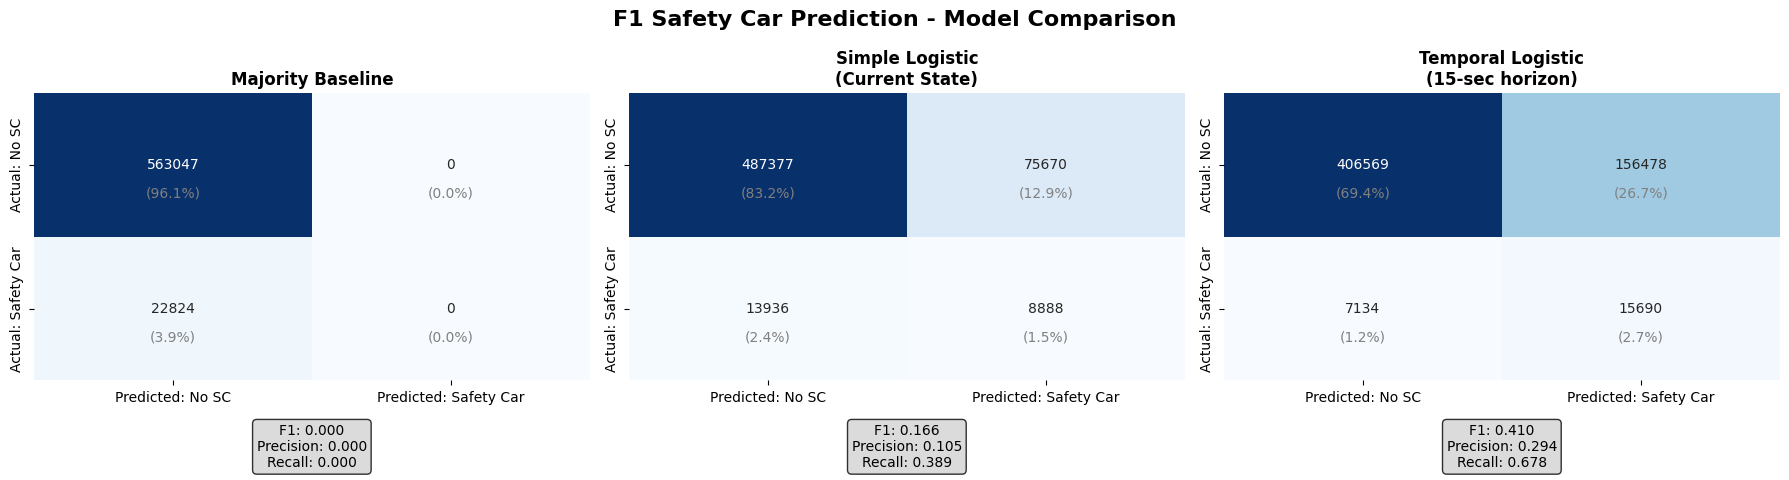

CONFUSION MATRIX SUMMARY

Majority Baseline:
  True Negatives:  563,047
  False Positives: 0
  False Negatives: 22,824
  True Positives:  0
  F1-Score: 0.000
  Precision: 0.000
  Recall: 0.000

Simple Logistic (Current State):
  True Negatives:  487,377
  False Positives: 75,670
  False Negatives: 13,936
  True Positives:  8,888
  F1-Score: 0.166
  Precision: 0.105
  Recall: 0.389

Temporal Logistic (15-sec horizon):
  True Negatives:  406,569
  False Positives: 156,478
  False Negatives: 7,134
  True Positives:  15,690
  F1-Score: 0.410
  Precision: 0.294
  Recall: 0.678




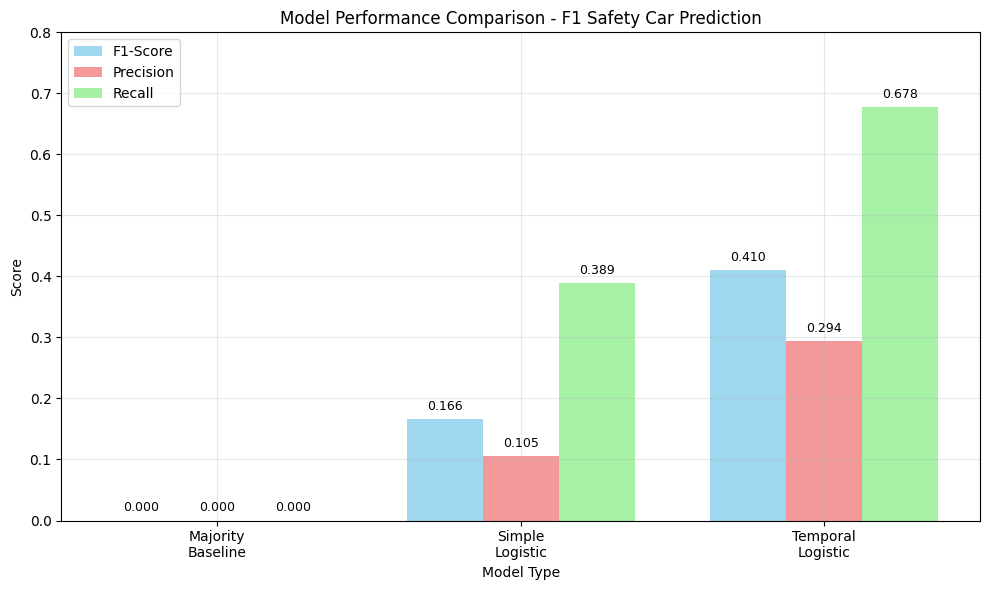

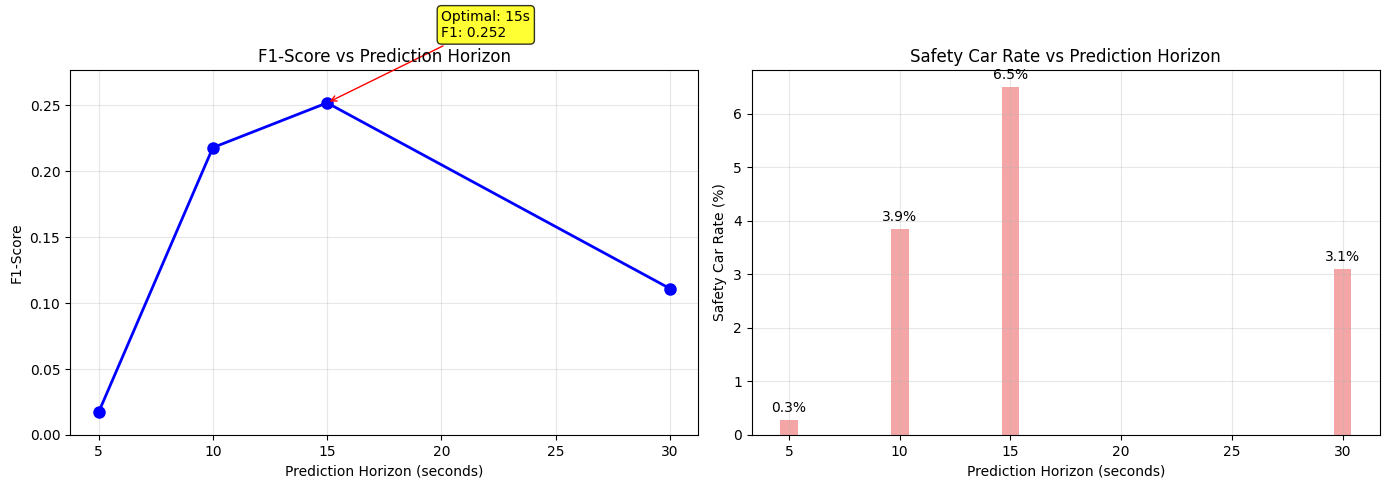

PREDICTION HORIZON ANALYSIS
 5 seconds: F1=0.017, SC Rate=0.3%
10 seconds: F1=0.218, SC Rate=3.9%
15 seconds: F1=0.252, SC Rate=6.5%
30 seconds: F1=0.111, SC Rate=3.1%




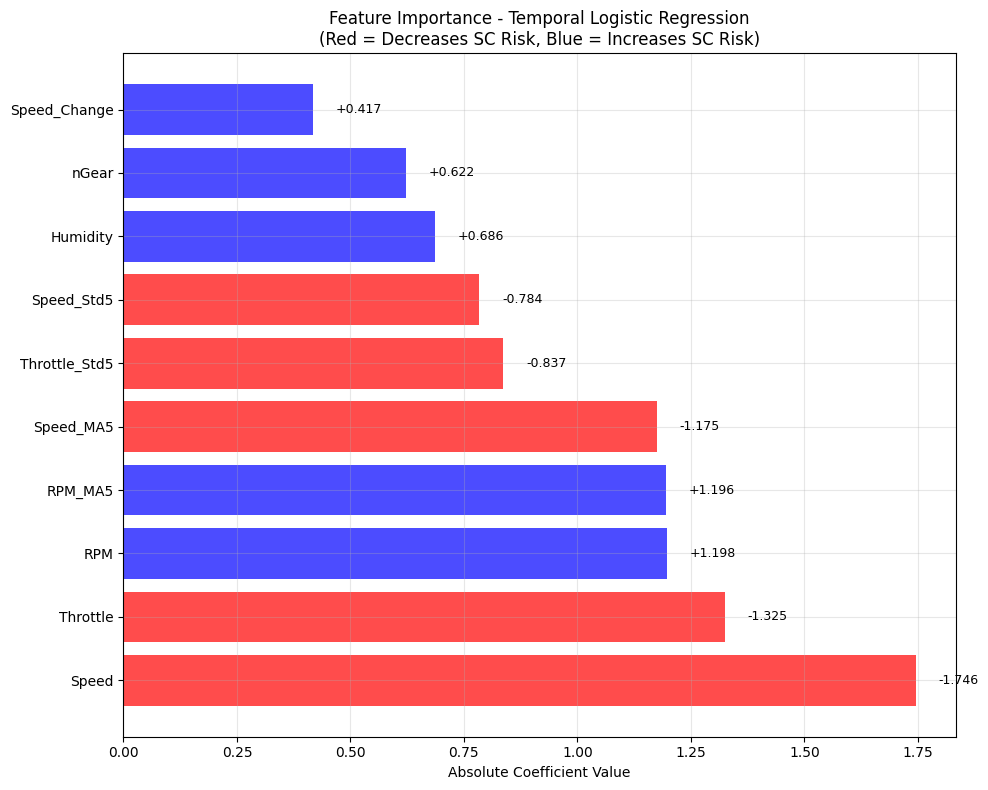


All visualizations complete!


In [180]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

def create_confusion_matrices_summary():
    """
    Create publication-ready confusion matrices for all model experiments.
    """
    # Define the confusion matrices from your experiments
    confusion_matrices = {
        'Majority Baseline': {
            'tn': 563047, 'fp': 0, 'fn': 22824, 'tp': 0,
            'f1': 0.000, 'precision': 0.000, 'recall': 0.000
        },
        'Simple Logistic\n(Current State)': {
            'tn': 487377, 'fp': 75670, 'fn': 13936, 'tp': 8888,
            'f1': 0.166, 'precision': 0.105, 'recall': 0.389
        },
        'Temporal Logistic\n(15-sec horizon)': {
            'tn': 406569, 'fp': 156478, 'fn': 7134, 'tp': 15690,
            'f1': 0.410, 'precision': 0.294, 'recall': 0.678
        }
    }
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('F1 Safety Car Prediction - Model Comparison', fontsize=16, fontweight='bold')
    
    for idx, (model_name, metrics) in enumerate(confusion_matrices.items()):
        ax = axes[idx]
        
        # Create confusion matrix
        cm = np.array([
            [metrics['tn'], metrics['fp']],
            [metrics['fn'], metrics['tp']]
        ])
        
        # Calculate percentages for display
        cm_percent = cm.astype('float') / cm.sum() * 100
        
        # Create heatmap
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                   xticklabels=['Predicted: No SC', 'Predicted: Safety Car'],
                   yticklabels=['Actual: No SC', 'Actual: Safety Car'],
                   cbar=False)
        
        # Add percentage annotations
        for i in range(2):
            for j in range(2):
                ax.text(j + 0.5, i + 0.7, f'({cm_percent[i,j]:.1f}%)', 
                       ha='center', va='center', fontsize=10, color='gray')
        
        # Add performance metrics
        ax.text(0.5, -0.15, 
               f'F1: {metrics["f1"]:.3f}\nPrecision: {metrics["precision"]:.3f}\nRecall: {metrics["recall"]:.3f}',
               transform=ax.transAxes, ha='center', va='top',
               bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
        
        ax.set_title(model_name, fontweight='bold')
        ax.set_xlabel('')
        ax.set_ylabel('')
    
    plt.tight_layout()
    plt.show()
    
    # Print numerical summary
    print("CONFUSION MATRIX SUMMARY")
    print("=" * 60)
    for model_name, metrics in confusion_matrices.items():
        clean_name = model_name.replace('\n', ' ')
        print(f"\n{clean_name}:")
        print(f"  True Negatives:  {metrics['tn']:,}")
        print(f"  False Positives: {metrics['fp']:,}")
        print(f"  False Negatives: {metrics['fn']:,}")
        print(f"  True Positives:  {metrics['tp']:,}")
        print(f"  F1-Score: {metrics['f1']:.3f}")
        print(f"  Precision: {metrics['precision']:.3f}")
        print(f"  Recall: {metrics['recall']:.3f}")

def create_performance_comparison_chart():
    """
    Create a bar chart comparing model performance across metrics.
    """
    models = ['Majority\nBaseline', 'Simple\nLogistic', 'Temporal\nLogistic']
    f1_scores = [0.000, 0.166, 0.410]
    precision = [0.000, 0.105, 0.294]
    recall = [0.000, 0.389, 0.678]
    
    x = np.arange(len(models))
    width = 0.25
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    bars1 = ax.bar(x - width, f1_scores, width, label='F1-Score', color='skyblue', alpha=0.8)
    bars2 = ax.bar(x, precision, width, label='Precision', color='lightcoral', alpha=0.8)
    bars3 = ax.bar(x + width, recall, width, label='Recall', color='lightgreen', alpha=0.8)
    
    ax.set_xlabel('Model Type')
    ax.set_ylabel('Score')
    ax.set_title('Model Performance Comparison - F1 Safety Car Prediction')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend()
    ax.set_ylim(0, 0.8)
    ax.grid(True, alpha=0.3)
    
    # Add value labels on bars
    def add_value_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    add_value_labels(bars1)
    add_value_labels(bars2)
    add_value_labels(bars3)
    
    plt.tight_layout()
    plt.show()

def create_prediction_horizon_analysis():
    """
    Visualize how different prediction horizons affect performance.
    """
    horizons = [5, 10, 15, 30]
    f1_scores = [0.017, 0.218, 0.252, 0.111]
    safety_car_rates = [0.28, 3.85, 6.50, 3.09]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # F1 Score vs Prediction Horizon
    ax1.plot(horizons, f1_scores, 'bo-', linewidth=2, markersize=8)
    ax1.set_xlabel('Prediction Horizon (seconds)')
    ax1.set_ylabel('F1-Score')
    ax1.set_title('F1-Score vs Prediction Horizon')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, max(f1_scores) * 1.1)
    
    # Highlight optimal point
    max_idx = f1_scores.index(max(f1_scores))
    ax1.annotate(f'Optimal: {horizons[max_idx]}s\nF1: {f1_scores[max_idx]:.3f}', 
                xy=(horizons[max_idx], f1_scores[max_idx]),
                xytext=(horizons[max_idx] + 5, f1_scores[max_idx] + 0.05),
                arrowprops=dict(arrowstyle='->', color='red'),
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))
    
    # Safety Car Rate vs Prediction Horizon
    ax2.bar(horizons, safety_car_rates, color='lightcoral', alpha=0.7)
    ax2.set_xlabel('Prediction Horizon (seconds)')
    ax2.set_ylabel('Safety Car Rate (%)')
    ax2.set_title('Safety Car Rate vs Prediction Horizon')
    ax2.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (h, rate) in enumerate(zip(horizons, safety_car_rates)):
        ax2.text(h, rate + 0.1, f'{rate:.1f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    print("PREDICTION HORIZON ANALYSIS")
    print("=" * 40)
    for h, f1, rate in zip(horizons, f1_scores, safety_car_rates):
        print(f"{h:2d} seconds: F1={f1:.3f}, SC Rate={rate:.1f}%")

def create_feature_importance_visualization():
    """
    Create feature importance visualization based on your results.
    """
    features = ['Speed', 'Throttle', 'RPM', 'RPM_MA5', 'Speed_MA5', 
               'Throttle_Std5', 'Speed_Std5', 'Humidity', 'nGear', 'Speed_Change']
    coefficients = [-1.746, -1.325, 1.198, 1.196, -1.175, 
                   -0.837, -0.784, 0.686, 0.622, 0.417]
    
    # Sort by absolute importance
    importance_data = list(zip(features, coefficients))
    importance_data.sort(key=lambda x: abs(x[1]), reverse=True)
    
    features_sorted, coef_sorted = zip(*importance_data)
    
    # Create horizontal bar plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    colors = ['red' if coef < 0 else 'blue' for coef in coef_sorted]
    bars = ax.barh(range(len(features_sorted)), [abs(c) for c in coef_sorted], color=colors, alpha=0.7)
    
    ax.set_yticks(range(len(features_sorted)))
    ax.set_yticklabels(features_sorted)
    ax.set_xlabel('Absolute Coefficient Value')
    ax.set_title('Feature Importance - Temporal Logistic Regression\n(Red = Decreases SC Risk, Blue = Increases SC Risk)')
    ax.grid(True, alpha=0.3)
    
    # Add coefficient values
    for i, (coef, bar) in enumerate(zip(coef_sorted, bars)):
        ax.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height()/2,
               f'{coef:+.3f}', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()

# Run all visualizations
if __name__ == "__main__":
    print("Creating F1 Safety Car Prediction Analysis Visualizations...")
    
    create_confusion_matrices_summary()
    print("\n" + "="*60 + "\n")
    
    create_performance_comparison_chart()
    print("\n" + "="*60 + "\n")
    
    create_prediction_horizon_analysis()
    print("\n" + "="*60 + "\n")
    
    create_feature_importance_visualization()
    print("\nAll visualizations complete!")